# Feature engineering

In [ ]:
from limpieza_with_min import main
file_path = "/home/cord2108/ITAM/Aplicada/Proyecto_final/atp_data/atp_matches_till_2022.csv"
final_data = main(file_path, show_plots=True)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from scipy import stats
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from limpieza_with_min import main

df = pd.read_csv('/home/cord2108/ITAM/Aplicada/Proyecto_final/atp_data/final_tennis_data.csv')
display(df.head())
sorted(df.columns)
df_clean = df.copy()


# Regresion lineal

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Assuming df_clean is your DataFrame
# df_clean = your_dataframe_here

def create_regression_models(df):
    """
    Create and compare multiple linear regression models
    """
    
    # Define different feature sets
    models = {
        'Model 1 - Basic': ['round_group_QF', 'round_group_SF', 'round_group_Other', 
                           'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points'],
        
        'Model 2 - With Player Stats': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                       'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                       'loser_rank_points', 'w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'],
        
        'Model 3 - With Historical Minutes': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                            'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                            'loser_rank_points', 'w_avg_minutes', 'l_avg_minutes'],
        
        'Model 4 - Full Model': ['age_diff', 'round_group_QF', 'round_group_SF', 'round_group_Other',
                                'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points',
                                'w_avg_ace', 'w_avg_df', 'w_avg_minutes', 'l_avg_ace', 'l_avg_df', 'l_avg_minutes']
    }
    
    # Target variable
    y = df['minutes']
    
    # Store results
    results = {}
    trained_models = {}
    test_data = {}  # Store test data for each model
    
    # Split data once for consistent comparison using the basic model features
    X_basic = df[models['Model 1 - Basic']]
    _, _, _, y_test = train_test_split(X_basic, y, test_size=0.2, random_state=42)
    
    print("=== LINEAR REGRESSION MODELS COMPARISON ===\n")
    
    for model_name, features in models.items():
        print(f"\n--- {model_name} ---")
        print(f"Features: {len(features)}")
        
        # Prepare data for this specific model
        X = df[features]
        X_train, X_test, y_train_model, y_test_model = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Store test data for later use
        test_data[model_name] = {'X_test': X_test, 'y_test': y_test_model}
        
        # Create and train model
        model = LinearRegression()
        model.fit(X_train, y_train_model)
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Metrics
        train_r2 = r2_score(y_train_model, y_pred_train)
        test_r2 = r2_score(y_test_model, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train_model, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test_model, y_pred_test))
        train_mae = mean_absolute_error(y_train_model, y_pred_train)
        test_mae = mean_absolute_error(y_test_model, y_pred_test)
        
        # Store results
        results[model_name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'features': features,
            'coefficients': model.coef_,
            'intercept': model.intercept_
        }
        
        trained_models[model_name] = model
        
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")
        print(f"Train RMSE: {train_rmse:.2f}")
        print(f"Test RMSE: {test_rmse:.2f}")
        print(f"Train MAE: {train_mae:.2f}")
        print(f"Test MAE: {test_mae:.2f}")
    
    return results, trained_models, test_data

def plot_model_comparison(results):
    """
    Create comparison plots for all models
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    models = list(results.keys())
    
    # R² comparison
    train_r2 = [results[model]['train_r2'] for model in models]
    test_r2 = [results[model]['test_r2'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    axes[0,0].bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8)
    axes[0,0].bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8)
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('R² Score Comparison')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([m.replace('Model ', 'M') for m in models], rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    train_rmse = [results[model]['train_rmse'] for model in models]
    test_rmse = [results[model]['test_rmse'] for model in models]
    
    axes[0,1].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
    axes[0,1].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('RMSE (minutes)')
    axes[0,1].set_title('RMSE Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([m.replace('Model ', 'M') for m in models], rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # MAE comparison
    train_mae = [results[model]['train_mae'] for model in models]
    test_mae = [results[model]['test_mae'] for model in models]
    
    axes[1,0].bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8)
    axes[1,0].bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8)
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('MAE (minutes)')
    axes[1,0].set_title('MAE Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels([m.replace('Model ', 'M') for m in models], rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Overfitting analysis (Train R² - Test R²)
    overfitting = [results[model]['train_r2'] - results[model]['test_r2'] for model in models]
    
    axes[1,1].bar(models, overfitting, alpha=0.8, color='coral')
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Train R² - Test R²')
    axes[1,1].set_title('Overfitting Analysis')
    axes[1,1].set_xticklabels([m.replace('Model ', 'M') for m in models], rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def plot_detailed_model_analysis(model_name, results, trained_models, test_data, df):
    """
    Detailed analysis of a specific model
    """
    
    model = trained_models[model_name]
    features = results[model_name]['features']
    
    # Get the correct test data for this model
    X_test = test_data[model_name]['X_test']
    y_test = test_data[model_name]['y_test']
    
    # Predictions
    y_pred = model.predict(X_test)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Detailed Analysis: {model_name}', fontsize=16, fontweight='bold')
    
    # Actual vs Predicted
    axes[0,0].scatter(y_test, y_pred, alpha=0.6, color='steelblue')
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Minutes')
    axes[0,0].set_ylabel('Predicted Minutes')
    axes[0,0].set_title('Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add R² to the plot
    r2 = r2_score(y_test, y_pred)
    axes[0,0].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0,0].transAxes, 
                   bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # Residuals
    residuals = y_test - y_pred
    axes[0,1].scatter(y_pred, residuals, alpha=0.6, color='coral')
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Predicted Minutes')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residual Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    # Feature importance (coefficients)
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=True)
    
    # Color bars based on positive/negative coefficients
    colors = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
    axes[1,0].barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.7)
    axes[1,0].set_xlabel('Coefficient Value')
    axes[1,0].set_title('Feature Coefficients')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Distribution of residuals
    axes[1,1].hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='lightblue')
    axes[1,1].set_xlabel('Residuals')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Residuals')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add normal distribution overlay
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    axes[1,1].plot(x, len(residuals) * (residuals.max() - residuals.min()) / 30 * 
                   (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2),
                   'r-', linewidth=2, label='Normal Distribution')
    axes[1,1].legend()
    
    # Add residual statistics
    axes[1,1].text(0.02, 0.98, f'Mean: {mu:.2f}\nStd: {sigma:.2f}', 
                   transform=axes[1,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_all_models_detailed_analysis(results, trained_models, test_data, df):
    """
    Show detailed analysis for all models
    """
    print("\n" + "="*60)
    print("DETAILED ANALYSIS FOR ALL MODELS")
    print("="*60)
    
    for model_name in results.keys():
        print(f"\nGenerating detailed analysis for: {model_name}")
        plot_detailed_model_analysis(model_name, results, trained_models, test_data, df)
        
        # Print model summary
        model_results = results[model_name]
        print(f"\n📊 {model_name} Summary:")
        print(f"   • Test R²: {model_results['test_r2']:.4f}")
        print(f"   • Test RMSE: {model_results['test_rmse']:.2f} minutes")
        print(f"   • Test MAE: {model_results['test_mae']:.2f} minutes")
        print(f"   • Number of features: {len(model_results['features'])}")
        
        # Show top 3 most important features (by absolute coefficient value)
        coef_df = pd.DataFrame({
            'Feature': model_results['features'],
            'Coefficient': model_results['coefficients']
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        print(f"   • Top 3 most influential features:")
        for i, (_, row) in enumerate(coef_df.head(3).iterrows(), 1):
            direction = "increases" if row['Coefficient'] > 0 else "decreases"
            print(f"     {i}. {row['Feature']}: {direction} match duration by {abs(row['Coefficient']):.2f} min per unit")
        
        print("-" * 50)

def print_best_model_summary(results):
    """
    Print summary of the best model
    """
    
    # Find best model based on test R²
    best_model = max(results.items(), key=lambda x: x[1]['test_r2'])
    best_name, best_metrics = best_model
    
    print("\n" + "="*50)
    print("BEST MODEL SUMMARY")
    print("="*50)
    print(f"Model: {best_name}")
    print(f"Test R²: {best_metrics['test_r2']:.4f}")
    print(f"Test RMSE: {best_metrics['test_rmse']:.2f} minutes")
    print(f"Test MAE: {best_metrics['test_mae']:.2f} minutes")
    print(f"Number of features: {len(best_metrics['features'])}")
    
    print(f"\nFeatures used:")
    for i, feature in enumerate(best_metrics['features'], 1):
        print(f"{i:2d}. {feature}")
    
    return best_name

def run_complete_analysis(df):
    """
    Run the complete regression analysis
    """
    
    print("Starting Tennis Match Duration Analysis...")
    print(f"Dataset shape: {df.shape}")
    print(f"Target variable (minutes) - Mean: {df['minutes'].mean():.2f}, Std: {df['minutes'].std():.2f}")
    
    # Run all models
    results, trained_models, test_data = create_regression_models(df)
    
    # Plot comparison
    plot_model_comparison(results)
    
    # Find and print best model summary
    best_model_name = print_best_model_summary(results)
    
    # Detailed analysis of ALL models
    plot_all_models_detailed_analysis(results, trained_models, test_data, df)
    
    return results, trained_models

def run_analysis_single_model(df, model_name=None):
    """
    Run analysis for a single specific model
    """
    
    # Run all models first
    results, trained_models, test_data = create_regression_models(df)
    
    if model_name is None:
        # Show available models
        print("Available models:")
        for i, name in enumerate(results.keys(), 1):
            print(f"{i}. {name}")
        return results, trained_models
    
    if model_name in results:
        print(f"\n=== DETAILED ANALYSIS FOR {model_name} ===")
        plot_detailed_model_analysis(model_name, results, trained_models, test_data, df)
        
        # Print detailed coefficient analysis
        model_results = results[model_name]
        print(f"\n📊 Detailed Coefficient Analysis for {model_name}:")
        print("-" * 60)
        
        coef_df = pd.DataFrame({
            'Feature': model_results['features'],
            'Coefficient': model_results['coefficients']
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        for _, row in coef_df.iterrows():
            direction = "increases" if row['Coefficient'] > 0 else "decreases"
            print(f"• {row['Feature']:<25}: {direction} duration by {abs(row['Coefficient']):6.2f} minutes per unit")
        
    else:
        print(f"Model '{model_name}' not found. Available models: {list(results.keys())}")
    
    return results, trained_models

# Example usage:
# Uncomment the following lines and replace 'df_clean' with your actual DataFrame

# OPTION 1: Complete analysis with ALL models detailed analysis
results, models = run_complete_analysis(df_clean)

# OPTION 2: Analysis for a specific model only
# results, models = run_analysis_single_model(df_clean, 'Model 4 - Full Model')

# OPTION 3: See available models and choose one
# results, models = run_analysis_single_model(df_clean)

# print("Code is ready! Choose one of these options:")
# print("\n🔍 OPTION 1 - Complete Analysis (ALL models with detailed plots):")
# print("results, models = run_complete_analysis(df_clean)")

# print("\n🎯 OPTION 2 - Single Model Analysis:")
# print("results, models = run_analysis_single_model(df_clean, 'Model 1 - Basic')")

# print("\n📋 OPTION 3 - List available models:")
# print("results, models = run_analysis_single_model(df_clean)")

# print("\n💡 Available model names:")
# print("• 'Model 1 - Basic'")
# print("• 'Model 2 - With Player Stats'") 
# print("• 'Model 3 - With Historical Minutes'")
# print("• 'Model 4 - Full Model'")

# XG Boost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def create_xgboost_models(df):
    """
    Create and compare multiple XGBoost regression models
    """
    
    # Define different feature sets
    models = {
        'XGB Model 1 - Basic': ['round_group_QF', 'round_group_SF', 'round_group_Other', 
                                'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points'],
        
        'XGB Model 2 - With Player Stats': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                           'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                           'loser_rank_points', 'w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'],
        
        'XGB Model 3 - With Historical Minutes': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                                 'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                                 'loser_rank_points', 'w_avg_minutes', 'l_avg_minutes'],
        
        'XGB Model 4 - Full Model': ['age_diff', 'round_group_QF', 'round_group_SF', 'round_group_Other',
                                     'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points',
                                     'w_avg_ace', 'w_avg_df', 'w_avg_minutes', 'l_avg_ace', 'l_avg_df', 'l_avg_minutes']
    }
    
    # Target variable
    y = df['minutes']
    
    # Store results
    results = {}
    trained_models = {}
    test_data = {}  # Store test data for each model
    
    print("=== XGBOOST REGRESSION MODELS COMPARISON ===\n")
    
    for model_name, features in models.items():
        print(f"\n--- {model_name} ---")
        print(f"Features: {len(features)}")
        
        # Prepare data for this specific model
        X = df[features]
        X_train, X_test, y_train_model, y_test_model = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Store test data for later use
        test_data[model_name] = {'X_test': X_test, 'y_test': y_test_model}
        
        # Create and train XGBoost model
        model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(X_train, y_train_model)
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Metrics
        train_r2 = r2_score(y_train_model, y_pred_train)
        test_r2 = r2_score(y_test_model, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train_model, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test_model, y_pred_test))
        train_mae = mean_absolute_error(y_train_model, y_pred_train)
        test_mae = mean_absolute_error(y_test_model, y_pred_test)
        
        # Get feature importance
        feature_importance = model.feature_importances_
        
        # Store results
        results[model_name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'features': features,
            'feature_importance': feature_importance
        }
        
        trained_models[model_name] = model
        
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")
        print(f"Train RMSE: {train_rmse:.2f}")
        print(f"Test RMSE: {test_rmse:.2f}")
        print(f"Train MAE: {train_mae:.2f}")
        print(f"Test MAE: {test_mae:.2f}")
    
    return results, trained_models, test_data

def plot_xgboost_model_comparison(results):
    """
    Create comparison plots for all XGBoost models
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('XGBoost Model Performance Comparison', fontsize=16, fontweight='bold')
    
    models = list(results.keys())
    
    # R² comparison
    train_r2 = [results[model]['train_r2'] for model in models]
    test_r2 = [results[model]['test_r2'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    axes[0,0].bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8, color='skyblue')
    axes[0,0].bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8, color='lightcoral')
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('R² Score Comparison')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([m.replace('XGB Model ', 'XGB M') for m in models], rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    train_rmse = [results[model]['train_rmse'] for model in models]
    test_rmse = [results[model]['test_rmse'] for model in models]
    
    axes[0,1].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8, color='lightgreen')
    axes[0,1].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8, color='orange')
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('RMSE (minutes)')
    axes[0,1].set_title('RMSE Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([m.replace('XGB Model ', 'XGB M') for m in models], rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # MAE comparison
    train_mae = [results[model]['train_mae'] for model in models]
    test_mae = [results[model]['test_mae'] for model in models]
    
    axes[1,0].bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8, color='plum')
    axes[1,0].bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8, color='gold')
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('MAE (minutes)')
    axes[1,0].set_title('MAE Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels([m.replace('XGB Model ', 'XGB M') for m in models], rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Overfitting analysis (Train R² - Test R²)
    overfitting = [results[model]['train_r2'] - results[model]['test_r2'] for model in models]
    
    colors = ['red' if x > 0.05 else 'green' if x < 0 else 'orange' for x in overfitting]
    axes[1,1].bar(range(len(models)), overfitting, alpha=0.8, color=colors)
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Train R² - Test R²')
    axes[1,1].set_title('Overfitting Analysis')
    axes[1,1].set_xticks(range(len(models)))
    axes[1,1].set_xticklabels([m.replace('XGB Model ', 'XGB M') for m in models], rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1,1].axhline(y=0.05, color='red', linestyle=':', alpha=0.5, label='Overfitting threshold')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

def plot_detailed_xgboost_analysis(model_name, results, trained_models, test_data, df):
    """
    Detailed analysis of a specific XGBoost model
    """
    
    model = trained_models[model_name]
    features = results[model_name]['features']
    
    # Get the correct test data for this model
    X_test = test_data[model_name]['X_test']
    y_test = test_data[model_name]['y_test']
    
    # Predictions
    y_pred = model.predict(X_test)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Detailed XGBoost Analysis: {model_name}', fontsize=16, fontweight='bold')
    
    # Actual vs Predicted
    axes[0,0].scatter(y_test, y_pred, alpha=0.6, color='steelblue', s=50)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Minutes')
    axes[0,0].set_ylabel('Predicted Minutes')
    axes[0,0].set_title('Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add R² and RMSE to the plot
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    axes[0,0].text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.2f}', 
                   transform=axes[0,0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # Residuals
    residuals = y_test - y_pred
    axes[0,1].scatter(y_pred, residuals, alpha=0.6, color='coral', s=50)
    axes[0,1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Predicted Minutes')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residual Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add residual statistics
    res_mean, res_std = residuals.mean(), residuals.std()
    axes[0,1].text(0.05, 0.95, f'Mean: {res_mean:.2f}\nStd: {res_std:.2f}', 
                   transform=axes[0,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
    
    # Feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': results[model_name]['feature_importance']
    }).sort_values('Importance', ascending=True)
    
    # Color bars based on importance level
    colors = plt.cm.viridis(importance_df['Importance'] / importance_df['Importance'].max())
    bars = axes[1,0].barh(importance_df['Feature'], importance_df['Importance'], color=colors)
    axes[1,0].set_xlabel('Feature Importance')
    axes[1,0].set_title('XGBoost Feature Importance')
    axes[1,0].grid(True, alpha=0.3)
    
    # Add importance values on bars
    for i, (bar, importance) in enumerate(zip(bars, importance_df['Importance'])):
        axes[1,0].text(importance + importance_df['Importance'].max() * 0.01, 
                      bar.get_y() + bar.get_height()/2, 
                      f'{importance:.3f}', 
                      va='center', fontsize=9)
    
    # Distribution of residuals with improved visualization
    axes[1,1].hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='lightblue', density=True)
    axes[1,1].set_xlabel('Residuals')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Distribution of Residuals')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add normal distribution overlay
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    normal_dist = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    axes[1,1].plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    axes[1,1].legend()
    
    # Add Q-Q plot line for normality check
    from scipy import stats
    _, p_value = stats.normaltest(residuals)
    axes[1,1].text(0.02, 0.98, f'Normality p-value: {p_value:.4f}', 
                   transform=axes[1,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_all_xgboost_models_analysis(results, trained_models, test_data, df):
    """
    Show detailed analysis for all XGBoost models
    """
    print("\n" + "="*70)
    print("DETAILED XGBOOST ANALYSIS FOR ALL MODELS")
    print("="*70)
    
    for model_name in results.keys():
        print(f"\nGenerating detailed analysis for: {model_name}")
        plot_detailed_xgboost_analysis(model_name, results, trained_models, test_data, df)
        
        # Print model summary with feature importance
        model_results = results[model_name]
        print(f"\n🚀 {model_name} Summary:")
        print(f"   • Test R²: {model_results['test_r2']:.4f}")
        print(f"   • Test RMSE: {model_results['test_rmse']:.2f} minutes")
        print(f"   • Test MAE: {model_results['test_mae']:.2f} minutes")
        print(f"   • Number of features: {len(model_results['features'])}")
        
        # Show top 3 most important features
        importance_df = pd.DataFrame({
            'Feature': model_results['features'],
            'Importance': model_results['feature_importance']
        }).sort_values('Importance', ascending=False)
        
        print(f"   • Top 3 most important features:")
        for i, (_, row) in enumerate(importance_df.head(3).iterrows(), 1):
            print(f"     {i}. {row['Feature']}: {row['Importance']:.4f} importance score")
        
        # Overfitting check
        overfitting_score = model_results['train_r2'] - model_results['test_r2']
        if overfitting_score > 0.05:
            print(f"   ⚠️  High overfitting detected: {overfitting_score:.4f}")
        elif overfitting_score < 0:
            print(f"   ✅ No overfitting (model generalizes well): {overfitting_score:.4f}")
        else:
            print(f"   ✅ Low overfitting: {overfitting_score:.4f}")
            
        print("-" * 60)

def print_best_xgboost_model_summary(results):
    """
    Print summary of the best XGBoost model
    """
    
    # Find best model based on test R²
    best_model = max(results.items(), key=lambda x: x[1]['test_r2'])
    best_name, best_metrics = best_model
    
    print("\n" + "="*60)
    print("BEST XGBOOST MODEL SUMMARY")
    print("="*60)
    print(f"Model: {best_name}")
    print(f"Test R²: {best_metrics['test_r2']:.4f}")
    print(f"Test RMSE: {best_metrics['test_rmse']:.2f} minutes")
    print(f"Test MAE: {best_metrics['test_mae']:.2f} minutes")
    print(f"Number of features: {len(best_metrics['features'])}")
    
    print(f"\nTop 5 Most Important Features:")
    importance_df = pd.DataFrame({
        'Feature': best_metrics['features'],
        'Importance': best_metrics['feature_importance']
    }).sort_values('Importance', ascending=False)
    
    for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
        print(f"{i:2d}. {row['Feature']:<25}: {row['Importance']:.4f}")
    
    return best_name

def run_complete_xgboost_analysis(df):
    """
    Run the complete XGBoost regression analysis
    """
    
    print("Starting Tennis Match Duration XGBoost Analysis...")
    print(f"Dataset shape: {df.shape}")
    print(f"Target variable (minutes) - Mean: {df['minutes'].mean():.2f}, Std: {df['minutes'].std():.2f}")
    
    # Run all XGBoost models
    results, trained_models, test_data = create_xgboost_models(df)
    
    # Plot comparison
    plot_xgboost_model_comparison(results)
    
    # Find and print best model summary
    best_model_name = print_best_xgboost_model_summary(results)
    
    # Detailed analysis of ALL models
    plot_all_xgboost_models_analysis(results, trained_models, test_data, df)
    
    return results, trained_models

def run_xgboost_analysis_single_model(df, model_name=None):
    """
    Run XGBoost analysis for a single specific model
    """
    
    # Run all models first
    results, trained_models, test_data = create_xgboost_models(df)
    
    if model_name is None:
        # Show available models
        print("Available XGBoost models:")
        for i, name in enumerate(results.keys(), 1):
            print(f"{i}. {name}")
        return results, trained_models
    
    if model_name in results:
        print(f"\n=== DETAILED XGBOOST ANALYSIS FOR {model_name} ===")
        plot_detailed_xgboost_analysis(model_name, results, trained_models, test_data, df)
        
        # Print detailed feature importance analysis
        model_results = results[model_name]
        print(f"\n🚀 Detailed Feature Importance Analysis for {model_name}:")
        print("-" * 70)
        
        importance_df = pd.DataFrame({
            'Feature': model_results['features'],
            'Importance': model_results['feature_importance']
        }).sort_values('Importance', ascending=False)
        
        total_importance = importance_df['Importance'].sum()
        
        for _, row in importance_df.iterrows():
            percentage = (row['Importance'] / total_importance) * 100
            print(f"• {row['Feature']:<25}: {row['Importance']:.4f} ({percentage:5.1f}% of total importance)")
        
    else:
        print(f"Model '{model_name}' not found. Available models: {list(results.keys())}")
    
    return results, trained_models

def compare_linear_vs_xgboost(df, linear_results, xgb_results):
    """
    Compare Linear Regression vs XGBoost performance
    """
    
    print("\n" + "="*80)
    print("LINEAR REGRESSION vs XGBOOST COMPARISON")
    print("="*80)
    
    comparison_data = []
    
    # Map corresponding models
    model_mapping = {
        'Model 1 - Basic': 'XGB Model 1 - Basic',
        'Model 2 - With Player Stats': 'XGB Model 2 - With Player Stats',
        'Model 3 - With Historical Minutes': 'XGB Model 3 - With Historical Minutes',
        'Model 4 - Full Model': 'XGB Model 4 - Full Model'
    }
    
    for linear_name, xgb_name in model_mapping.items():
        if linear_name in linear_results and xgb_name in xgb_results:
            linear_r2 = linear_results[linear_name]['test_r2']
            xgb_r2 = xgb_results[xgb_name]['test_r2']
            linear_rmse = linear_results[linear_name]['test_rmse']
            xgb_rmse = xgb_results[xgb_name]['test_rmse']
            
            improvement_r2 = ((xgb_r2 - linear_r2) / linear_r2) * 100
            improvement_rmse = ((linear_rmse - xgb_rmse) / linear_rmse) * 100
            
            print(f"\n{linear_name.replace('Model ', '')}:")
            print(f"  Linear Regression - R²: {linear_r2:.4f}, RMSE: {linear_rmse:.2f}")
            print(f"  XGBoost          - R²: {xgb_r2:.4f}, RMSE: {xgb_rmse:.2f}")
            print(f"  Improvement      - R²: {improvement_r2:+.1f}%, RMSE: {improvement_rmse:+.1f}%")
            
            if improvement_r2 > 5:
                print(f"  🚀 XGBoost significantly outperforms Linear Regression!")
            elif improvement_r2 > 0:
                print(f"  ✅ XGBoost performs better")
            else:
                print(f"  ⚠️  Linear Regression performs better")

# Example usage:
print("🚀 XGBoost Analysis Code is ready! Choose one of these options:")
print("\n🔍 OPTION 1 - Complete XGBoost Analysis (ALL models with detailed plots):")
print("xgb_results, xgb_models = run_complete_xgboost_analysis(df_clean)")

print("\n🎯 OPTION 2 - Single XGBoost Model Analysis:")
print("xgb_results, xgb_models = run_xgboost_analysis_single_model(df_clean, 'XGB Model 4 - Full Model')")

print("\n📋 OPTION 3 - List available XGBoost models:")
print("xgb_results, xgb_models = run_xgboost_analysis_single_model(df_clean)")

print("\n🆚 OPTION 4 - Compare Linear Regression vs XGBoost:")
print("# First run both analyses, then:")
print("compare_linear_vs_xgboost(df_clean, linear_results, xgb_results)")

print("\n💡 Available XGBoost model names:")
print("• 'XGB Model 1 - Basic'")
print("• 'XGB Model 2 - With Player Stats'") 
print("• 'XGB Model 3 - With Historical Minutes'")
print("• 'XGB Model 4 - Full Model'")

xgb_results, xgb_models = run_complete_xgboost_analysis(df_clean)

# Random forest

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def create_randomforest_models(df):
    """
    Create and compare multiple Random Forest regression models
    """
    
    # Define different feature sets
    models = {
        'RF Model 1 - Basic': ['round_group_QF', 'round_group_SF', 'round_group_Other', 
                               'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points'],
        
        'RF Model 2 - With Player Stats': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                          'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                          'loser_rank_points', 'w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'],
        
        'RF Model 3 - With Historical Minutes': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                                'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                                'loser_rank_points', 'w_avg_minutes', 'l_avg_minutes'],
        
        'RF Model 4 - Full Model': ['age_diff', 'round_group_QF', 'round_group_SF', 'round_group_Other',
                                    'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points',
                                    'w_avg_ace', 'w_avg_df', 'w_avg_minutes', 'l_avg_ace', 'l_avg_df', 'l_avg_minutes']
    }
    
    # Target variable
    y = df['minutes']
    
    # Store results
    results = {}
    trained_models = {}
    test_data = {}
    
    print("=== RANDOM FOREST REGRESSION MODELS COMPARISON ===\n")
    
    for model_name, features in models.items():
        print(f"\n--- {model_name} ---")
        print(f"Features: {len(features)}")
        
        # Prepare data for this specific model
        X = df[features]
        X_train, X_test, y_train_model, y_test_model = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Store test data for later use
        test_data[model_name] = {'X_test': X_test, 'y_test': y_test_model}
        
        # Create and train Random Forest model
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            bootstrap=True,
            random_state=42,
            n_jobs=-1,
            oob_score=True
        )
        
        model.fit(X_train, y_train_model)
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Metrics
        train_r2 = r2_score(y_train_model, y_pred_train)
        test_r2 = r2_score(y_test_model, y_pred_test)
        oob_score = model.oob_score_
        train_rmse = np.sqrt(mean_squared_error(y_train_model, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test_model, y_pred_test))
        train_mae = mean_absolute_error(y_train_model, y_pred_train)
        test_mae = mean_absolute_error(y_test_model, y_pred_test)
        
        # Get feature importance
        feature_importance = model.feature_importances_
        
        # Calculate permutation importance
        perm_importance = permutation_importance(model, X_test, y_test_model, n_repeats=10, random_state=42)
        
        # Store results
        results[model_name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'oob_score': oob_score,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'features': features,
            'feature_importance': feature_importance,
            'permutation_importance': perm_importance.importances_mean
        }
        
        trained_models[model_name] = model
        
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")
        print(f"OOB Score: {oob_score:.4f}")
        print(f"Train RMSE: {train_rmse:.2f}")
        print(f"Test RMSE: {test_rmse:.2f}")
        print(f"Train MAE: {train_mae:.2f}")
        print(f"Test MAE: {test_mae:.2f}")
    
    return results, trained_models, test_data

def plot_randomforest_model_comparison(results):
    """
    Create comparison plots for all Random Forest models
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Random Forest Model Performance Comparison', fontsize=16, fontweight='bold')
    
    models = list(results.keys())
    
    # R² comparison (including OOB score)
    train_r2 = [results[model]['train_r2'] for model in models]
    test_r2 = [results[model]['test_r2'] for model in models]
    oob_r2 = [results[model]['oob_score'] for model in models]
    
    x = np.arange(len(models))
    width = 0.25
    
    axes[0,0].bar(x - width, train_r2, width, label='Train R²', alpha=0.8, color='skyblue')
    axes[0,0].bar(x, test_r2, width, label='Test R²', alpha=0.8, color='lightcoral')
    axes[0,0].bar(x + width, oob_r2, width, label='OOB R²', alpha=0.8, color='lightgreen')
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('R² Score Comparison (with OOB)')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([m.replace('RF Model ', 'RF M') for m in models], rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    train_rmse = [results[model]['train_rmse'] for model in models]
    test_rmse = [results[model]['test_rmse'] for model in models]
    
    axes[0,1].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8, color='lightgreen')
    axes[0,1].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8, color='orange')
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('RMSE (minutes)')
    axes[0,1].set_title('RMSE Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([m.replace('RF Model ', 'RF M') for m in models], rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # MAE comparison
    train_mae = [results[model]['train_mae'] for model in models]
    test_mae = [results[model]['test_mae'] for model in models]
    
    axes[1,0].bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8, color='plum')
    axes[1,0].bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8, color='gold')
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('MAE (minutes)')
    axes[1,0].set_title('MAE Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels([m.replace('RF Model ', 'RF M') for m in models], rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Overfitting analysis
    overfitting = [results[model]['train_r2'] - results[model]['test_r2'] for model in models]
    
    colors = ['red' if x > 0.05 else 'green' if x < 0 else 'orange' for x in overfitting]
    axes[1,1].bar(range(len(models)), overfitting, alpha=0.8, color=colors)
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Train R² - Test R²')
    axes[1,1].set_title('Overfitting Analysis')
    axes[1,1].set_xticks(range(len(models)))
    axes[1,1].set_xticklabels([m.replace('RF Model ', 'RF M') for m in models], rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1,1].axhline(y=0.05, color='red', linestyle=':', alpha=0.5, label='Overfitting threshold')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

def plot_detailed_randomforest_analysis(model_name, results, trained_models, test_data, df):
    """
    Detailed analysis of a specific Random Forest model
    """
    
    model = trained_models[model_name]
    features = results[model_name]['features']
    
    # Get the correct test data for this model
    X_test = test_data[model_name]['X_test']
    y_test = test_data[model_name]['y_test']
    
    # Predictions
    y_pred = model.predict(X_test)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Detailed Random Forest Analysis: {model_name}', fontsize=16, fontweight='bold')
    
    # Actual vs Predicted
    axes[0,0].scatter(y_test, y_pred, alpha=0.6, color='steelblue', s=50)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Minutes')
    axes[0,0].set_ylabel('Predicted Minutes')
    axes[0,0].set_title('Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add R² and RMSE to the plot
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    oob_score = results[model_name]['oob_score']
    axes[0,0].text(0.05, 0.95, f'Test R² = {r2:.4f}\nOOB R² = {oob_score:.4f}\nRMSE = {rmse:.2f}', 
                   transform=axes[0,0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # Residuals
    residuals = y_test - y_pred
    axes[0,1].scatter(y_pred, residuals, alpha=0.6, color='coral', s=50)
    axes[0,1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Predicted Minutes')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residual Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add residual statistics
    res_mean, res_std = residuals.mean(), residuals.std()
    axes[0,1].text(0.05, 0.95, f'Mean: {res_mean:.2f}\nStd: {res_std:.2f}', 
                   transform=axes[0,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
    
    # Feature importance comparison (Gini vs Permutation)
    gini_importance = results[model_name]['feature_importance']
    perm_importance = results[model_name]['permutation_importance']
    
    importance_df = pd.DataFrame({
        'Feature': features,
        'Gini_Importance': gini_importance,
        'Permutation_Importance': perm_importance
    }).sort_values('Permutation_Importance', ascending=True)
    
    y_pos = np.arange(len(features))
    axes[1,0].barh(y_pos - 0.2, importance_df['Gini_Importance'], height=0.4, 
                   alpha=0.7, color='lightgreen', label='Gini Importance')
    axes[1,0].barh(y_pos + 0.2, importance_df['Permutation_Importance'], height=0.4,
                   alpha=0.7, color='orange', label='Permutation Importance')
    axes[1,0].set_yticks(y_pos)
    axes[1,0].set_yticklabels(importance_df['Feature'])
    axes[1,0].set_xlabel('Importance Score')
    axes[1,0].set_title('Feature Importance Comparison')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Distribution of residuals
    axes[1,1].hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='lightblue', density=True)
    axes[1,1].set_xlabel('Residuals')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Distribution of Residuals')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add normal distribution overlay
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    normal_dist = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    axes[1,1].plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    axes[1,1].legend()
    
    # Add normality test info
    from scipy import stats
    _, p_value = stats.normaltest(residuals)
    axes[1,1].text(0.02, 0.98, f'Normality p-value: {p_value:.4f}', 
                   transform=axes[1,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_all_randomforest_models_analysis(results, trained_models, test_data, df):
    """
    Show detailed analysis for all Random Forest models
    """
    print("\n" + "="*70)
    print("DETAILED RANDOM FOREST ANALYSIS FOR ALL MODELS")
    print("="*70)
    
    for model_name in results.keys():
        print(f"\nGenerating detailed analysis for: {model_name}")
        plot_detailed_randomforest_analysis(model_name, results, trained_models, test_data, df)
        
        # Print model summary
        model_results = results[model_name]
        print(f"\n🌲 {model_name} Summary:")
        print(f"   • Test R²: {model_results['test_r2']:.4f}")
        print(f"   • OOB R²: {model_results['oob_score']:.4f}")
        print(f"   • Test RMSE: {model_results['test_rmse']:.2f} minutes")
        print(f"   • Test MAE: {model_results['test_mae']:.2f} minutes")
        print(f"   • Number of features: {len(model_results['features'])}")
        
        # Show top 3 most important features (using permutation importance)
        importance_df = pd.DataFrame({
            'Feature': model_results['features'],
            'Permutation_Importance': model_results['permutation_importance'],
            'Gini_Importance': model_results['feature_importance']
        }).sort_values('Permutation_Importance', ascending=False)
        
        print(f"   • Top 3 most important features (permutation):")
        for i, (_, row) in enumerate(importance_df.head(3).iterrows(), 1):
            print(f"     {i}. {row['Feature']}: {row['Permutation_Importance']:.4f}")
        
        # Overfitting check
        overfitting_score = model_results['train_r2'] - model_results['test_r2']
        if overfitting_score > 0.05:
            print(f"   ⚠️  High overfitting detected: {overfitting_score:.4f}")
        elif overfitting_score < 0:
            print(f"   ✅ No overfitting (model generalizes well): {overfitting_score:.4f}")
        else:
            print(f"   ✅ Low overfitting: {overfitting_score:.4f}")
            
        print("-" * 60)

def print_best_randomforest_model_summary(results):
    """
    Print summary of the best Random Forest model
    """
    
    # Find best model based on test R²
    best_model = max(results.items(), key=lambda x: x[1]['test_r2'])
    best_name, best_metrics = best_model
    
    print("\n" + "="*60)
    print("BEST RANDOM FOREST MODEL SUMMARY")
    print("="*60)
    print(f"Model: {best_name}")
    print(f"Test R²: {best_metrics['test_r2']:.4f}")
    print(f"OOB R²: {best_metrics['oob_score']:.4f}")
    print(f"Test RMSE: {best_metrics['test_rmse']:.2f} minutes")
    print(f"Test MAE: {best_metrics['test_mae']:.2f} minutes")
    print(f"Number of features: {len(best_metrics['features'])}")
    
    print(f"\nTop 5 Most Important Features (Permutation Importance):")
    importance_df = pd.DataFrame({
        'Feature': best_metrics['features'],
        'Permutation_Importance': best_metrics['permutation_importance']
    }).sort_values('Permutation_Importance', ascending=False)
    
    for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
        print(f"{i:2d}. {row['Feature']:<25}: {row['Permutation_Importance']:.4f}")
    
    return best_name

def run_complete_randomforest_analysis(df):
    """
    Run the complete Random Forest regression analysis
    """
    
    print("Starting Tennis Match Duration Random Forest Analysis...")
    print(f"Dataset shape: {df.shape}")
    print(f"Target variable (minutes) - Mean: {df['minutes'].mean():.2f}, Std: {df['minutes'].std():.2f}")
    
    # Run all Random Forest models
    results, trained_models, test_data = create_randomforest_models(df)
    
    # Plot comparison
    plot_randomforest_model_comparison(results)
    
    # Find and print best model summary
    best_model_name = print_best_randomforest_model_summary(results)
    
    # Detailed analysis of ALL models
    plot_all_randomforest_models_analysis(results, trained_models, test_data, df)
    
    return results, trained_models

# Example usage:
print("🌲 Random Forest Analysis Code is ready!")
print("To run the complete analysis, use:")
print("rf_results, rf_models = run_complete_randomforest_analysis(df_clean)")
rf_results, rf_models = run_complete_randomforest_analysis(df_clean)

# GLM Gamma

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.genmod.families import Gamma
from statsmodels.stats.diagnostic import het_white
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def create_glm_gamma_models(df):
    """
    Create and compare multiple GLM Gamma regression models
    """
    
    # Define different feature sets
    models = {
        'GLM Model 1 - Basic': ['round_group_QF', 'round_group_SF', 'round_group_Other', 
                                'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points'],
        
        'GLM Model 2 - With Player Stats': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                           'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                           'loser_rank_points', 'w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'],
        
        'GLM Model 3 - With Historical Minutes': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                                 'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                                 'loser_rank_points', 'w_avg_minutes', 'l_avg_minutes'],
        
        'GLM Model 4 - Full Model': ['age_diff', 'round_group_QF', 'round_group_SF', 'round_group_Other',
                                     'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points',
                                     'w_avg_ace', 'w_avg_df', 'w_avg_minutes', 'l_avg_ace', 'l_avg_df', 'l_avg_minutes']
    }
    
    # Target variable
    y = df['minutes']
    
    # Store results
    results = {}
    trained_models = {}
    test_data = {}
    scalers = {}  # Store scalers for each model
    
    print("=== GLM GAMMA REGRESSION MODELS COMPARISON ===\n")
    
    for model_name, features in models.items():
        print(f"\n--- {model_name} ---")
        print(f"Features: {len(features)}")
        
        # Prepare data for this specific model
        X = df[features].copy()
        X_train, X_test, y_train_model, y_test_model = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale continuous variables (rank points and averages) for better GLM convergence
        scaler = StandardScaler()
        continuous_vars = ['winner_rank_points', 'loser_rank_points']
        if 'w_avg_ace' in features:
            continuous_vars.extend(['w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'])
        if 'w_avg_minutes' in features:
            continuous_vars.extend(['w_avg_minutes', 'l_avg_minutes'])
        if 'age_diff' in features:
            continuous_vars.append('age_diff')
        
        # Apply scaling only to continuous variables present in this model
        continuous_vars_present = [var for var in continuous_vars if var in X_train.columns]
        
        if continuous_vars_present:
            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()
            X_train_scaled[continuous_vars_present] = scaler.fit_transform(X_train[continuous_vars_present])
            X_test_scaled[continuous_vars_present] = scaler.transform(X_test[continuous_vars_present])
        else:
            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()
        
        # Add intercept for GLM
        X_train_with_intercept = sm.add_constant(X_train_scaled)
        X_test_with_intercept = sm.add_constant(X_test_scaled)
        
        # Store test data and scaler for later use
        test_data[model_name] = {
            'X_test': X_test_with_intercept, 
            'y_test': y_test_model,
            'X_test_original': X_test,
            'feature_names': ['const'] + list(features)
        }
        scalers[model_name] = scaler
        
        # Create and train GLM Gamma model
        try:
            # Use Gamma family with log link (canonical link for Gamma)
            model = sm.GLM(y_train_model, X_train_with_intercept, 
                          family=Gamma(link=sm.families.links.log()))
            fitted_model = model.fit()
            
            # Predictions (need to handle potential numerical issues)
            try:
                y_pred_train = fitted_model.predict(X_train_with_intercept)
                y_pred_test = fitted_model.predict(X_test_with_intercept)
                
                # Ensure predictions are positive (Gamma requirement)
                y_pred_train = np.maximum(y_pred_train, 0.1)
                y_pred_test = np.maximum(y_pred_test, 0.1)
                
            except Exception as e:
                print(f"Warning: Prediction error for {model_name}: {e}")
                # Fallback to simple predictions
                y_pred_train = np.full(len(y_train_model), y_train_model.mean())
                y_pred_test = np.full(len(y_test_model), y_train_model.mean())
            
            # Metrics
            train_r2 = r2_score(y_train_model, y_pred_train)
            test_r2 = r2_score(y_test_model, y_pred_test)
            train_rmse = np.sqrt(mean_squared_error(y_train_model, y_pred_train))
            test_rmse = np.sqrt(mean_squared_error(y_test_model, y_pred_test))
            train_mae = mean_absolute_error(y_train_model, y_pred_train)
            test_mae = mean_absolute_error(y_test_model, y_pred_test)
            
            # GLM-specific metrics
            aic = fitted_model.aic
            bic = fitted_model.bic
            deviance = fitted_model.deviance
            null_deviance = fitted_model.null_deviance
            pseudo_r2 = 1 - (deviance / null_deviance)  # McFadden's pseudo R²
            
            # Get coefficients and p-values
            coefficients = fitted_model.params
            p_values = fitted_model.pvalues
            
            # Store results
            results[model_name] = {
                'train_r2': train_r2,
                'test_r2': test_r2,
                'pseudo_r2': pseudo_r2,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_mae': train_mae,
                'test_mae': test_mae,
                'aic': aic,
                'bic': bic,
                'deviance': deviance,
                'null_deviance': null_deviance,
                'features': features,
                'coefficients': coefficients,
                'p_values': p_values,
                'feature_names': ['const'] + list(features),
                'fitted_model': fitted_model
            }
            
            trained_models[model_name] = fitted_model
            
            print(f"Train R²: {train_r2:.4f}")
            print(f"Test R²: {test_r2:.4f}")
            print(f"Pseudo R²: {pseudo_r2:.4f}")
            print(f"Train RMSE: {train_rmse:.2f}")
            print(f"Test RMSE: {test_rmse:.2f}")
            print(f"Train MAE: {train_mae:.2f}")
            print(f"Test MAE: {test_mae:.2f}")
            print(f"AIC: {aic:.2f}")
            print(f"BIC: {bic:.2f}")
            
        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            # Store dummy results in case of failure
            results[model_name] = {
                'train_r2': 0, 'test_r2': 0, 'pseudo_r2': 0,
                'train_rmse': float('inf'), 'test_rmse': float('inf'),
                'train_mae': float('inf'), 'test_mae': float('inf'),
                'aic': float('inf'), 'bic': float('inf'),
                'deviance': 0, 'null_deviance': 0,
                'features': features, 'coefficients': None,
                'p_values': None, 'feature_names': ['const'] + list(features),
                'fitted_model': None
            }
    
    return results, trained_models, test_data, scalers

def plot_glm_gamma_model_comparison(results):
    """
    Create comparison plots for all GLM Gamma models
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('GLM Gamma Model Performance Comparison', fontsize=16, fontweight='bold')
    
    models = list(results.keys())
    
    # R² comparison (including Pseudo R²)
    train_r2 = [results[model]['train_r2'] for model in models]
    test_r2 = [results[model]['test_r2'] for model in models]
    pseudo_r2 = [results[model]['pseudo_r2'] for model in models]
    
    x = np.arange(len(models))
    width = 0.25
    
    axes[0,0].bar(x - width, train_r2, width, label='Train R²', alpha=0.8, color='skyblue')
    axes[0,0].bar(x, test_r2, width, label='Test R²', alpha=0.8, color='lightcoral')
    axes[0,0].bar(x + width, pseudo_r2, width, label='Pseudo R²', alpha=0.8, color='lightgreen')
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('R² Score Comparison (with Pseudo R²)')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models], rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    train_rmse = [results[model]['train_rmse'] for model in models]
    test_rmse = [results[model]['test_rmse'] for model in models]
    
    axes[0,1].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8, color='lightgreen')
    axes[0,1].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8, color='orange')
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('RMSE (minutes)')
    axes[0,1].set_title('RMSE Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models], rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Information Criteria (AIC/BIC)
    aic_values = [results[model]['aic'] for model in models if results[model]['aic'] != float('inf')]
    bic_values = [results[model]['bic'] for model in models if results[model]['bic'] != float('inf')]
    valid_models = [m for m in models if results[m]['aic'] != float('inf')]
    
    if aic_values and bic_values:
        x_valid = np.arange(len(valid_models))
        axes[0,2].bar(x_valid - width/2, aic_values, width, label='AIC', alpha=0.8, color='plum')
        axes[0,2].bar(x_valid + width/2, bic_values, width, label='BIC', alpha=0.8, color='gold')
        axes[0,2].set_xlabel('Models')
        axes[0,2].set_ylabel('Information Criteria')
        axes[0,2].set_title('AIC/BIC Comparison (Lower is Better)')
        axes[0,2].set_xticks(x_valid)
        axes[0,2].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in valid_models], rotation=45)
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
    
    # MAE comparison
    train_mae = [results[model]['train_mae'] for model in models]
    test_mae = [results[model]['test_mae'] for model in models]
    
    axes[1,0].bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8, color='plum')
    axes[1,0].bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8, color='gold')
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('MAE (minutes)')
    axes[1,0].set_title('MAE Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models], rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Overfitting analysis
    overfitting = [results[model]['train_r2'] - results[model]['test_r2'] for model in models]
    
    colors = ['red' if x > 0.05 else 'green' if x < 0 else 'orange' for x in overfitting]
    axes[1,1].bar(range(len(models)), overfitting, alpha=0.8, color=colors)
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Train R² - Test R²')
    axes[1,1].set_title('Overfitting Analysis')
    axes[1,1].set_xticks(range(len(models)))
    axes[1,1].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models], rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1,1].axhline(y=0.05, color='red', linestyle=':', alpha=0.5, label='Overfitting threshold')
    axes[1,1].legend()
    
    # Deviance Explained
    deviance_explained = []
    for model in models:
        if results[model]['null_deviance'] > 0:
            dev_exp = (1 - results[model]['deviance'] / results[model]['null_deviance']) * 100
            deviance_explained.append(dev_exp)
        else:
            deviance_explained.append(0)
    
    bars = axes[1,2].bar(models, deviance_explained, alpha=0.8, color='lightcyan')
    axes[1,2].set_xlabel('Models')
    axes[1,2].set_ylabel('Deviance Explained (%)')
    axes[1,2].set_title('Deviance Explained by Model')
    axes[1,2].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models], rotation=45)
    axes[1,2].grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar, pct in zip(bars, deviance_explained):
        if pct > 0:
            axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                          f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_detailed_glm_gamma_analysis(model_name, results, trained_models, test_data, df):
    """
    Detailed analysis of a specific GLM Gamma model
    """
    
    model = trained_models[model_name]
    model_results = results[model_name]
    
    if model is None:
        print(f"Model {model_name} failed to fit properly. Skipping detailed analysis.")
        return
    
    # Get the correct test data for this model
    X_test = test_data[model_name]['X_test']
    y_test = test_data[model_name]['y_test']
    feature_names = test_data[model_name]['feature_names']
    
    # Predictions
    try:
        y_pred = model.predict(X_test)
        y_pred = np.maximum(y_pred, 0.1)  # Ensure positive predictions
    except:
        y_pred = np.full(len(y_test), y_test.mean())
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Detailed GLM Gamma Analysis: {model_name}', fontsize=16, fontweight='bold')
    
    # Actual vs Predicted
    axes[0,0].scatter(y_test, y_pred, alpha=0.6, color='steelblue', s=50)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Minutes')
    axes[0,0].set_ylabel('Predicted Minutes')
    axes[0,0].set_title('Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add metrics to the plot
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    pseudo_r2 = model_results['pseudo_r2']
    aic = model_results['aic']
    axes[0,0].text(0.05, 0.95, f'Test R² = {r2:.4f}\nPseudo R² = {pseudo_r2:.4f}\nRMSE = {rmse:.2f}\nAIC = {aic:.1f}', 
                   transform=axes[0,0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # Residuals (Pearson residuals for GLM)
    try:
        pearson_residuals = model.resid_pearson
        fitted_values = model.fittedvalues
    except:
        residuals = y_test - y_pred
        pearson_residuals = residuals / np.sqrt(np.var(residuals))
        fitted_values = y_pred
    
    axes[0,1].scatter(fitted_values, pearson_residuals, alpha=0.6, color='coral', s=50)
    axes[0,1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Fitted Values')
    axes[0,1].set_ylabel('Pearson Residuals')
    axes[0,1].set_title('Pearson Residuals vs Fitted')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add residual statistics
    res_mean, res_std = np.mean(pearson_residuals), np.std(pearson_residuals)
    axes[0,1].text(0.05, 0.95, f'Mean: {res_mean:.3f}\nStd: {res_std:.3f}', 
                   transform=axes[0,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
    
    # Coefficients and significance
    if model_results['coefficients'] is not None and model_results['p_values'] is not None:
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': model_results['coefficients'],
            'P_Value': model_results['p_values']
        })
        
        # Remove intercept for better visualization
        coef_df_no_intercept = coef_df[coef_df['Feature'] != 'const'].copy()
        coef_df_no_intercept = coef_df_no_intercept.sort_values('Coefficient', key=abs, ascending=True)
        
        # Color bars based on significance
        colors = ['red' if p < 0.001 else 'orange' if p < 0.01 else 'yellow' if p < 0.05 else 'lightgray' 
                 for p in coef_df_no_intercept['P_Value']]
        
        bars = axes[1,0].barh(coef_df_no_intercept['Feature'], coef_df_no_intercept['Coefficient'], 
                             color=colors, alpha=0.7)
        axes[1,0].set_xlabel('Coefficient Value')
        axes[1,0].set_title('GLM Coefficients (Color = Significance)')
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Add significance legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='red', alpha=0.7, label='p < 0.001'),
                          Patch(facecolor='orange', alpha=0.7, label='p < 0.01'),
                          Patch(facecolor='yellow', alpha=0.7, label='p < 0.05'),
                          Patch(facecolor='lightgray', alpha=0.7, label='p ≥ 0.05')]
        axes[1,0].legend(handles=legend_elements, loc='lower right', fontsize=8)
    
    # Distribution of Pearson residuals
    axes[1,1].hist(pearson_residuals, bins=30, alpha=0.7, edgecolor='black', color='lightblue', density=True)
    axes[1,1].set_xlabel('Pearson Residuals')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Distribution of Pearson Residuals')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add normal distribution overlay
    mu, sigma = np.mean(pearson_residuals), np.std(pearson_residuals)
    x = np.linspace(pearson_residuals.min(), pearson_residuals.max(), 100)
    normal_dist = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    axes[1,1].plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    axes[1,1].legend()
    
    # Add normality test info
    try:
        from scipy import stats
        _, p_value = stats.normaltest(pearson_residuals)
        axes[1,1].text(0.02, 0.98, f'Normality p-value: {p_value:.4f}', 
                       transform=axes[1,1].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    except:
        pass
    
    plt.tight_layout()
    plt.show()

def plot_all_glm_gamma_models_analysis(results, trained_models, test_data, df):
    """
    Show detailed analysis for all GLM Gamma models
    """
    print("\n" + "="*70)
    print("DETAILED GLM GAMMA ANALYSIS FOR ALL MODELS")
    print("="*70)
    
    for model_name in results.keys():
        print(f"\nGenerating detailed analysis for: {model_name}")
        plot_detailed_glm_gamma_analysis(model_name, results, trained_models, test_data, df)
        
        # Print model summary
        model_results = results[model_name]
        print(f"\n📊 {model_name} Summary:")
        print(f"   • Test R²: {model_results['test_r2']:.4f}")
        print(f"   • Pseudo R² (McFadden): {model_results['pseudo_r2']:.4f}")
        print(f"   • Test RMSE: {model_results['test_rmse']:.2f} minutes")
        print(f"   • Test MAE: {model_results['test_mae']:.2f} minutes")
        print(f"   • AIC: {model_results['aic']:.2f}")
        print(f"   • BIC: {model_results['bic']:.2f}")
        print(f"   • Number of features: {len(model_results['features'])}")
        
        # Show significant coefficients
        if model_results['coefficients'] is not None and model_results['p_values'] is not None:
            coef_df = pd.DataFrame({
                'Feature': model_results['feature_names'],
                'Coefficient': model_results['coefficients'],
                'P_Value': model_results['p_values']
            })
            
            # Filter significant coefficients (excluding intercept)
            significant_coefs = coef_df[(coef_df['P_Value'] < 0.05) & (coef_df['Feature'] != 'const')]
            
            if len(significant_coefs) > 0:
                print(f"   • Significant coefficients (p < 0.05):")
                for _, row in significant_coefs.sort_values('P_Value').iterrows():
                    effect = "increases" if row['Coefficient'] > 0 else "decreases"
                    print(f"     - {row['Feature']}: {effect} duration (coef={row['Coefficient']:.4f}, p={row['P_Value']:.4f})")
            else:
                print(f"   • No significant coefficients at p < 0.05 level")
        
        # Model quality assessment
        deviance_explained = (1 - model_results['deviance'] / model_results['null_deviance']) * 100 if model_results['null_deviance'] > 0 else 0
        print(f"   • Deviance explained: {deviance_explained:.1f}%")
        
        # Overfitting check
        overfitting_score = model_results['train_r2'] - model_results['test_r2']
        if overfitting_score > 0.05:
            print(f"   ⚠️  High overfitting detected: {overfitting_score:.4f}")
        elif overfitting_score < 0:
            print(f"   ✅ No overfitting (model generalizes well): {overfitting_score:.4f}")
        else:
            print(f"   ✅ Low overfitting: {overfitting_score:.4f}")
            
        print("-" * 60)

def print_best_glm_gamma_model_summary(results):
    """
    Print summary of the best GLM Gamma model
    """
    
    # Find best model based on AIC (lower is better for GLM)
    valid_models = {k: v for k, v in results.items() if v['aic'] != float('inf')}
    
    if not valid_models:
        print("No valid models found.")
        return None
    
    best_model = min(valid_models.items(), key=lambda x: x[1]['aic'])
    best_name, best_metrics = best_model
    
    print("\n" + "="*60)
    print("BEST GLM GAMMA MODEL SUMMARY (Based on AIC)")
    print("="*60)
    print(f"Model: {best_name}")
    print(f"Test R²: {best_metrics['test_r2']:.4f}")
    print(f"Pseudo R²: {best_metrics['pseudo_r2']:.4f}")
    print(f"Test RMSE: {best_metrics['test_rmse']:.2f} minutes")
    print(f"Test MAE: {best_metrics['test_mae']:.2f} minutes")
    print(f"AIC: {best_metrics['aic']:.2f}")
    print(f"BIC: {best_metrics['bic']:.2f}")
    print(f"Number of features: {len(best_metrics['features'])}")
    
    # Show model summary
    if best_metrics['fitted_model'] is not None:
        print(f"\nModel Summary:")
        print(best_metrics['fitted_model'].summary().tables[1])
    
    return best_name

def run_complete_glm_gamma_analysis(df):
    """
    Run the complete GLM Gamma regression analysis
    """
    
    print("Starting Tennis Match Duration GLM Gamma Analysis...")
    print(f"Dataset shape: {df.shape}")
    print(f"Target variable (minutes) - Mean: {df['minutes'].mean():.2f}, Std: {df['minutes'].std():.2f}")
    print("Note: Using Gamma distribution with log link for positive continuous data")
    
    # Run all GLM Gamma models
    results, trained_models, test_data, scalers = create_glm_gamma_models(df)
    
    # Plot comparison
    plot_glm_gamma_model_comparison(results)
    
    # Find and print best model summary
    best_model_name = print_best_glm_gamma_model_summary(results)
    
    # Detailed analysis of ALL models
    plot_all_glm_gamma_models_analysis(results, trained_models, test_data, df)
    
    return results, trained_models

# Example usage:
print("📊 GLM Gamma Analysis Code is ready!")
print("To run the complete analysis, use:")
print("glm_results, glm_models = run_complete_glm_gamma_analysis(df_clean)")
print("\n🔍 GLM Gamma Key Features:")
print("• Gamma distribution for positive continuous data (duration)")
print("• Log link function (canonical for Gamma)")
print("• AIC/BIC for model selection")
print("• Pseudo R² (McFadden)")
print("• Pearson residuals analysis")
print("• Statistical significance testing")
print("• Deviance explained metrics")
glm_results, glm_models = run_complete_glm_gamma_analysis(df_clean)

In [1]:
import pandas as pd
df_clean = pd.read_csv("../atp_data/final_tennis_data.csv")

# Parte normalizada

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def normalize_with_train_test_consistency(df, test_size=0.2, random_state=42):
    """
    Normaliza el dataset respetando la misma división train/test que usarás en tus modelos.
    Entrena el scaler SOLO en los datos de entrenamiento y aplica a todo el dataset.
    
    Parameters:
    df: DataFrame original
    test_size: proporción para test (mismo que usas en tus modelos)
    random_state: semilla aleatoria (misma que usas en tus modelos)
    
    Returns:
    df_normalized: DataFrame normalizado completo
    """
    
    # Crear copia del dataframe
    df_normalized = df.copy()
    
    # Definir las variables numéricas a normalizar (excluyendo target y dummies)
    numeric_features = [
        'age_diff', 
        'winner_rank_points', 
        'loser_rank_points',
        'w_avg_ace', 
        'w_avg_df', 
        'w_avg_minutes', 
        'l_avg_ace', 
        'l_avg_df', 
        'l_avg_minutes',
        'winner_ht', 
        'loser_ht'
    ]
    
    # Filtrar solo las que existen en el dataset
    existing_features = [col for col in numeric_features if col in df.columns]
    
    print(f"Normalizando {len(existing_features)} variables numéricas:")
    for feature in existing_features:
        print(f"  • {feature}")
    
    # Hacer el mismo split que usarás en tus modelos
    # Usamos cualquier conjunto de features para hacer el split (el resultado será el mismo)
    basic_features = ['round_group_QF', 'round_group_SF', 'round_group_Other', 
                     'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points']
    
    # Verificar que las features básicas existen
    available_basic_features = [col for col in basic_features if col in df.columns]
    
    X_basic = df[available_basic_features]
    y = df['minutes']
    
    # Hacer el split con los mismos parámetros que usas en tus modelos
    X_train_basic, X_test_basic, y_train, y_test = train_test_split(
        X_basic, y, test_size=test_size, random_state=random_state
    )
    
    # Obtener los índices de train y test
    train_indices = X_train_basic.index
    test_indices = X_test_basic.index
    
    print(f"\nDivisión de datos:")
    print(f"  • Entrenamiento: {len(train_indices)} registros ({(len(train_indices)/len(df))*100:.1f}%)")
    print(f"  • Prueba: {len(test_indices)} registros ({(len(test_indices)/len(df))*100:.1f}%)")
    
    # Crear y entrenar el scaler SOLO con los datos de entrenamiento
    scaler = StandardScaler()
    
    # Fit del scaler solo en train data
    scaler.fit(df.loc[train_indices, existing_features])
    
    # Aplicar la transformación a TODO el dataset
    df_normalized[existing_features] = scaler.transform(df[existing_features])
    
    print(f"\nNormalización completada:")
    print("  ✅ Scaler entrenado solo en datos de entrenamiento")
    print("  ✅ Transformación aplicada a todo el dataset")
    print("  ✅ No hay data leakage")
    
    # Mostrar estadísticas antes y después
    print(f"\nEstadísticas de normalización:")
    print("="*50)
    
    for feature in existing_features[:3]:  # Mostrar solo las primeras 3 para no saturar
        original_mean = df[feature].mean()
        original_std = df[feature].std()
        new_mean = df_normalized[feature].mean()
        new_std = df_normalized[feature].std()
        
        # Estadísticas solo del conjunto de entrenamiento
        train_new_mean = df_normalized.loc[train_indices, feature].mean()
        train_new_std = df_normalized.loc[train_indices, feature].std()
        
        print(f"{feature}:")
        print(f"  Original: Mean={original_mean:.3f}, Std={original_std:.3f}")
        print(f"  Normalizado (completo): Mean={new_mean:.3f}, Std={new_std:.3f}")
        print(f"  Normalizado (train): Mean={train_new_mean:.3f}, Std={train_new_std:.3f}")
        print()
    
    # Verificar que las variables categóricas no fueron modificadas
    categorical_vars = ['round_group_QF', 'round_group_SF', 'round_group_Other',
                       'surface_Grass', 'surface_Hard']
    existing_categorical = [col for col in categorical_vars if col in df.columns]
    
    print(f"Variables categóricas mantenidas sin cambios:")
    for cat_var in existing_categorical:
        print(f"  • {cat_var}: {df[cat_var].nunique()} valores únicos")
    
    print(f"\nVariable objetivo 'minutes' mantenida sin cambios:")
    print(f"  • Mean: {df['minutes'].mean():.2f}, Std: {df['minutes'].std():.2f}")
    
    return df_normalized

# ==========================================
# CÓDIGO PRINCIPAL - EJECUTA ESTO
# ==========================================

print("🔧 NORMALIZANDO df_clean CON CONSISTENCIA TRAIN/TEST")
print("="*60)

# Normalizar el dataset respetando la división train/test
df_clean_normalized = normalize_with_train_test_consistency(
    df_clean, 
    test_size=0.2, 
    random_state=42
)

print("\n✅ ¡LISTO! Tu df_clean_normalized está preparado")
print("="*50)
print("Ahora puedes usar df_clean_normalized en lugar de df_clean en tus modelos")
print("El scaler fue entrenado solo en datos de entrenamiento, evitando data leakage")

# Verificación final
print(f"\nVerificación final:")
print(f"  • Shape original: {df_clean.shape}")
print(f"  • Shape normalizado: {df_clean_normalized.shape}")
print(f"  • Columnas: {df_clean_normalized.columns.tolist()}")

# Mostrar las primeras filas para verificar
print(f"\nPrimeras 3 filas de variables numéricas normalizadas:")
numeric_cols = ['age_diff', 'winner_rank_points', 'w_avg_ace'] 
existing_numeric_cols = [col for col in numeric_cols if col in df_clean_normalized.columns]
if existing_numeric_cols:
    print(df_clean_normalized[existing_numeric_cols].head(3))

print(f"\n🎯 RESULTADO FINAL:")
print("Tu variable df_clean_normalized está lista para usar en tus modelos")
print("Simplemente reemplaza 'df_clean' por 'df_clean_normalized' en tu código")

🔧 NORMALIZANDO df_clean CON CONSISTENCIA TRAIN/TEST
Normalizando 11 variables numéricas:
  • age_diff
  • winner_rank_points
  • loser_rank_points
  • w_avg_ace
  • w_avg_df
  • w_avg_minutes
  • l_avg_ace
  • l_avg_df
  • l_avg_minutes
  • winner_ht
  • loser_ht

División de datos:
  • Entrenamiento: 8596 registros (80.0%)
  • Prueba: 2150 registros (20.0%)

Normalización completada:
  ✅ Scaler entrenado solo en datos de entrenamiento
  ✅ Transformación aplicada a todo el dataset
  ✅ No hay data leakage

Estadísticas de normalización:
age_diff:
  Original: Mean=4.039, Std=3.079
  Normalizado (completo): Mean=-0.001, Std=1.000
  Normalizado (train): Mean=0.000, Std=1.000

winner_rank_points:
  Original: Mean=2195.504, Std=2455.284
  Normalizado (completo): Mean=0.002, Std=1.001
  Normalizado (train): Mean=-0.000, Std=1.000

loser_rank_points:
  Original: Mean=1094.397, Std=1201.474
  Normalizado (completo): Mean=0.002, Std=1.011
  Normalizado (train): Mean=0.000, Std=1.000

Variables c

In [3]:
display(df_clean_normalized)

winner_ht  loser_ht  winner_rank_points  loser_rank_points  age_diff  \
0       0.253327 -2.309549            0.692331          -0.565348 -0.760321   
1       0.253327 -0.821137            0.142604          -0.453401  0.051372   
2      -0.501682 -1.118819           -0.770073          -0.628476 -0.046031   
3       0.555331  0.667275            0.545112           0.115592 -0.370708   
4       0.253327  0.369592            0.142604           2.354528  0.603323   
...          ...       ...                 ...                ...       ...   
10741  -0.501682  1.560322            1.021025           1.067561 -0.435644   
10742   0.253327  0.369592           -0.322706           1.707257 -1.247337   
10743  -0.501682  1.858004            1.021025           0.187979 -0.468112   
10744  -0.199679  0.369592            1.186188           0.259524  0.408517   
10745  -0.199679 -0.374614            1.186188           3.032942  0.083840   

       close_ranking  w_avg_ace  w_avg_df  w_avg_minutes  l_avg_ace  l_avg_df  \
0                  0  -1.153888  0.264658      -0.111673  -1.365178 -1.138663   
1                  0  -0.864254 -0.614016      -1.050533  -1.303887 -1.138663   
2                  1  -1.211815  0.996887       0.848770  -0.752265  0.646520   
3                  1  -0.748400 -1.639135       1.334388  -0.200643 -1.882490   
4                  1  -0.690474 -0.731172      -0.830386  -1.156787 -0.008047   
...              ...        ...       ...            ...        ...       ...   
10741              1  -0.412425  0.557550       1.716407   1.736163 -1.436194   
10742              1   0.746112  1.260489       2.277564   1.147766 -0.484096   
10743              1  -0.875839  0.088924       1.716407   2.226494 -0.127060   
10744              1  -1.107547  0.088924       1.992669   0.755502  0.110965   
10745              1  -0.875839 -0.262546       2.933687  -0.764523 -0.841133   

       l_avg_minutes  surface_Grass  surface_Hard  round_group_Other  \
0          -0.400562            0.0           1.0                0.0   
1          -1.157801            0.0           1.0                0.0   
2           1.455207            0.0           1.0                0.0   
3           0.548653            0.0           1.0                0.0   
4          -0.584005            0.0           1.0                0.0   
...              ...            ...           ...                ...   
10741       1.941546            0.0           1.0                0.0   
10742       1.233368            0.0           1.0                0.0   
10743       1.284562            0.0           1.0                0.0   
10744       1.224836            0.0           1.0                0.0   
10745       2.026869            0.0           1.0                0.0   

       round_group_QF  round_group_SF  minutes  
0                 1.0             0.0     88.0  
1                 1.0             0.0    147.0  
2                 1.0             0.0    204.0  
3                 1.0             0.0    111.0  
4                 0.0             1.0    242.0  
...               ...             ...      ...  
10741             1.0             0.0    156.0  
10742             1.0             0.0    156.0  
10743             0.0             1.0    180.0  
10744             0.0             1.0    259.0  
10745             0.0             0.0    200.0  

[10746 rows x 18 columns]

In [4]:
df_clean = df_clean_normalized.copy()
display(df_clean)

winner_ht  loser_ht  winner_rank_points  loser_rank_points  age_diff  \
0       0.253327 -2.309549            0.692331          -0.565348 -0.760321   
1       0.253327 -0.821137            0.142604          -0.453401  0.051372   
2      -0.501682 -1.118819           -0.770073          -0.628476 -0.046031   
3       0.555331  0.667275            0.545112           0.115592 -0.370708   
4       0.253327  0.369592            0.142604           2.354528  0.603323   
...          ...       ...                 ...                ...       ...   
10741  -0.501682  1.560322            1.021025           1.067561 -0.435644   
10742   0.253327  0.369592           -0.322706           1.707257 -1.247337   
10743  -0.501682  1.858004            1.021025           0.187979 -0.468112   
10744  -0.199679  0.369592            1.186188           0.259524  0.408517   
10745  -0.199679 -0.374614            1.186188           3.032942  0.083840   

       close_ranking  w_avg_ace  w_avg_df  w_avg_minutes  l_avg_ace  l_avg_df  \
0                  0  -1.153888  0.264658      -0.111673  -1.365178 -1.138663   
1                  0  -0.864254 -0.614016      -1.050533  -1.303887 -1.138663   
2                  1  -1.211815  0.996887       0.848770  -0.752265  0.646520   
3                  1  -0.748400 -1.639135       1.334388  -0.200643 -1.882490   
4                  1  -0.690474 -0.731172      -0.830386  -1.156787 -0.008047   
...              ...        ...       ...            ...        ...       ...   
10741              1  -0.412425  0.557550       1.716407   1.736163 -1.436194   
10742              1   0.746112  1.260489       2.277564   1.147766 -0.484096   
10743              1  -0.875839  0.088924       1.716407   2.226494 -0.127060   
10744              1  -1.107547  0.088924       1.992669   0.755502  0.110965   
10745              1  -0.875839 -0.262546       2.933687  -0.764523 -0.841133   

       l_avg_minutes  surface_Grass  surface_Hard  round_group_Other  \
0          -0.400562            0.0           1.0                0.0   
1          -1.157801            0.0           1.0                0.0   
2           1.455207            0.0           1.0                0.0   
3           0.548653            0.0           1.0                0.0   
4          -0.584005            0.0           1.0                0.0   
...              ...            ...           ...                ...   
10741       1.941546            0.0           1.0                0.0   
10742       1.233368            0.0           1.0                0.0   
10743       1.284562            0.0           1.0                0.0   
10744       1.224836            0.0           1.0                0.0   
10745       2.026869            0.0           1.0                0.0   

       round_group_QF  round_group_SF  minutes  
0                 1.0             0.0     88.0  
1                 1.0             0.0    147.0  
2                 1.0             0.0    204.0  
3                 1.0             0.0    111.0  
4                 0.0             1.0    242.0  
...               ...             ...      ...  
10741             1.0             0.0    156.0  
10742             1.0             0.0    156.0  
10743             0.0             1.0    180.0  
10744             0.0             1.0    259.0  
10745             0.0             0.0    200.0  

[10746 rows x 18 columns]

# Regresion lineal Normalizado

winner_ht  loser_ht  winner_rank_points  loser_rank_points  age_diff  \
0       0.253327 -2.309549            0.692331          -0.565348 -0.760321   
1       0.253327 -0.821137            0.142604          -0.453401  0.051372   
2      -0.501682 -1.118819           -0.770073          -0.628476 -0.046031   
3       0.555331  0.667275            0.545112           0.115592 -0.370708   
4       0.253327  0.369592            0.142604           2.354528  0.603323   
...          ...       ...                 ...                ...       ...   
10741  -0.501682  1.560322            1.021025           1.067561 -0.435644   
10742   0.253327  0.369592           -0.322706           1.707257 -1.247337   
10743  -0.501682  1.858004            1.021025           0.187979 -0.468112   
10744  -0.199679  0.369592            1.186188           0.259524  0.408517   
10745  -0.199679 -0.374614            1.186188           3.032942  0.083840   

       close_ranking  w_avg_ace  w_avg_df  w_avg_minutes  l_avg_ace  l_avg_df  \
0                  0  -1.153888  0.264658      -0.111673  -1.365178 -1.138663   
1                  0  -0.864254 -0.614016      -1.050533  -1.303887 -1.138663   
2                  1  -1.211815  0.996887       0.848770  -0.752265  0.646520   
3                  1  -0.748400 -1.639135       1.334388  -0.200643 -1.882490   
4                  1  -0.690474 -0.731172      -0.830386  -1.156787 -0.008047   
...              ...        ...       ...            ...        ...       ...   
10741              1  -0.412425  0.557550       1.716407   1.736163 -1.436194   
10742              1   0.746112  1.260489       2.277564   1.147766 -0.484096   
10743              1  -0.875839  0.088924       1.716407   2.226494 -0.127060   
10744              1  -1.107547  0.088924       1.992669   0.755502  0.110965   
10745              1  -0.875839 -0.262546       2.933687  -0.764523 -0.841133   

       l_avg_minutes  surface_Grass  surface_Hard  round_group_Other  \
0          -0.400562            0.0           1.0                0.0   
1          -1.157801            0.0           1.0                0.0   
2           1.455207            0.0           1.0                0.0   
3           0.548653            0.0           1.0                0.0   
4          -0.584005            0.0           1.0                0.0   
...              ...            ...           ...                ...   
10741       1.941546            0.0           1.0                0.0   
10742       1.233368            0.0           1.0                0.0   
10743       1.284562            0.0           1.0                0.0   
10744       1.224836            0.0           1.0                0.0   
10745       2.026869            0.0           1.0                0.0   

       round_group_QF  round_group_SF  minutes  
0                 1.0             0.0     88.0  
1                 1.0             0.0    147.0  
2                 1.0             0.0    204.0  
3                 1.0             0.0    111.0  
4                 0.0             1.0    242.0  
...               ...             ...      ...  
10741             1.0             0.0    156.0  
10742             1.0             0.0    156.0  
10743             0.0             1.0    180.0  
10744             0.0             1.0    259.0  
10745             0.0             0.0    200.0  

[10746 rows x 18 columns]

Starting Tennis Match Duration Analysis...
Dataset shape: (10746, 18)
Target variable (minutes) - Mean: 145.48, Std: 46.28
=== LINEAR REGRESSION MODELS COMPARISON ===


--- Model 1 - Basic ---
Features: 7
Train R²: 0.0477
Test R²: 0.0377
Train RMSE: 45.20
Test RMSE: 45.21
Train MAE: 36.62
Test MAE: 36.59

--- Model 2 - With Player Stats ---
Features: 11
Train R²: 0.0506
Test R²: 0.0419
Train RMSE: 45.13
Test RMSE: 45.11
Train MAE: 36.54
Test MAE: 36.53

--- Model 3 - With Historical Minutes ---
Features: 9
Train R²: 0.0613
Test R²: 0.0518
Train RMSE: 44.88
Test RMSE: 44.88
Train MAE: 36.37
Test MAE: 36.25

--- Model 4 - Full Model ---
Features: 14
Train R²: 0.0644
Test R²: 0.0550
Train RMSE: 44.80
Test RMSE: 44.80
Train MAE: 36.28
Test MAE: 36.19


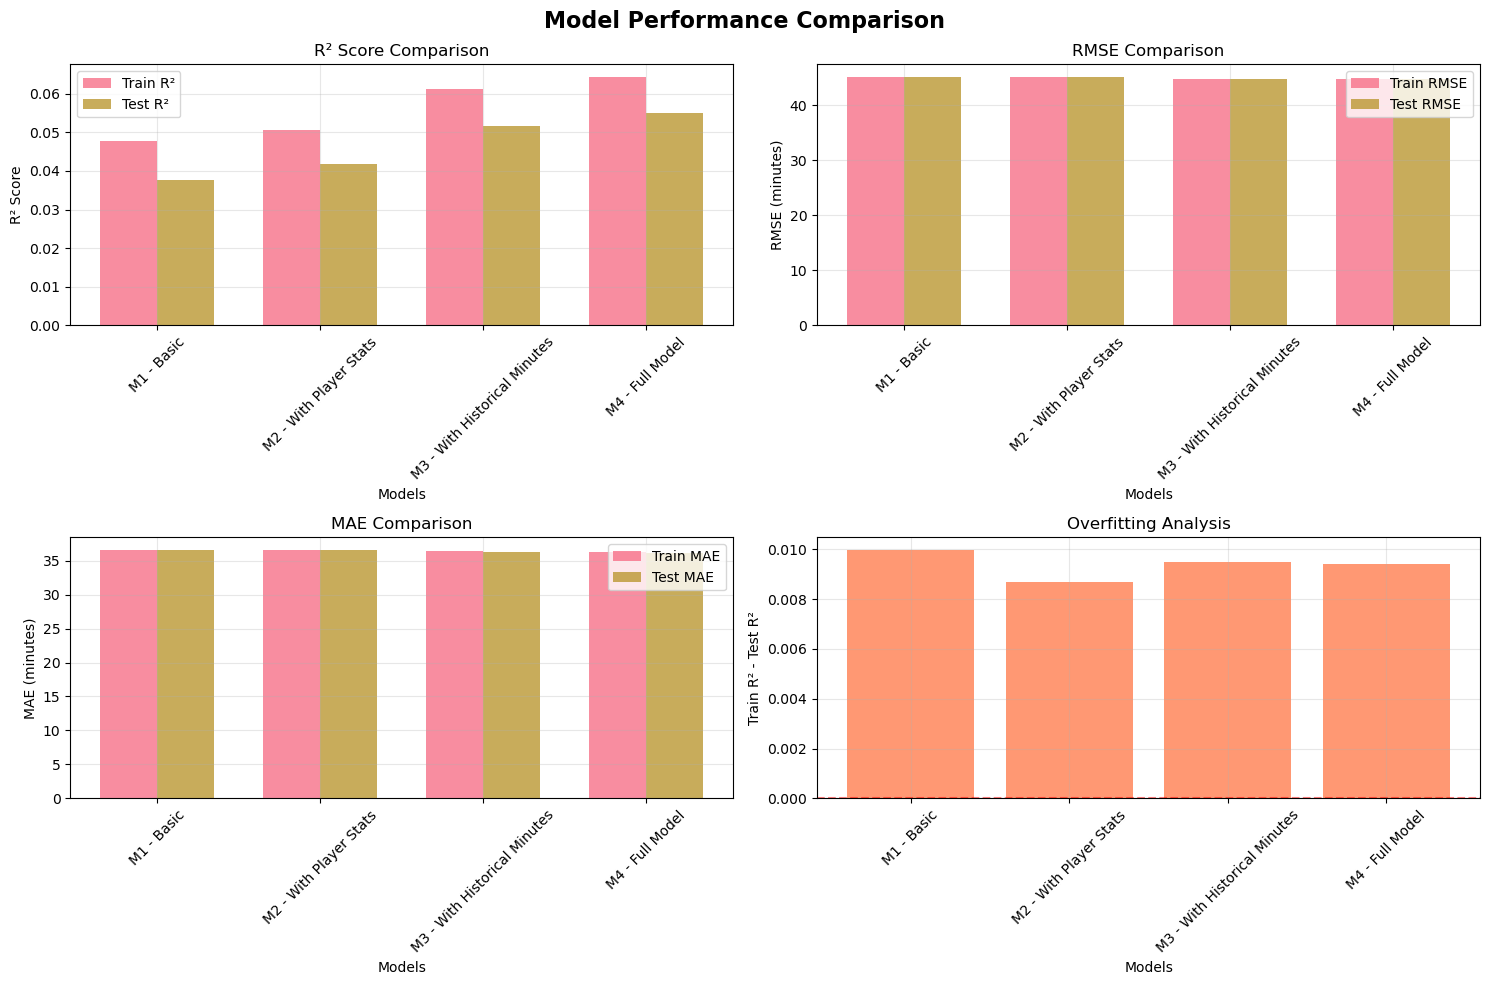


BEST MODEL SUMMARY
Model: Model 4 - Full Model
Test R²: 0.0550
Test RMSE: 44.80 minutes
Test MAE: 36.19 minutes
Number of features: 14

Features used:
 1. age_diff
 2. round_group_QF
 3. round_group_SF
 4. round_group_Other
 5. surface_Grass
 6. surface_Hard
 7. winner_rank_points
 8. loser_rank_points
 9. w_avg_ace
10. w_avg_df
11. w_avg_minutes
12. l_avg_ace
13. l_avg_df
14. l_avg_minutes

DETAILED ANALYSIS FOR ALL MODELS

Generating detailed analysis for: Model 1 - Basic


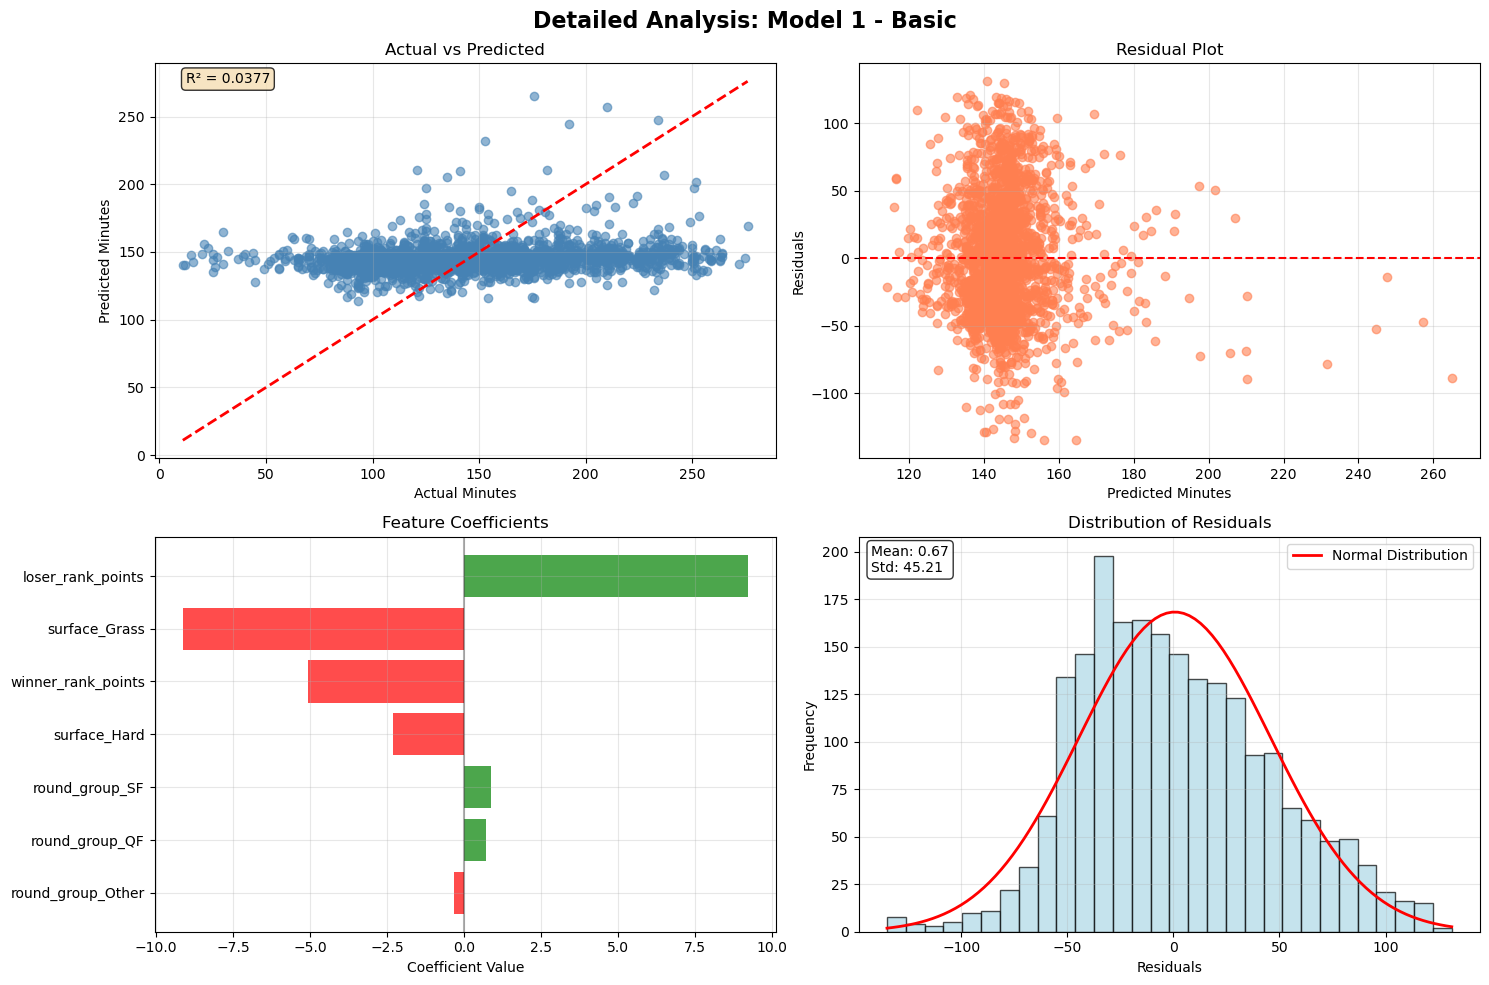


📊 Model 1 - Basic Summary:
   • Test R²: 0.0377
   • Test RMSE: 45.21 minutes
   • Test MAE: 36.59 minutes
   • Number of features: 7
   • Top 3 most influential features:
     1. loser_rank_points: increases match duration by 9.22 min per unit
     2. surface_Grass: decreases match duration by 9.13 min per unit
     3. winner_rank_points: decreases match duration by 5.07 min per unit
--------------------------------------------------

Generating detailed analysis for: Model 2 - With Player Stats


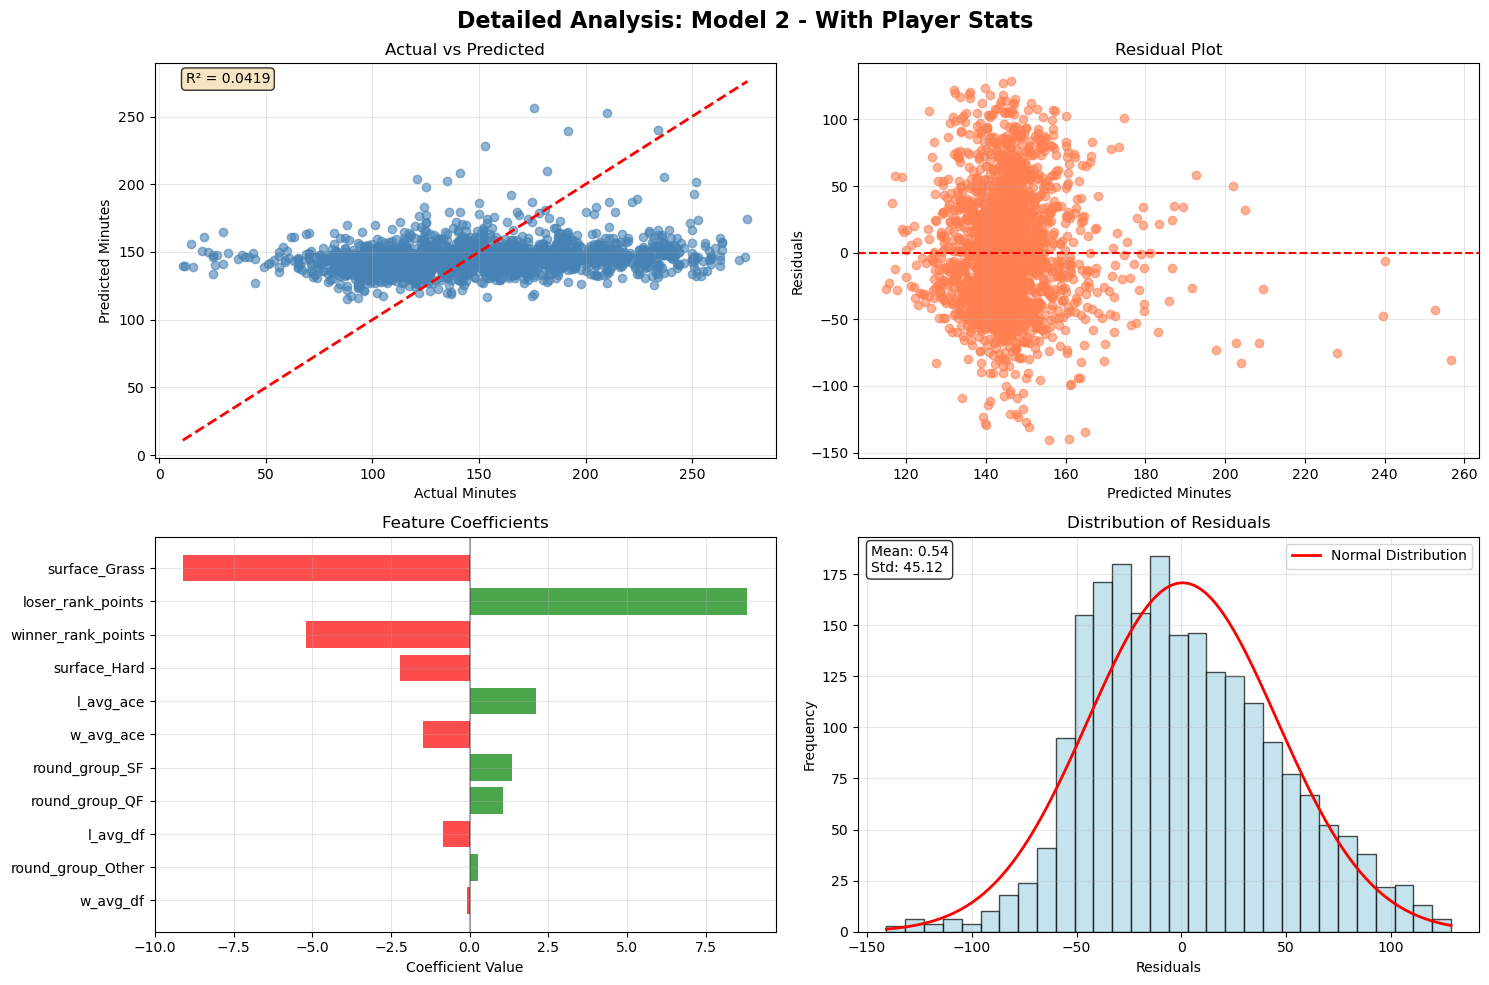


📊 Model 2 - With Player Stats Summary:
   • Test R²: 0.0419
   • Test RMSE: 45.11 minutes
   • Test MAE: 36.53 minutes
   • Number of features: 11
   • Top 3 most influential features:
     1. surface_Grass: decreases match duration by 9.12 min per unit
     2. loser_rank_points: increases match duration by 8.83 min per unit
     3. winner_rank_points: decreases match duration by 5.20 min per unit
--------------------------------------------------

Generating detailed analysis for: Model 3 - With Historical Minutes


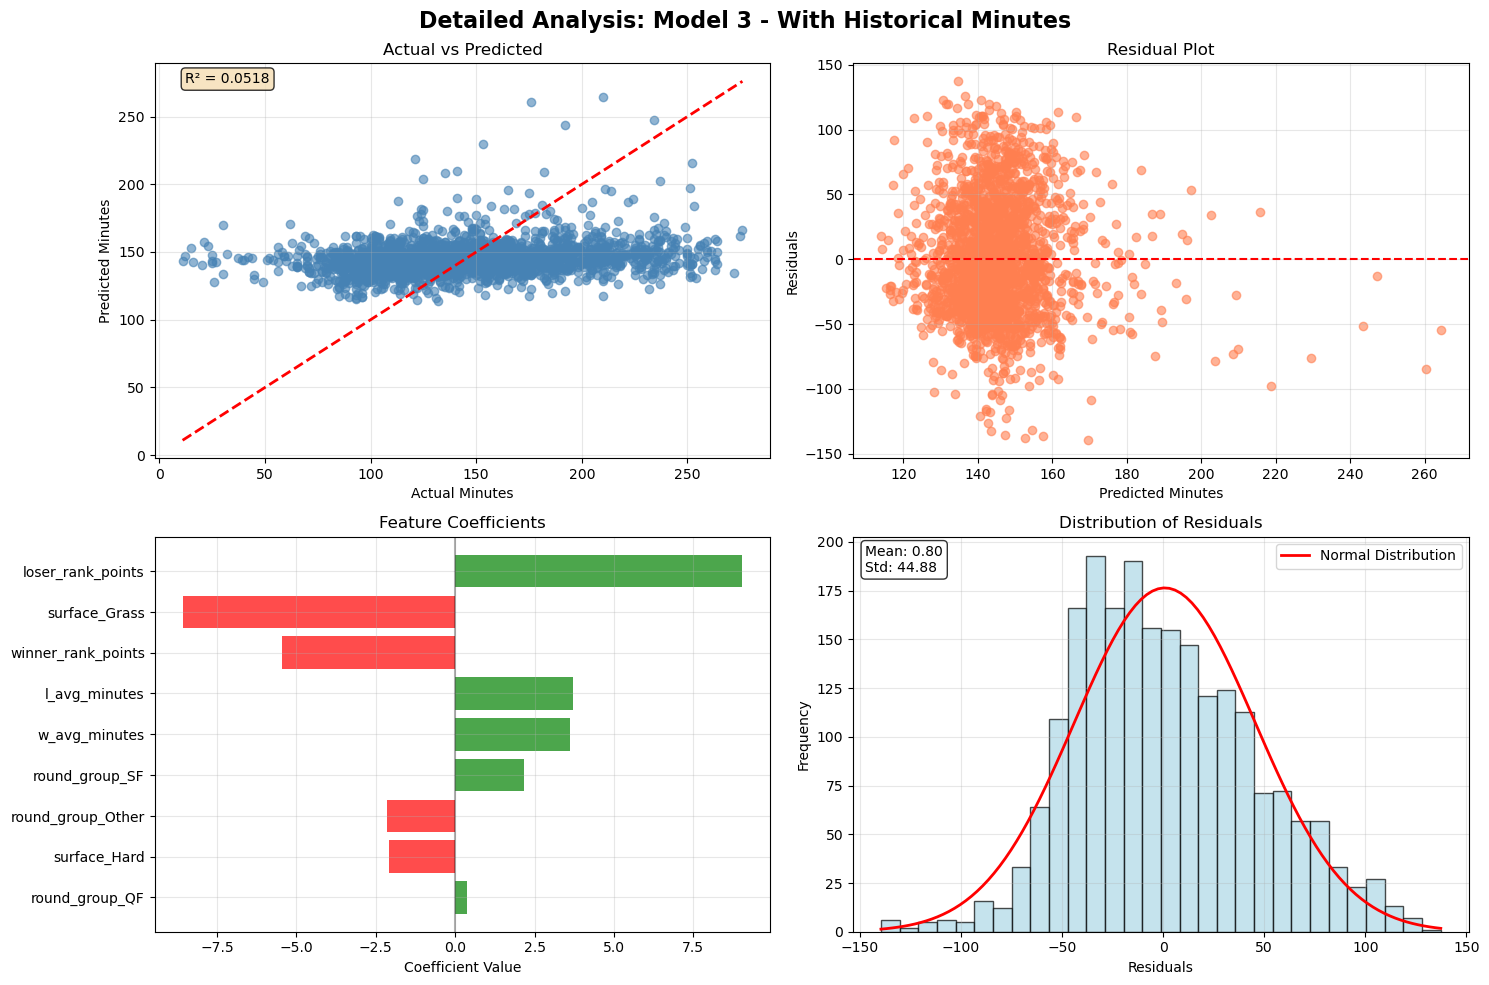


📊 Model 3 - With Historical Minutes Summary:
   • Test R²: 0.0518
   • Test RMSE: 44.88 minutes
   • Test MAE: 36.25 minutes
   • Number of features: 9
   • Top 3 most influential features:
     1. loser_rank_points: increases match duration by 9.05 min per unit
     2. surface_Grass: decreases match duration by 8.59 min per unit
     3. winner_rank_points: decreases match duration by 5.46 min per unit
--------------------------------------------------

Generating detailed analysis for: Model 4 - Full Model


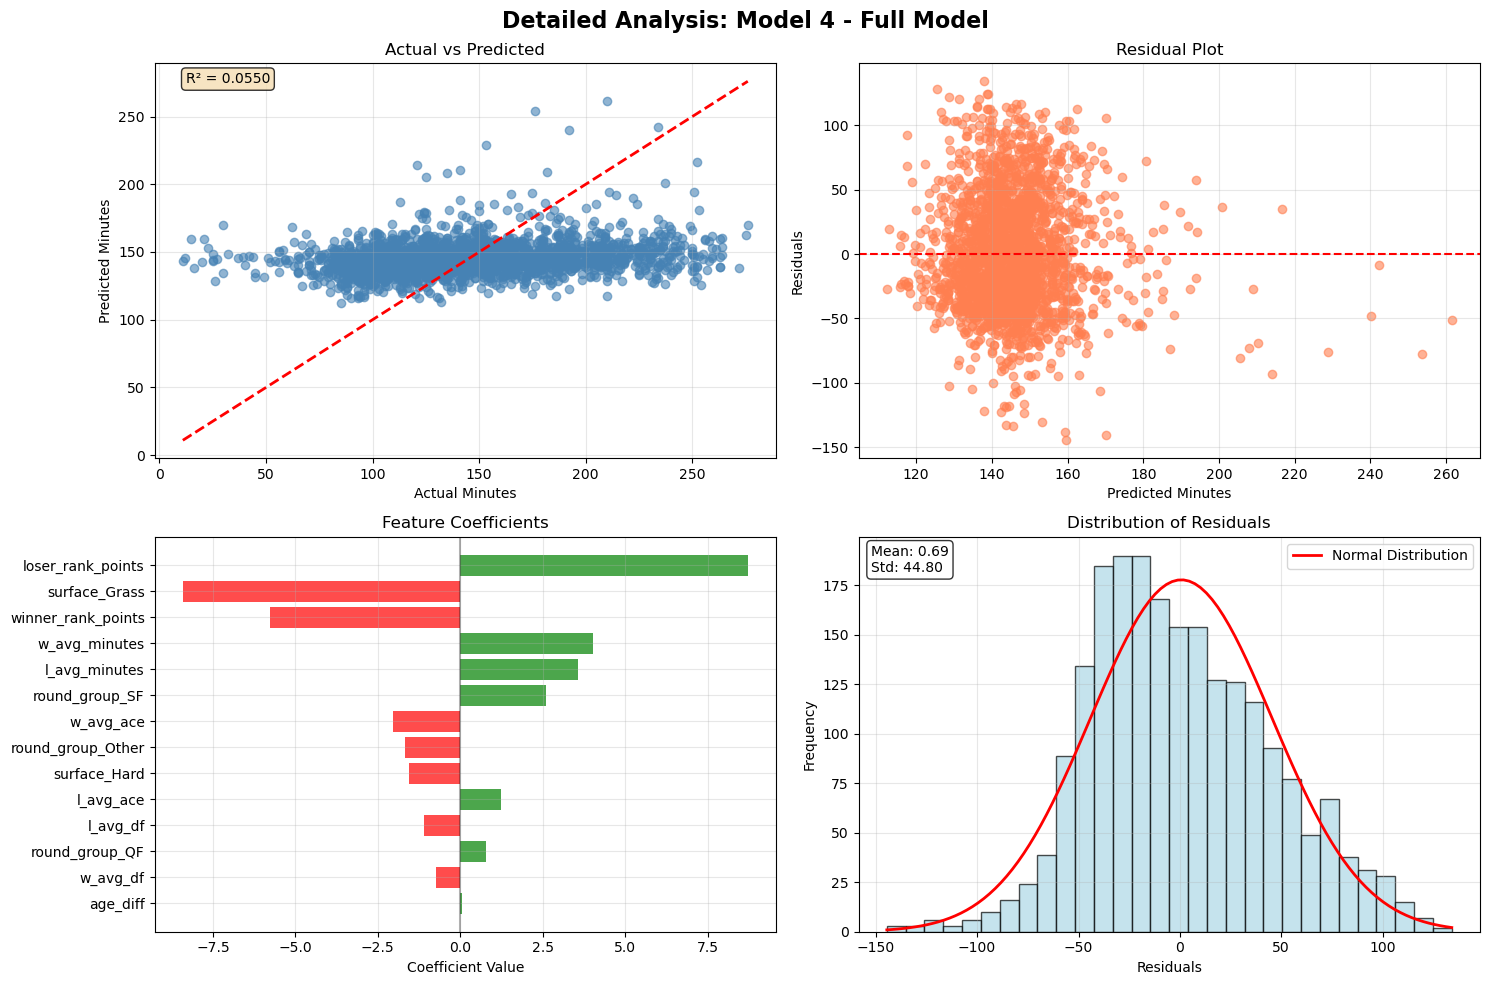


📊 Model 4 - Full Model Summary:
   • Test R²: 0.0550
   • Test RMSE: 44.80 minutes
   • Test MAE: 36.19 minutes
   • Number of features: 14
   • Top 3 most influential features:
     1. loser_rank_points: increases match duration by 8.72 min per unit
     2. surface_Grass: decreases match duration by 8.41 min per unit
     3. winner_rank_points: decreases match duration by 5.77 min per unit
--------------------------------------------------


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Assuming df_clean is your DataFrame
# df_clean = your_dataframe_here

def create_regression_models(df):
    """
    Create and compare multiple linear regression models
    """
    
    # Define different feature sets
    models = {
        'Model 1 - Basic': ['round_group_QF', 'round_group_SF', 'round_group_Other', 
                           'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points'],
        
        'Model 2 - With Player Stats': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                       'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                       'loser_rank_points', 'w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'],
        
        'Model 3 - With Historical Minutes': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                            'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                            'loser_rank_points', 'w_avg_minutes', 'l_avg_minutes'],
        
        'Model 4 - Full Model': ['age_diff', 'round_group_QF', 'round_group_SF', 'round_group_Other',
                                'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points',
                                'w_avg_ace', 'w_avg_df', 'w_avg_minutes', 'l_avg_ace', 'l_avg_df', 'l_avg_minutes']
    }
    
    # Target variable
    y = df['minutes']
    
    # Store results
    results = {}
    trained_models = {}
    test_data = {}  # Store test data for each model
    
    # Split data once for consistent comparison using the basic model features
    X_basic = df[models['Model 1 - Basic']]
    _, _, _, y_test = train_test_split(X_basic, y, test_size=0.2, random_state=42)
    
    print("=== LINEAR REGRESSION MODELS COMPARISON ===\n")
    
    for model_name, features in models.items():
        print(f"\n--- {model_name} ---")
        print(f"Features: {len(features)}")
        
        # Prepare data for this specific model
        X = df[features]
        X_train, X_test, y_train_model, y_test_model = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Store test data for later use
        test_data[model_name] = {'X_test': X_test, 'y_test': y_test_model}
        
        # Create and train model
        model = LinearRegression()
        model.fit(X_train, y_train_model)
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Metrics
        train_r2 = r2_score(y_train_model, y_pred_train)
        test_r2 = r2_score(y_test_model, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train_model, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test_model, y_pred_test))
        train_mae = mean_absolute_error(y_train_model, y_pred_train)
        test_mae = mean_absolute_error(y_test_model, y_pred_test)
        
        # Store results
        results[model_name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'features': features,
            'coefficients': model.coef_,
            'intercept': model.intercept_
        }
        
        trained_models[model_name] = model
        
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")
        print(f"Train RMSE: {train_rmse:.2f}")
        print(f"Test RMSE: {test_rmse:.2f}")
        print(f"Train MAE: {train_mae:.2f}")
        print(f"Test MAE: {test_mae:.2f}")
    
    return results, trained_models, test_data

def plot_model_comparison(results):
    """
    Create comparison plots for all models
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    models = list(results.keys())
    
    # R² comparison
    train_r2 = [results[model]['train_r2'] for model in models]
    test_r2 = [results[model]['test_r2'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    axes[0,0].bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8)
    axes[0,0].bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8)
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('R² Score Comparison')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([m.replace('Model ', 'M') for m in models], rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    train_rmse = [results[model]['train_rmse'] for model in models]
    test_rmse = [results[model]['test_rmse'] for model in models]
    
    axes[0,1].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8)
    axes[0,1].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('RMSE (minutes)')
    axes[0,1].set_title('RMSE Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([m.replace('Model ', 'M') for m in models], rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # MAE comparison
    train_mae = [results[model]['train_mae'] for model in models]
    test_mae = [results[model]['test_mae'] for model in models]
    
    axes[1,0].bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8)
    axes[1,0].bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8)
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('MAE (minutes)')
    axes[1,0].set_title('MAE Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels([m.replace('Model ', 'M') for m in models], rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Overfitting analysis (Train R² - Test R²)
    overfitting = [results[model]['train_r2'] - results[model]['test_r2'] for model in models]
    
    axes[1,1].bar(models, overfitting, alpha=0.8, color='coral')
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Train R² - Test R²')
    axes[1,1].set_title('Overfitting Analysis')
    axes[1,1].set_xticklabels([m.replace('Model ', 'M') for m in models], rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def plot_detailed_model_analysis(model_name, results, trained_models, test_data, df):
    """
    Detailed analysis of a specific model
    """
    
    model = trained_models[model_name]
    features = results[model_name]['features']
    
    # Get the correct test data for this model
    X_test = test_data[model_name]['X_test']
    y_test = test_data[model_name]['y_test']
    
    # Predictions
    y_pred = model.predict(X_test)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Detailed Analysis: {model_name}', fontsize=16, fontweight='bold')
    
    # Actual vs Predicted
    axes[0,0].scatter(y_test, y_pred, alpha=0.6, color='steelblue')
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Minutes')
    axes[0,0].set_ylabel('Predicted Minutes')
    axes[0,0].set_title('Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add R² to the plot
    r2 = r2_score(y_test, y_pred)
    axes[0,0].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0,0].transAxes, 
                   bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # Residuals
    residuals = y_test - y_pred
    axes[0,1].scatter(y_pred, residuals, alpha=0.6, color='coral')
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Predicted Minutes')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residual Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    # Feature importance (coefficients)
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=True)
    
    # Color bars based on positive/negative coefficients
    colors = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
    axes[1,0].barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.7)
    axes[1,0].set_xlabel('Coefficient Value')
    axes[1,0].set_title('Feature Coefficients')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Distribution of residuals
    axes[1,1].hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='lightblue')
    axes[1,1].set_xlabel('Residuals')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Residuals')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add normal distribution overlay
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    axes[1,1].plot(x, len(residuals) * (residuals.max() - residuals.min()) / 30 * 
                   (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2),
                   'r-', linewidth=2, label='Normal Distribution')
    axes[1,1].legend()
    
    # Add residual statistics
    axes[1,1].text(0.02, 0.98, f'Mean: {mu:.2f}\nStd: {sigma:.2f}', 
                   transform=axes[1,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_all_models_detailed_analysis(results, trained_models, test_data, df):
    """
    Show detailed analysis for all models
    """
    print("\n" + "="*60)
    print("DETAILED ANALYSIS FOR ALL MODELS")
    print("="*60)
    
    for model_name in results.keys():
        print(f"\nGenerating detailed analysis for: {model_name}")
        plot_detailed_model_analysis(model_name, results, trained_models, test_data, df)
        
        # Print model summary
        model_results = results[model_name]
        print(f"\n📊 {model_name} Summary:")
        print(f"   • Test R²: {model_results['test_r2']:.4f}")
        print(f"   • Test RMSE: {model_results['test_rmse']:.2f} minutes")
        print(f"   • Test MAE: {model_results['test_mae']:.2f} minutes")
        print(f"   • Number of features: {len(model_results['features'])}")
        
        # Show top 3 most important features (by absolute coefficient value)
        coef_df = pd.DataFrame({
            'Feature': model_results['features'],
            'Coefficient': model_results['coefficients']
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        print(f"   • Top 3 most influential features:")
        for i, (_, row) in enumerate(coef_df.head(3).iterrows(), 1):
            direction = "increases" if row['Coefficient'] > 0 else "decreases"
            print(f"     {i}. {row['Feature']}: {direction} match duration by {abs(row['Coefficient']):.2f} min per unit")
        
        print("-" * 50)

def print_best_model_summary(results):
    """
    Print summary of the best model
    """
    
    # Find best model based on test R²
    best_model = max(results.items(), key=lambda x: x[1]['test_r2'])
    best_name, best_metrics = best_model
    
    print("\n" + "="*50)
    print("BEST MODEL SUMMARY")
    print("="*50)
    print(f"Model: {best_name}")
    print(f"Test R²: {best_metrics['test_r2']:.4f}")
    print(f"Test RMSE: {best_metrics['test_rmse']:.2f} minutes")
    print(f"Test MAE: {best_metrics['test_mae']:.2f} minutes")
    print(f"Number of features: {len(best_metrics['features'])}")
    
    print(f"\nFeatures used:")
    for i, feature in enumerate(best_metrics['features'], 1):
        print(f"{i:2d}. {feature}")
    
    return best_name

def run_complete_analysis(df):
    """
    Run the complete regression analysis
    """
    
    print("Starting Tennis Match Duration Analysis...")
    print(f"Dataset shape: {df.shape}")
    print(f"Target variable (minutes) - Mean: {df['minutes'].mean():.2f}, Std: {df['minutes'].std():.2f}")
    
    # Run all models
    results, trained_models, test_data = create_regression_models(df)
    
    # Plot comparison
    plot_model_comparison(results)
    
    # Find and print best model summary
    best_model_name = print_best_model_summary(results)
    
    # Detailed analysis of ALL models
    plot_all_models_detailed_analysis(results, trained_models, test_data, df)
    
    return results, trained_models

def run_analysis_single_model(df, model_name=None):
    """
    Run analysis for a single specific model
    """
    
    # Run all models first
    results, trained_models, test_data = create_regression_models(df)
    
    if model_name is None:
        # Show available models
        print("Available models:")
        for i, name in enumerate(results.keys(), 1):
            print(f"{i}. {name}")
        return results, trained_models
    
    if model_name in results:
        print(f"\n=== DETAILED ANALYSIS FOR {model_name} ===")
        plot_detailed_model_analysis(model_name, results, trained_models, test_data, df)
        
        # Print detailed coefficient analysis
        model_results = results[model_name]
        print(f"\n📊 Detailed Coefficient Analysis for {model_name}:")
        print("-" * 60)
        
        coef_df = pd.DataFrame({
            'Feature': model_results['features'],
            'Coefficient': model_results['coefficients']
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        for _, row in coef_df.iterrows():
            direction = "increases" if row['Coefficient'] > 0 else "decreases"
            print(f"• {row['Feature']:<25}: {direction} duration by {abs(row['Coefficient']):6.2f} minutes per unit")
        
    else:
        print(f"Model '{model_name}' not found. Available models: {list(results.keys())}")
    
    return results, trained_models

# Example usage:
# Uncomment the following lines and replace 'df_clean' with your actual DataFrame

# OPTION 1: Complete analysis with ALL models detailed analysis
display(df_clean)
results, models = run_complete_analysis(df_clean)

# OPTION 2: Analysis for a specific model only
# results, models = run_analysis_single_model(df_clean, 'Model 4 - Full Model')

# OPTION 3: See available models and choose one
# results, models = run_analysis_single_model(df_clean)

# print("Code is ready! Choose one of these options:")
# print("\n🔍 OPTION 1 - Complete Analysis (ALL models with detailed plots):")
# print("results, models = run_complete_analysis(df_clean)")

# print("\n🎯 OPTION 2 - Single Model Analysis:")
# print("results, models = run_analysis_single_model(df_clean, 'Model 1 - Basic')")

# print("\n📋 OPTION 3 - List available models:")
# print("results, models = run_analysis_single_model(df_clean)")

# print("\n💡 Available model names:")
# print("• 'Model 1 - Basic'")
# print("• 'Model 2 - With Player Stats'") 
# print("• 'Model 3 - With Historical Minutes'")
# print("• 'Model 4 - Full Model'")

# XG Boost Normalizado

🚀 XGBoost Analysis Code is ready! Choose one of these options:

🔍 OPTION 1 - Complete XGBoost Analysis (ALL models with detailed plots):
xgb_results, xgb_models = run_complete_xgboost_analysis(df_clean)

🎯 OPTION 2 - Single XGBoost Model Analysis:
xgb_results, xgb_models = run_xgboost_analysis_single_model(df_clean, 'XGB Model 4 - Full Model')

📋 OPTION 3 - List available XGBoost models:
xgb_results, xgb_models = run_xgboost_analysis_single_model(df_clean)

🆚 OPTION 4 - Compare Linear Regression vs XGBoost:
# First run both analyses, then:
compare_linear_vs_xgboost(df_clean, linear_results, xgb_results)

💡 Available XGBoost model names:
• 'XGB Model 1 - Basic'
• 'XGB Model 2 - With Player Stats'
• 'XGB Model 3 - With Historical Minutes'
• 'XGB Model 4 - Full Model'
Starting Tennis Match Duration XGBoost Analysis...
Dataset shape: (10746, 18)
Target variable (minutes) - Mean: 145.48, Std: 46.28
=== XGBOOST REGRESSION MODELS COMPARISON ===


--- XGB Model 1 - Basic ---
Features: 7
Train 

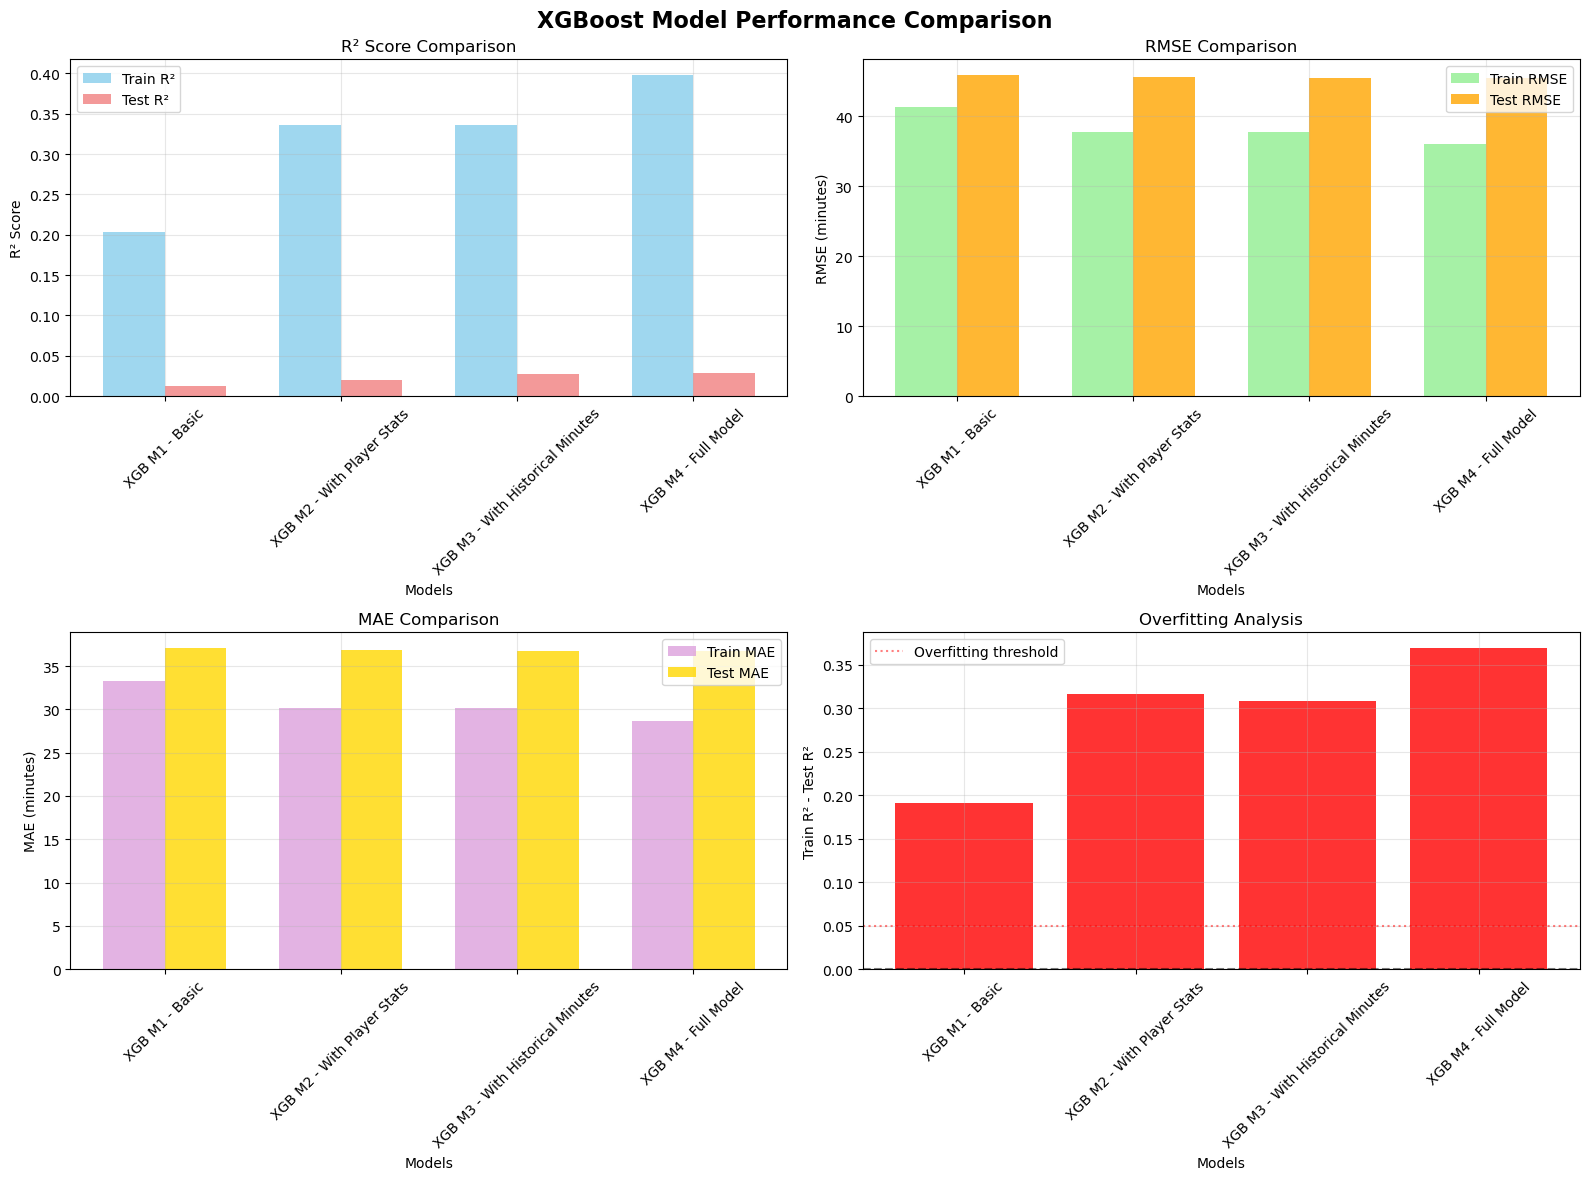


BEST XGBOOST MODEL SUMMARY
Model: XGB Model 4 - Full Model
Test R²: 0.0289
Test RMSE: 45.41 minutes
Test MAE: 36.71 minutes
Number of features: 14

Top 5 Most Important Features:
 1. loser_rank_points        : 0.1203
 2. w_avg_minutes            : 0.0889
 3. winner_rank_points       : 0.0879
 4. l_avg_minutes            : 0.0814
 5. l_avg_df                 : 0.0779

DETAILED XGBOOST ANALYSIS FOR ALL MODELS

Generating detailed analysis for: XGB Model 1 - Basic


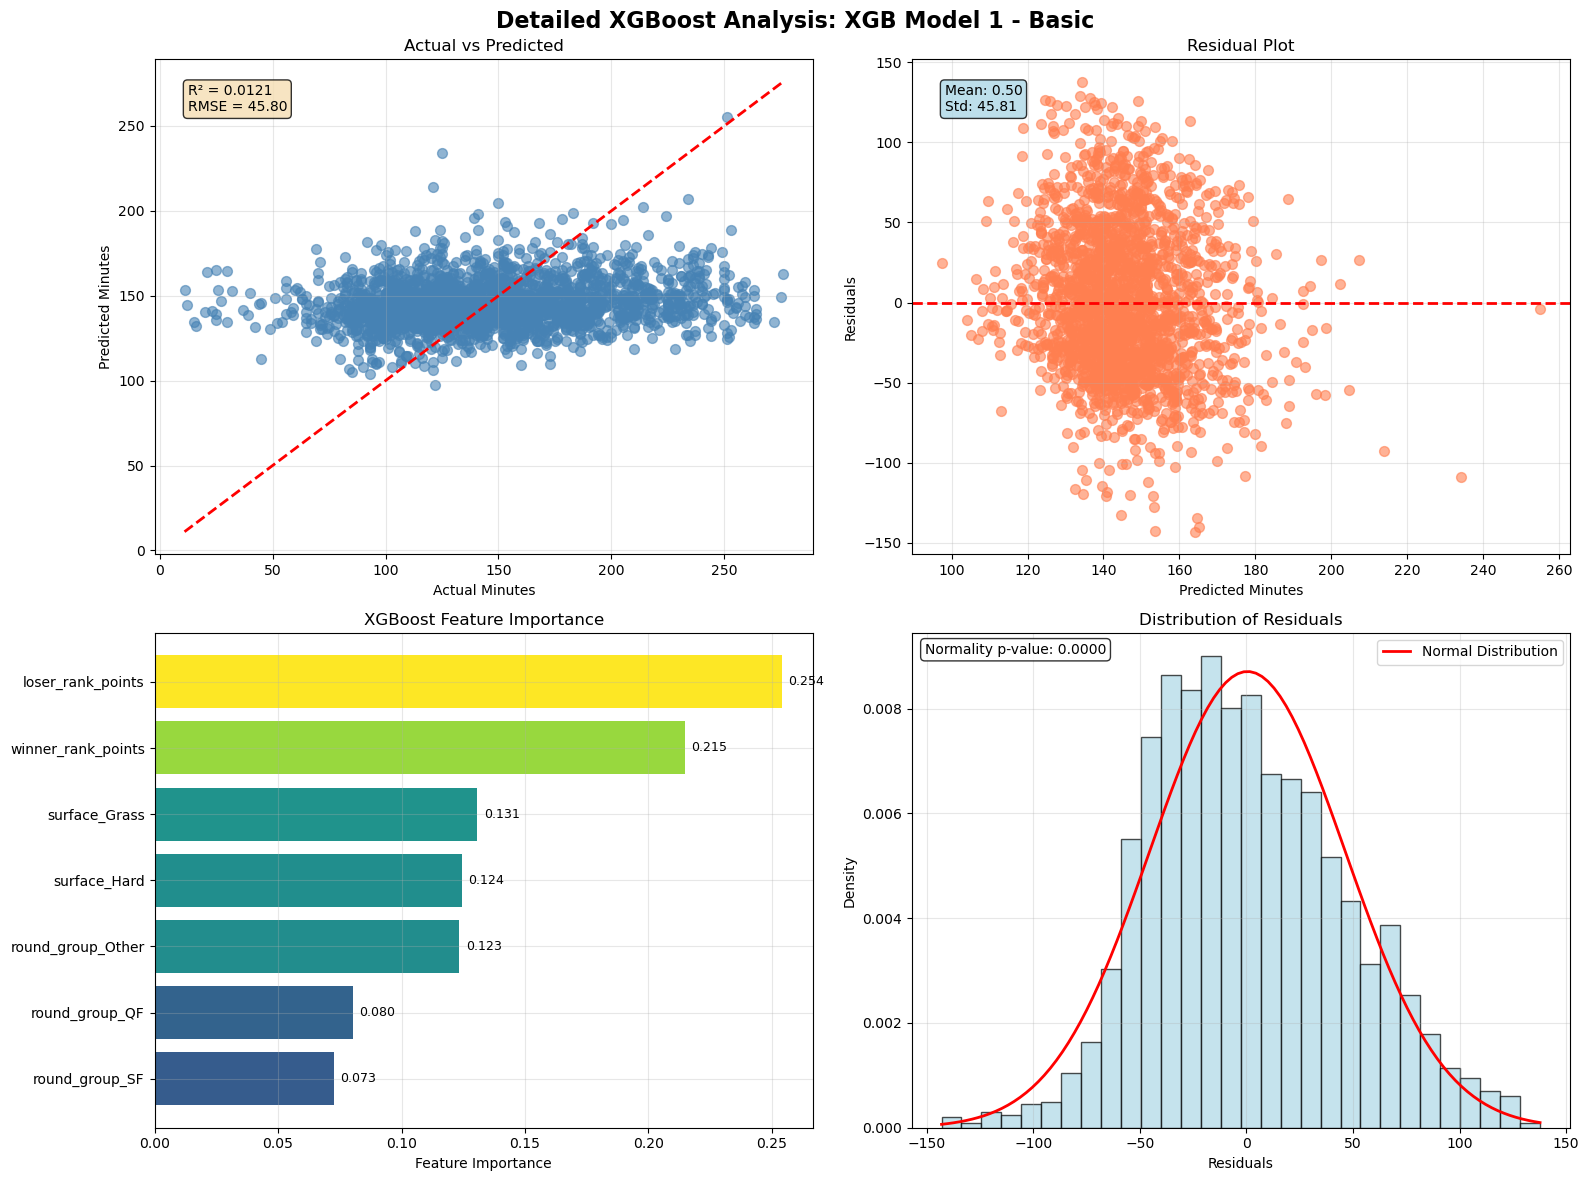


🚀 XGB Model 1 - Basic Summary:
   • Test R²: 0.0121
   • Test RMSE: 45.80 minutes
   • Test MAE: 37.05 minutes
   • Number of features: 7
   • Top 3 most important features:
     1. loser_rank_points: 0.2539 importance score
     2. winner_rank_points: 0.2147 importance score
     3. surface_Grass: 0.1307 importance score
   ⚠️  High overfitting detected: 0.1914
------------------------------------------------------------

Generating detailed analysis for: XGB Model 2 - With Player Stats


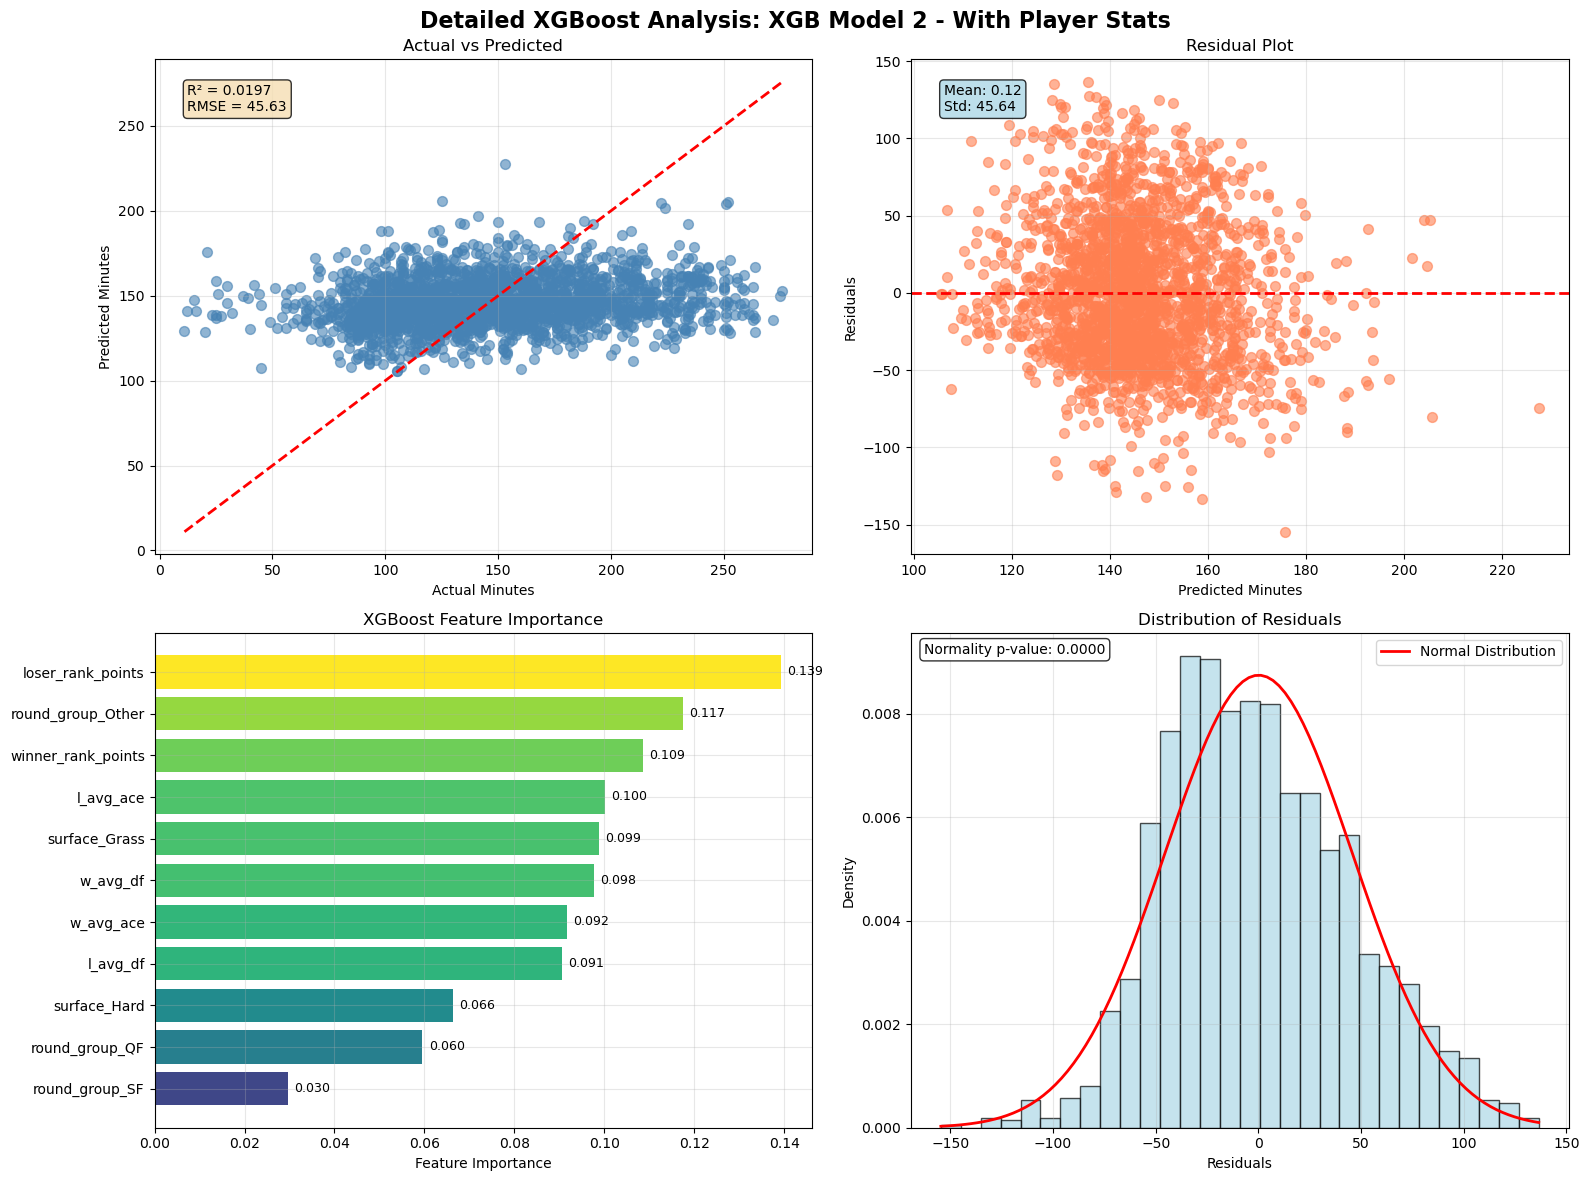


🚀 XGB Model 2 - With Player Stats Summary:
   • Test R²: 0.0197
   • Test RMSE: 45.63 minutes
   • Test MAE: 36.86 minutes
   • Number of features: 11
   • Top 3 most important features:
     1. loser_rank_points: 0.1393 importance score
     2. round_group_Other: 0.1175 importance score
     3. winner_rank_points: 0.1087 importance score
   ⚠️  High overfitting detected: 0.3164
------------------------------------------------------------

Generating detailed analysis for: XGB Model 3 - With Historical Minutes


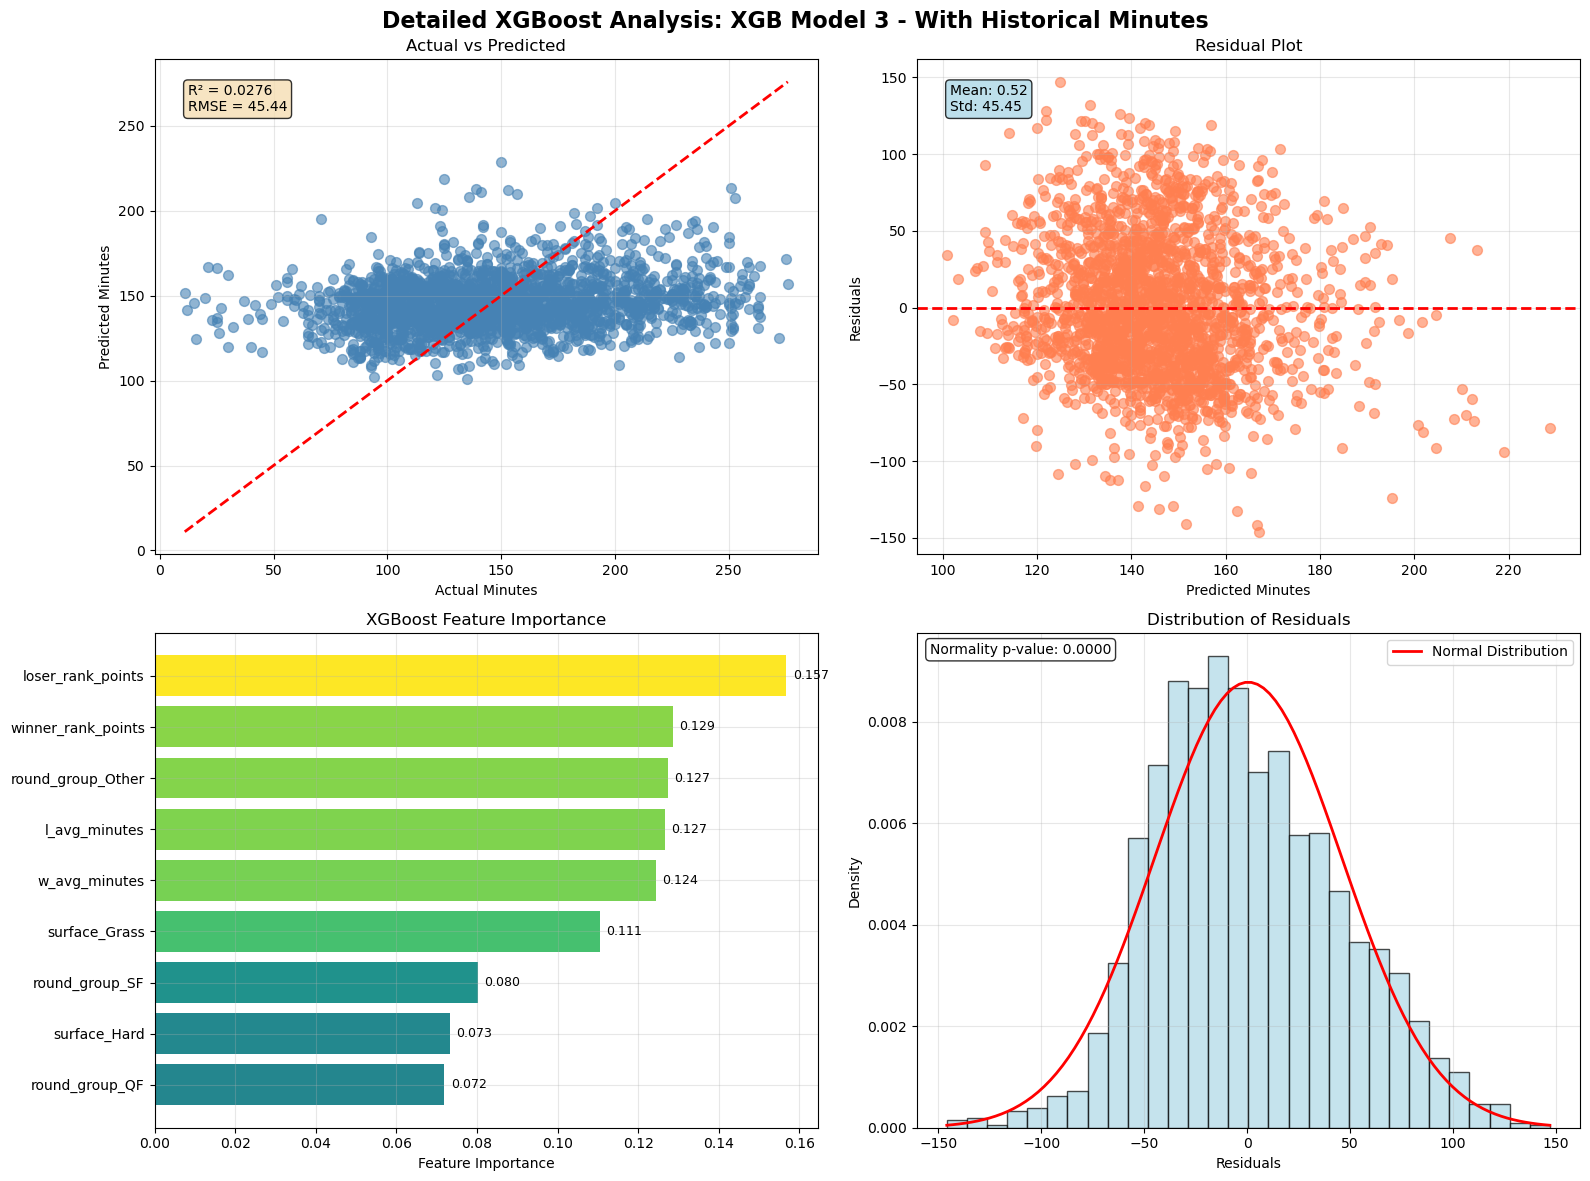


🚀 XGB Model 3 - With Historical Minutes Summary:
   • Test R²: 0.0276
   • Test RMSE: 45.44 minutes
   • Test MAE: 36.73 minutes
   • Number of features: 9
   • Top 3 most important features:
     1. loser_rank_points: 0.1568 importance score
     2. winner_rank_points: 0.1287 importance score
     3. round_group_Other: 0.1275 importance score
   ⚠️  High overfitting detected: 0.3087
------------------------------------------------------------

Generating detailed analysis for: XGB Model 4 - Full Model


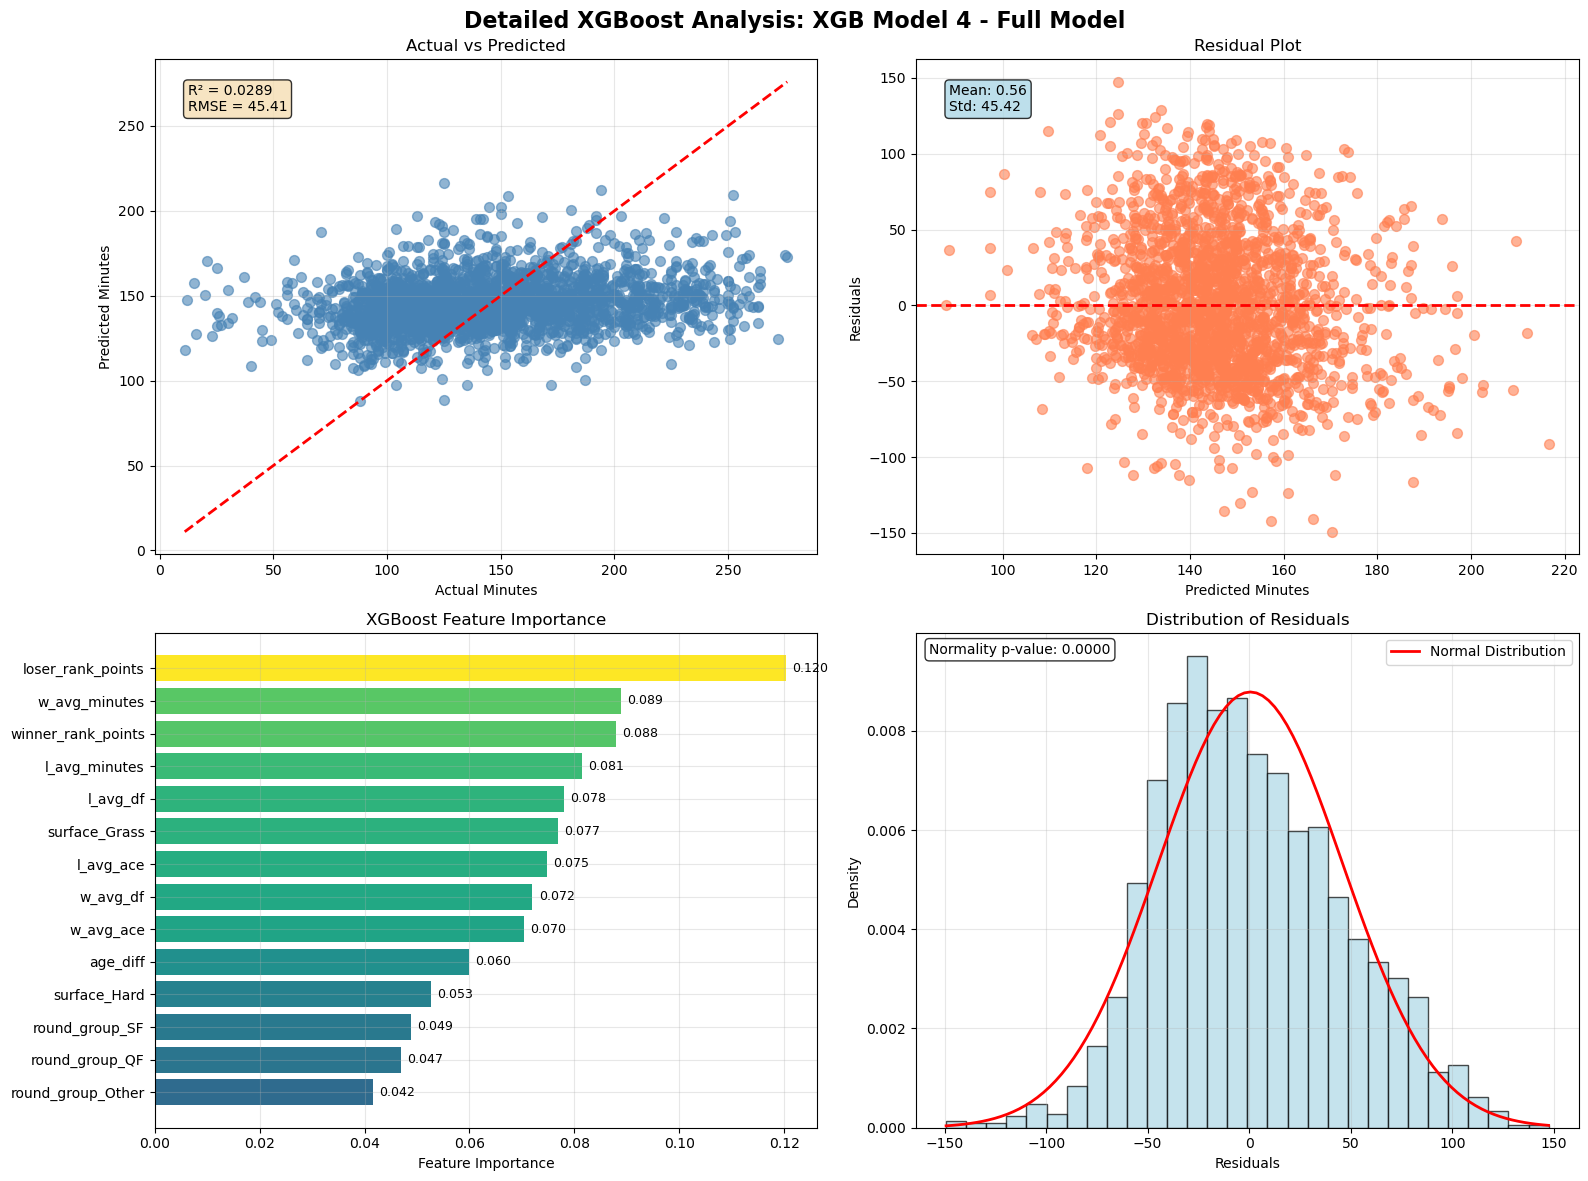


🚀 XGB Model 4 - Full Model Summary:
   • Test R²: 0.0289
   • Test RMSE: 45.41 minutes
   • Test MAE: 36.71 minutes
   • Number of features: 14
   • Top 3 most important features:
     1. loser_rank_points: 0.1203 importance score
     2. w_avg_minutes: 0.0889 importance score
     3. winner_rank_points: 0.0879 importance score
   ⚠️  High overfitting detected: 0.3688
------------------------------------------------------------


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def create_xgboost_models(df):
    """
    Create and compare multiple XGBoost regression models
    """
    
    # Define different feature sets
    models = {
        'XGB Model 1 - Basic': ['round_group_QF', 'round_group_SF', 'round_group_Other', 
                                'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points'],
        
        'XGB Model 2 - With Player Stats': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                           'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                           'loser_rank_points', 'w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'],
        
        'XGB Model 3 - With Historical Minutes': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                                 'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                                 'loser_rank_points', 'w_avg_minutes', 'l_avg_minutes'],
        
        'XGB Model 4 - Full Model': ['age_diff', 'round_group_QF', 'round_group_SF', 'round_group_Other',
                                     'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points',
                                     'w_avg_ace', 'w_avg_df', 'w_avg_minutes', 'l_avg_ace', 'l_avg_df', 'l_avg_minutes']
    }
    
    # Target variable
    y = df['minutes']
    
    # Store results
    results = {}
    trained_models = {}
    test_data = {}  # Store test data for each model
    
    print("=== XGBOOST REGRESSION MODELS COMPARISON ===\n")
    
    for model_name, features in models.items():
        print(f"\n--- {model_name} ---")
        print(f"Features: {len(features)}")
        
        # Prepare data for this specific model
        X = df[features]
        X_train, X_test, y_train_model, y_test_model = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Store test data for later use
        test_data[model_name] = {'X_test': X_test, 'y_test': y_test_model}
        
        # Create and train XGBoost model
        model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(X_train, y_train_model)
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Metrics
        train_r2 = r2_score(y_train_model, y_pred_train)
        test_r2 = r2_score(y_test_model, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train_model, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test_model, y_pred_test))
        train_mae = mean_absolute_error(y_train_model, y_pred_train)
        test_mae = mean_absolute_error(y_test_model, y_pred_test)
        
        # Get feature importance
        feature_importance = model.feature_importances_
        
        # Store results
        results[model_name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'features': features,
            'feature_importance': feature_importance
        }
        
        trained_models[model_name] = model
        
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")
        print(f"Train RMSE: {train_rmse:.2f}")
        print(f"Test RMSE: {test_rmse:.2f}")
        print(f"Train MAE: {train_mae:.2f}")
        print(f"Test MAE: {test_mae:.2f}")
    
    return results, trained_models, test_data

def plot_xgboost_model_comparison(results):
    """
    Create comparison plots for all XGBoost models
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('XGBoost Model Performance Comparison', fontsize=16, fontweight='bold')
    
    models = list(results.keys())
    
    # R² comparison
    train_r2 = [results[model]['train_r2'] for model in models]
    test_r2 = [results[model]['test_r2'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    axes[0,0].bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8, color='skyblue')
    axes[0,0].bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8, color='lightcoral')
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('R² Score Comparison')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([m.replace('XGB Model ', 'XGB M') for m in models], rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    train_rmse = [results[model]['train_rmse'] for model in models]
    test_rmse = [results[model]['test_rmse'] for model in models]
    
    axes[0,1].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8, color='lightgreen')
    axes[0,1].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8, color='orange')
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('RMSE (minutes)')
    axes[0,1].set_title('RMSE Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([m.replace('XGB Model ', 'XGB M') for m in models], rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # MAE comparison
    train_mae = [results[model]['train_mae'] for model in models]
    test_mae = [results[model]['test_mae'] for model in models]
    
    axes[1,0].bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8, color='plum')
    axes[1,0].bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8, color='gold')
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('MAE (minutes)')
    axes[1,0].set_title('MAE Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels([m.replace('XGB Model ', 'XGB M') for m in models], rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Overfitting analysis (Train R² - Test R²)
    overfitting = [results[model]['train_r2'] - results[model]['test_r2'] for model in models]
    
    colors = ['red' if x > 0.05 else 'green' if x < 0 else 'orange' for x in overfitting]
    axes[1,1].bar(range(len(models)), overfitting, alpha=0.8, color=colors)
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Train R² - Test R²')
    axes[1,1].set_title('Overfitting Analysis')
    axes[1,1].set_xticks(range(len(models)))
    axes[1,1].set_xticklabels([m.replace('XGB Model ', 'XGB M') for m in models], rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1,1].axhline(y=0.05, color='red', linestyle=':', alpha=0.5, label='Overfitting threshold')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

def plot_detailed_xgboost_analysis(model_name, results, trained_models, test_data, df):
    """
    Detailed analysis of a specific XGBoost model
    """
    
    model = trained_models[model_name]
    features = results[model_name]['features']
    
    # Get the correct test data for this model
    X_test = test_data[model_name]['X_test']
    y_test = test_data[model_name]['y_test']
    
    # Predictions
    y_pred = model.predict(X_test)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Detailed XGBoost Analysis: {model_name}', fontsize=16, fontweight='bold')
    
    # Actual vs Predicted
    axes[0,0].scatter(y_test, y_pred, alpha=0.6, color='steelblue', s=50)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Minutes')
    axes[0,0].set_ylabel('Predicted Minutes')
    axes[0,0].set_title('Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add R² and RMSE to the plot
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    axes[0,0].text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.2f}', 
                   transform=axes[0,0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # Residuals
    residuals = y_test - y_pred
    axes[0,1].scatter(y_pred, residuals, alpha=0.6, color='coral', s=50)
    axes[0,1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Predicted Minutes')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residual Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add residual statistics
    res_mean, res_std = residuals.mean(), residuals.std()
    axes[0,1].text(0.05, 0.95, f'Mean: {res_mean:.2f}\nStd: {res_std:.2f}', 
                   transform=axes[0,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
    
    # Feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': results[model_name]['feature_importance']
    }).sort_values('Importance', ascending=True)
    
    # Color bars based on importance level
    colors = plt.cm.viridis(importance_df['Importance'] / importance_df['Importance'].max())
    bars = axes[1,0].barh(importance_df['Feature'], importance_df['Importance'], color=colors)
    axes[1,0].set_xlabel('Feature Importance')
    axes[1,0].set_title('XGBoost Feature Importance')
    axes[1,0].grid(True, alpha=0.3)
    
    # Add importance values on bars
    for i, (bar, importance) in enumerate(zip(bars, importance_df['Importance'])):
        axes[1,0].text(importance + importance_df['Importance'].max() * 0.01, 
                      bar.get_y() + bar.get_height()/2, 
                      f'{importance:.3f}', 
                      va='center', fontsize=9)
    
    # Distribution of residuals with improved visualization
    axes[1,1].hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='lightblue', density=True)
    axes[1,1].set_xlabel('Residuals')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Distribution of Residuals')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add normal distribution overlay
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    normal_dist = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    axes[1,1].plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    axes[1,1].legend()
    
    # Add Q-Q plot line for normality check
    from scipy import stats
    _, p_value = stats.normaltest(residuals)
    axes[1,1].text(0.02, 0.98, f'Normality p-value: {p_value:.4f}', 
                   transform=axes[1,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_all_xgboost_models_analysis(results, trained_models, test_data, df):
    """
    Show detailed analysis for all XGBoost models
    """
    print("\n" + "="*70)
    print("DETAILED XGBOOST ANALYSIS FOR ALL MODELS")
    print("="*70)
    
    for model_name in results.keys():
        print(f"\nGenerating detailed analysis for: {model_name}")
        plot_detailed_xgboost_analysis(model_name, results, trained_models, test_data, df)
        
        # Print model summary with feature importance
        model_results = results[model_name]
        print(f"\n🚀 {model_name} Summary:")
        print(f"   • Test R²: {model_results['test_r2']:.4f}")
        print(f"   • Test RMSE: {model_results['test_rmse']:.2f} minutes")
        print(f"   • Test MAE: {model_results['test_mae']:.2f} minutes")
        print(f"   • Number of features: {len(model_results['features'])}")
        
        # Show top 3 most important features
        importance_df = pd.DataFrame({
            'Feature': model_results['features'],
            'Importance': model_results['feature_importance']
        }).sort_values('Importance', ascending=False)
        
        print(f"   • Top 3 most important features:")
        for i, (_, row) in enumerate(importance_df.head(3).iterrows(), 1):
            print(f"     {i}. {row['Feature']}: {row['Importance']:.4f} importance score")
        
        # Overfitting check
        overfitting_score = model_results['train_r2'] - model_results['test_r2']
        if overfitting_score > 0.05:
            print(f"   ⚠️  High overfitting detected: {overfitting_score:.4f}")
        elif overfitting_score < 0:
            print(f"   ✅ No overfitting (model generalizes well): {overfitting_score:.4f}")
        else:
            print(f"   ✅ Low overfitting: {overfitting_score:.4f}")
            
        print("-" * 60)

def print_best_xgboost_model_summary(results):
    """
    Print summary of the best XGBoost model
    """
    
    # Find best model based on test R²
    best_model = max(results.items(), key=lambda x: x[1]['test_r2'])
    best_name, best_metrics = best_model
    
    print("\n" + "="*60)
    print("BEST XGBOOST MODEL SUMMARY")
    print("="*60)
    print(f"Model: {best_name}")
    print(f"Test R²: {best_metrics['test_r2']:.4f}")
    print(f"Test RMSE: {best_metrics['test_rmse']:.2f} minutes")
    print(f"Test MAE: {best_metrics['test_mae']:.2f} minutes")
    print(f"Number of features: {len(best_metrics['features'])}")
    
    print(f"\nTop 5 Most Important Features:")
    importance_df = pd.DataFrame({
        'Feature': best_metrics['features'],
        'Importance': best_metrics['feature_importance']
    }).sort_values('Importance', ascending=False)
    
    for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
        print(f"{i:2d}. {row['Feature']:<25}: {row['Importance']:.4f}")
    
    return best_name

def run_complete_xgboost_analysis(df):
    """
    Run the complete XGBoost regression analysis
    """
    
    print("Starting Tennis Match Duration XGBoost Analysis...")
    print(f"Dataset shape: {df.shape}")
    print(f"Target variable (minutes) - Mean: {df['minutes'].mean():.2f}, Std: {df['minutes'].std():.2f}")
    
    # Run all XGBoost models
    results, trained_models, test_data = create_xgboost_models(df)
    
    # Plot comparison
    plot_xgboost_model_comparison(results)
    
    # Find and print best model summary
    best_model_name = print_best_xgboost_model_summary(results)
    
    # Detailed analysis of ALL models
    plot_all_xgboost_models_analysis(results, trained_models, test_data, df)
    
    return results, trained_models

def run_xgboost_analysis_single_model(df, model_name=None):
    """
    Run XGBoost analysis for a single specific model
    """
    
    # Run all models first
    results, trained_models, test_data = create_xgboost_models(df)
    
    if model_name is None:
        # Show available models
        print("Available XGBoost models:")
        for i, name in enumerate(results.keys(), 1):
            print(f"{i}. {name}")
        return results, trained_models
    
    if model_name in results:
        print(f"\n=== DETAILED XGBOOST ANALYSIS FOR {model_name} ===")
        plot_detailed_xgboost_analysis(model_name, results, trained_models, test_data, df)
        
        # Print detailed feature importance analysis
        model_results = results[model_name]
        print(f"\n🚀 Detailed Feature Importance Analysis for {model_name}:")
        print("-" * 70)
        
        importance_df = pd.DataFrame({
            'Feature': model_results['features'],
            'Importance': model_results['feature_importance']
        }).sort_values('Importance', ascending=False)
        
        total_importance = importance_df['Importance'].sum()
        
        for _, row in importance_df.iterrows():
            percentage = (row['Importance'] / total_importance) * 100
            print(f"• {row['Feature']:<25}: {row['Importance']:.4f} ({percentage:5.1f}% of total importance)")
        
    else:
        print(f"Model '{model_name}' not found. Available models: {list(results.keys())}")
    
    return results, trained_models

def compare_linear_vs_xgboost(df, linear_results, xgb_results):
    """
    Compare Linear Regression vs XGBoost performance
    """
    
    print("\n" + "="*80)
    print("LINEAR REGRESSION vs XGBOOST COMPARISON")
    print("="*80)
    
    comparison_data = []
    
    # Map corresponding models
    model_mapping = {
        'Model 1 - Basic': 'XGB Model 1 - Basic',
        'Model 2 - With Player Stats': 'XGB Model 2 - With Player Stats',
        'Model 3 - With Historical Minutes': 'XGB Model 3 - With Historical Minutes',
        'Model 4 - Full Model': 'XGB Model 4 - Full Model'
    }
    
    for linear_name, xgb_name in model_mapping.items():
        if linear_name in linear_results and xgb_name in xgb_results:
            linear_r2 = linear_results[linear_name]['test_r2']
            xgb_r2 = xgb_results[xgb_name]['test_r2']
            linear_rmse = linear_results[linear_name]['test_rmse']
            xgb_rmse = xgb_results[xgb_name]['test_rmse']
            
            improvement_r2 = ((xgb_r2 - linear_r2) / linear_r2) * 100
            improvement_rmse = ((linear_rmse - xgb_rmse) / linear_rmse) * 100
            
            print(f"\n{linear_name.replace('Model ', '')}:")
            print(f"  Linear Regression - R²: {linear_r2:.4f}, RMSE: {linear_rmse:.2f}")
            print(f"  XGBoost          - R²: {xgb_r2:.4f}, RMSE: {xgb_rmse:.2f}")
            print(f"  Improvement      - R²: {improvement_r2:+.1f}%, RMSE: {improvement_rmse:+.1f}%")
            
            if improvement_r2 > 5:
                print(f"  🚀 XGBoost significantly outperforms Linear Regression!")
            elif improvement_r2 > 0:
                print(f"  ✅ XGBoost performs better")
            else:
                print(f"  ⚠️  Linear Regression performs better")

# Example usage:
print("🚀 XGBoost Analysis Code is ready! Choose one of these options:")
print("\n🔍 OPTION 1 - Complete XGBoost Analysis (ALL models with detailed plots):")
print("xgb_results, xgb_models = run_complete_xgboost_analysis(df_clean)")

print("\n🎯 OPTION 2 - Single XGBoost Model Analysis:")
print("xgb_results, xgb_models = run_xgboost_analysis_single_model(df_clean, 'XGB Model 4 - Full Model')")

print("\n📋 OPTION 3 - List available XGBoost models:")
print("xgb_results, xgb_models = run_xgboost_analysis_single_model(df_clean)")

print("\n🆚 OPTION 4 - Compare Linear Regression vs XGBoost:")
print("# First run both analyses, then:")
print("compare_linear_vs_xgboost(df_clean, linear_results, xgb_results)")

print("\n💡 Available XGBoost model names:")
print("• 'XGB Model 1 - Basic'")
print("• 'XGB Model 2 - With Player Stats'") 
print("• 'XGB Model 3 - With Historical Minutes'")
print("• 'XGB Model 4 - Full Model'")

xgb_results, xgb_models = run_complete_xgboost_analysis(df_clean)

# Random forest Normalizado

🌲 Random Forest Analysis Code is ready!
To run the complete analysis, use:
rf_results, rf_models = run_complete_randomforest_analysis(df_clean)
Starting Tennis Match Duration Random Forest Analysis...
Dataset shape: (10746, 18)
Target variable (minutes) - Mean: 145.48, Std: 46.28
=== RANDOM FOREST REGRESSION MODELS COMPARISON ===


--- RF Model 1 - Basic ---
Features: 7
Train R²: 0.5718
Test R²: -0.0472
OOB Score: -0.0406
Train RMSE: 30.31
Test RMSE: 47.16
Train MAE: 23.95
Test MAE: 38.08

--- RF Model 2 - With Player Stats ---
Features: 11
Train R²: 0.6717
Test R²: 0.0348
OOB Score: 0.0122
Train RMSE: 26.54
Test RMSE: 45.28
Train MAE: 20.90
Test MAE: 36.54

--- RF Model 3 - With Historical Minutes ---
Features: 9
Train R²: 0.6605
Test R²: 0.0296
OOB Score: 0.0173
Train RMSE: 26.99
Test RMSE: 45.40
Train MAE: 21.25
Test MAE: 36.64

--- RF Model 4 - Full Model ---
Features: 14
Train R²: 0.7135
Test R²: 0.0544
OOB Score: 0.0431
Train RMSE: 24.79
Test RMSE: 44.81
Train MAE: 19.50
Test MAE

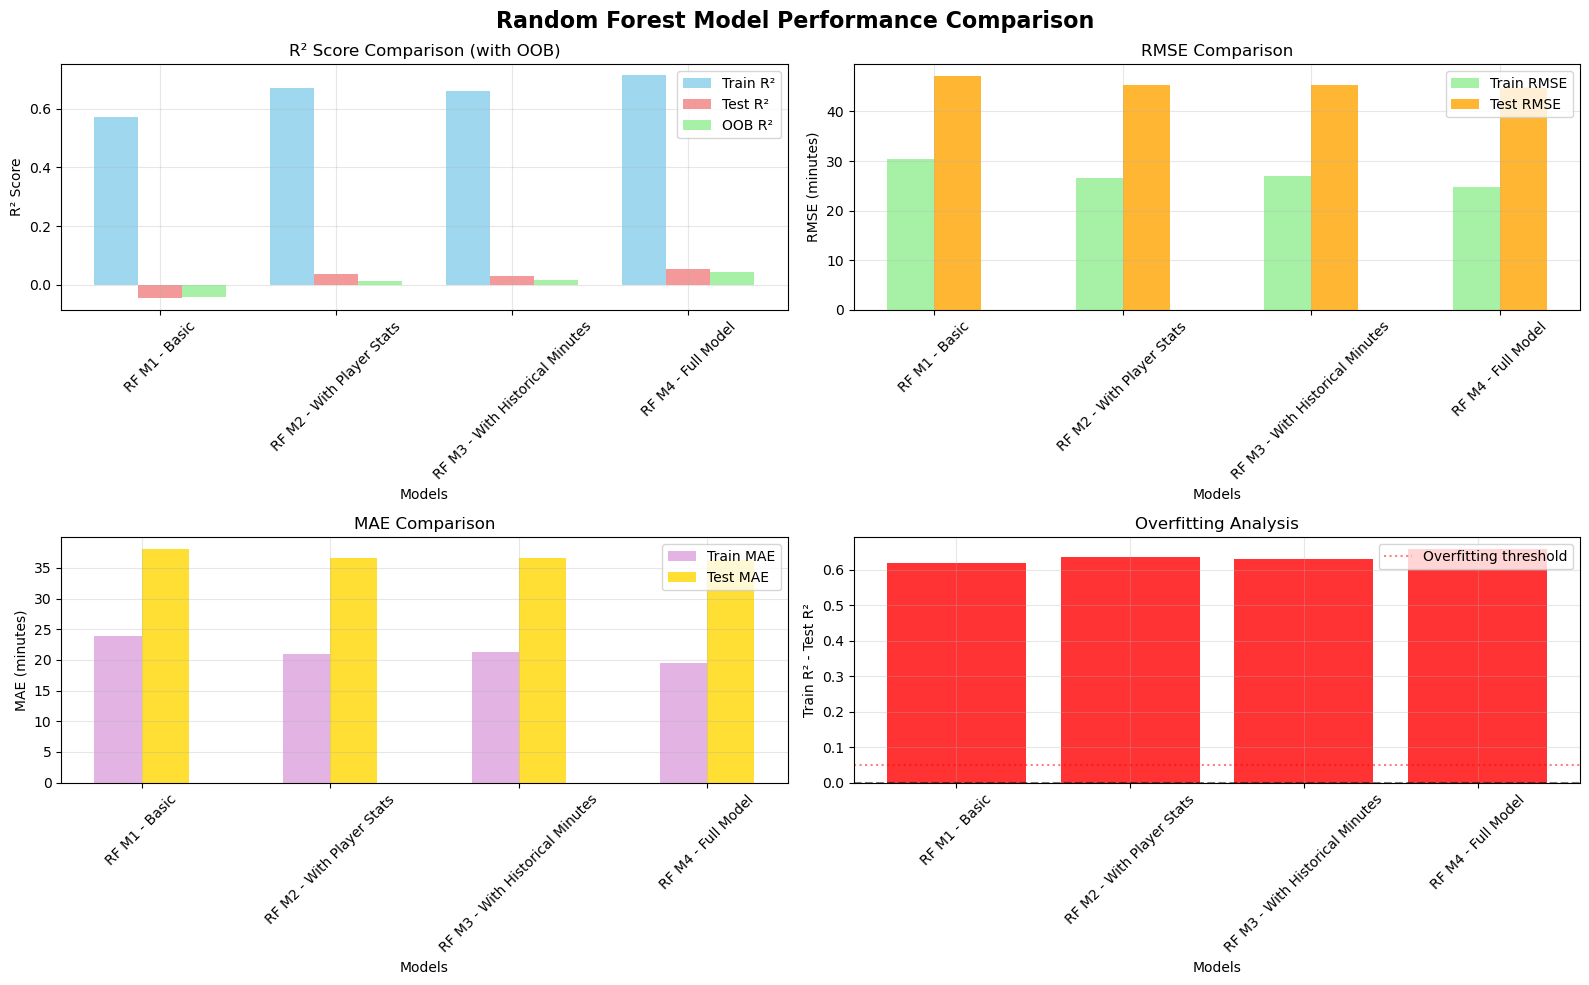


BEST RANDOM FOREST MODEL SUMMARY
Model: RF Model 4 - Full Model
Test R²: 0.0544
OOB R²: 0.0431
Test RMSE: 44.81 minutes
Test MAE: 36.21 minutes
Number of features: 14

Top 5 Most Important Features (Permutation Importance):
 1. loser_rank_points        : 0.0677
 2. winner_rank_points       : 0.0198
 3. w_avg_minutes            : 0.0144
 4. l_avg_minutes            : 0.0100
 5. surface_Grass            : 0.0084

DETAILED RANDOM FOREST ANALYSIS FOR ALL MODELS

Generating detailed analysis for: RF Model 1 - Basic


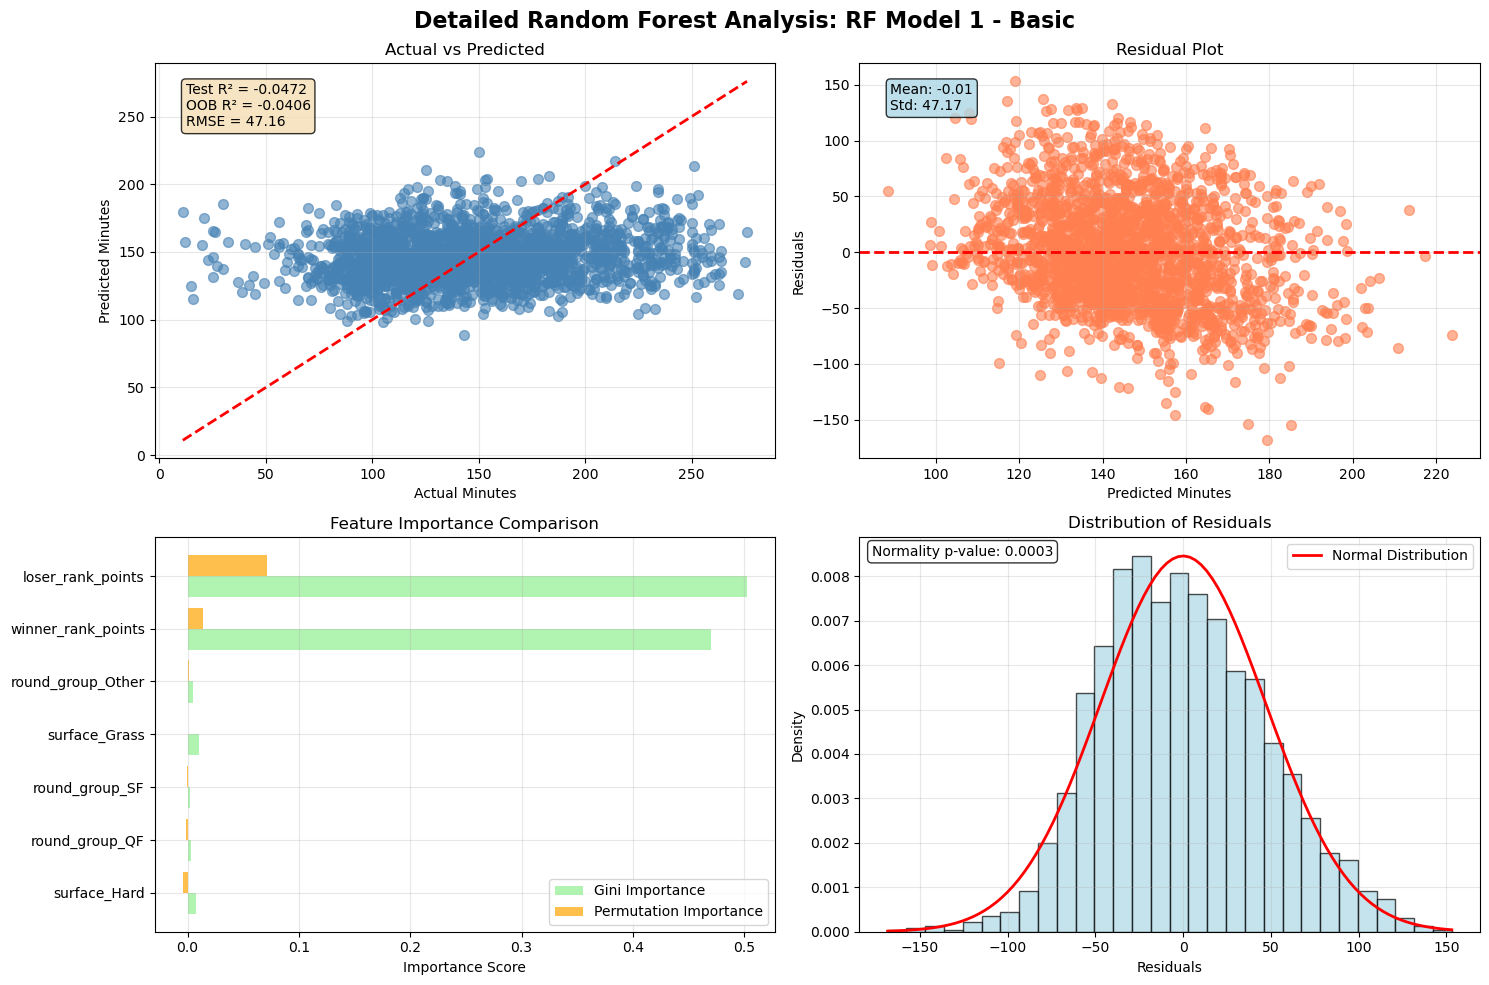


🌲 RF Model 1 - Basic Summary:
   • Test R²: -0.0472
   • OOB R²: -0.0406
   • Test RMSE: 47.16 minutes
   • Test MAE: 38.08 minutes
   • Number of features: 7
   • Top 3 most important features (permutation):
     1. loser_rank_points: 0.0716
     2. winner_rank_points: 0.0136
     3. round_group_Other: 0.0012
   ⚠️  High overfitting detected: 0.6190
------------------------------------------------------------

Generating detailed analysis for: RF Model 2 - With Player Stats


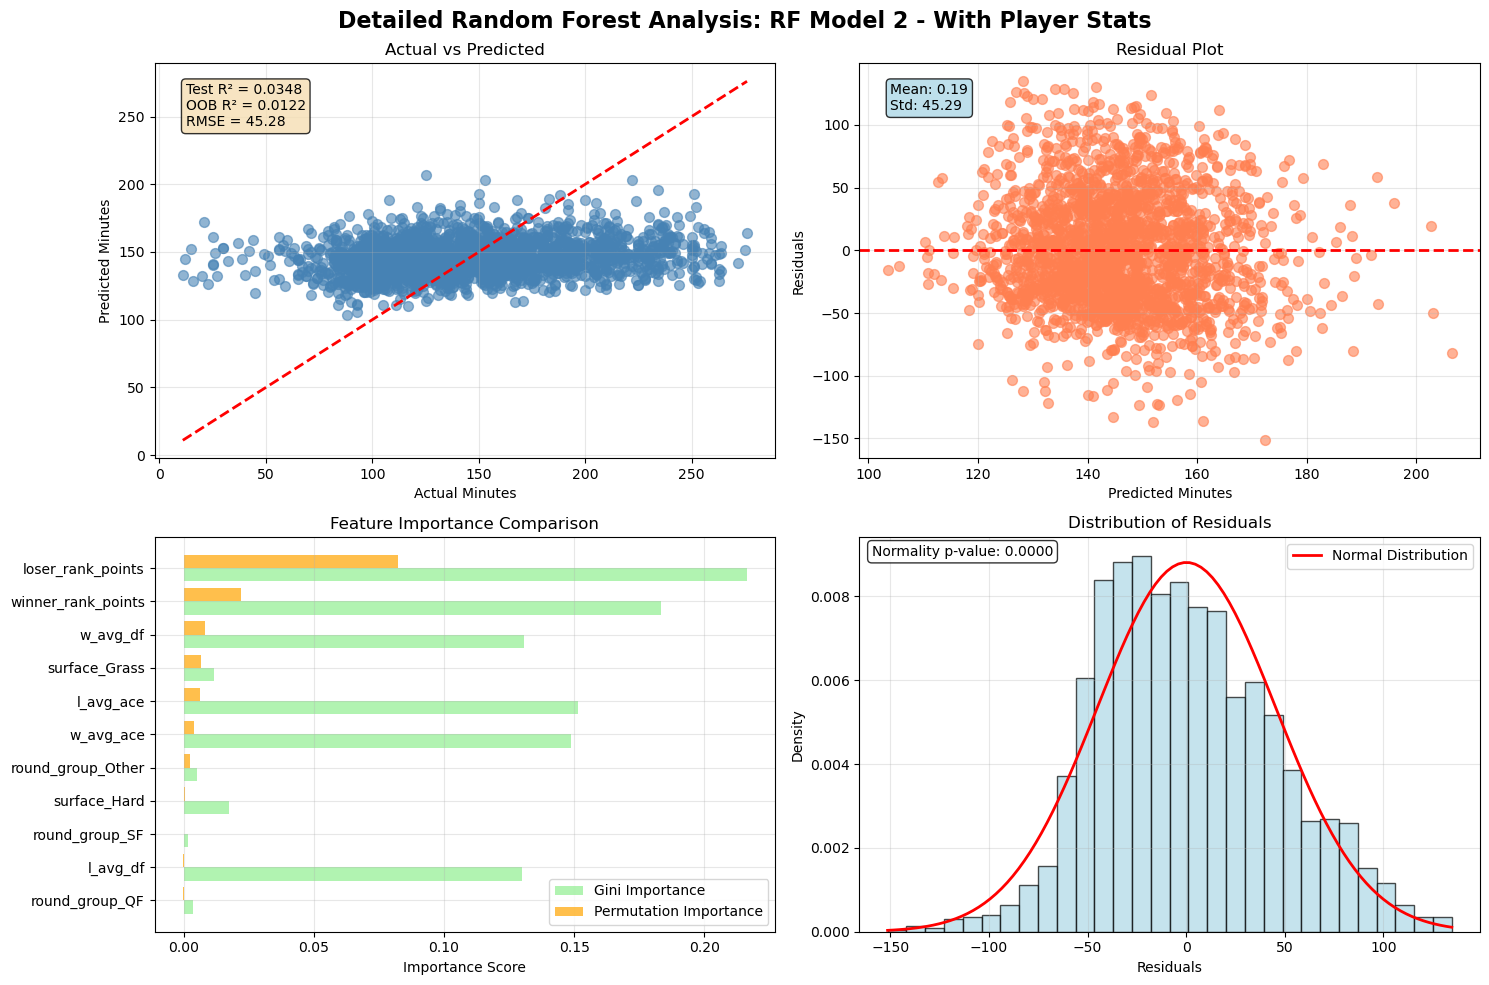


🌲 RF Model 2 - With Player Stats Summary:
   • Test R²: 0.0348
   • OOB R²: 0.0122
   • Test RMSE: 45.28 minutes
   • Test MAE: 36.54 minutes
   • Number of features: 11
   • Top 3 most important features (permutation):
     1. loser_rank_points: 0.0823
     2. winner_rank_points: 0.0219
     3. w_avg_df: 0.0082
   ⚠️  High overfitting detected: 0.6369
------------------------------------------------------------

Generating detailed analysis for: RF Model 3 - With Historical Minutes


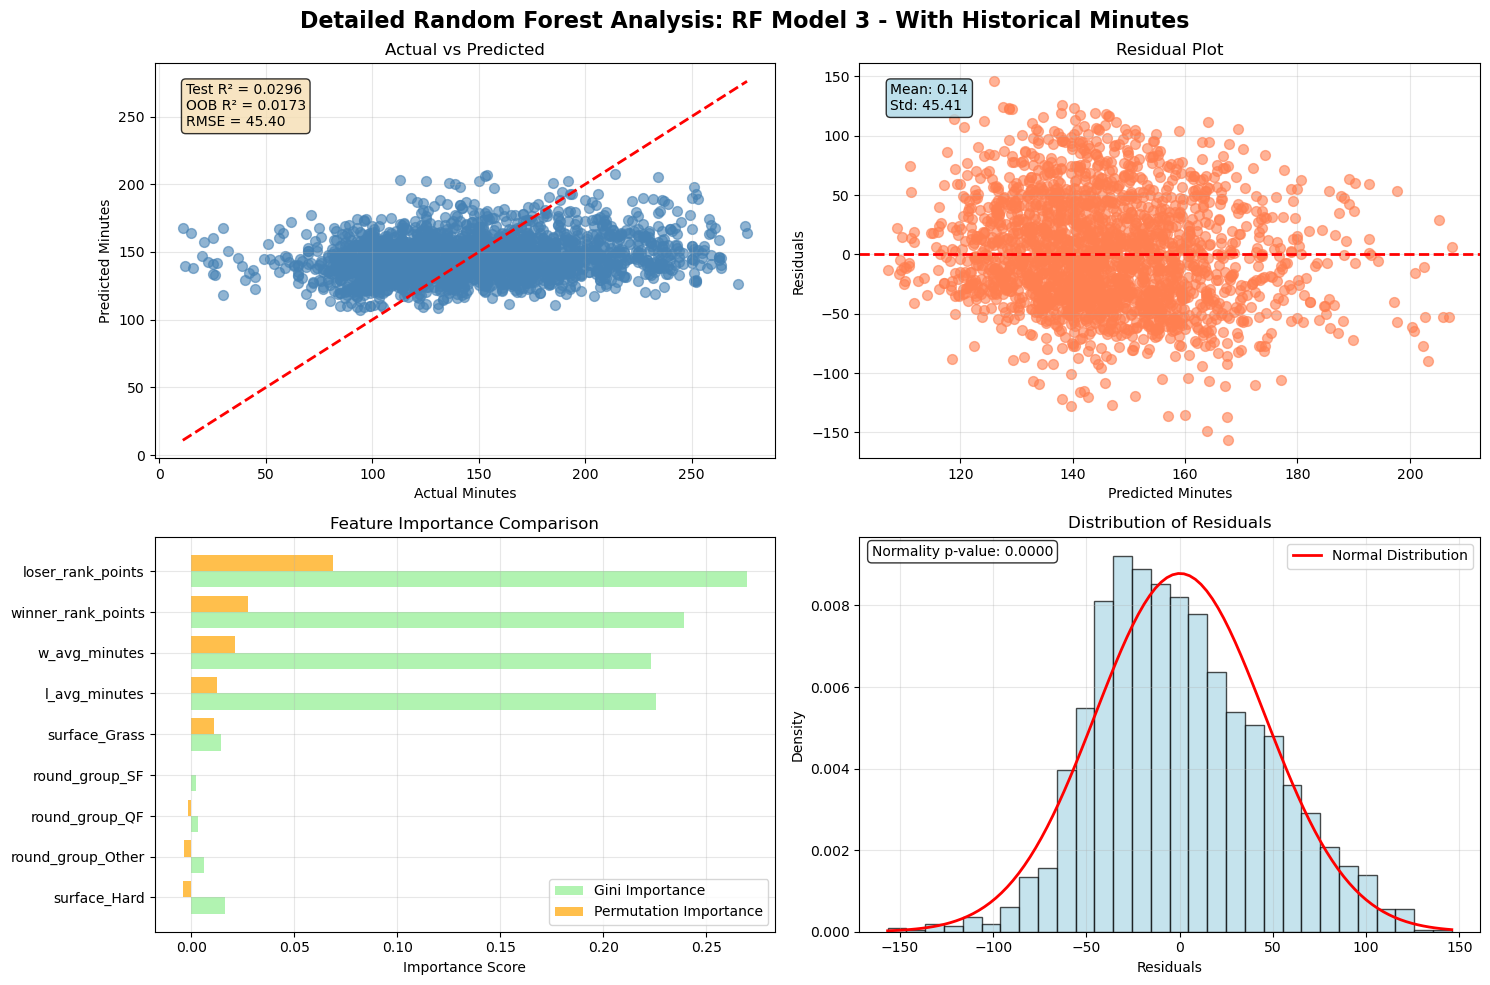


🌲 RF Model 3 - With Historical Minutes Summary:
   • Test R²: 0.0296
   • OOB R²: 0.0173
   • Test RMSE: 45.40 minutes
   • Test MAE: 36.64 minutes
   • Number of features: 9
   • Top 3 most important features (permutation):
     1. loser_rank_points: 0.0686
     2. winner_rank_points: 0.0273
     3. w_avg_minutes: 0.0210
   ⚠️  High overfitting detected: 0.6308
------------------------------------------------------------

Generating detailed analysis for: RF Model 4 - Full Model


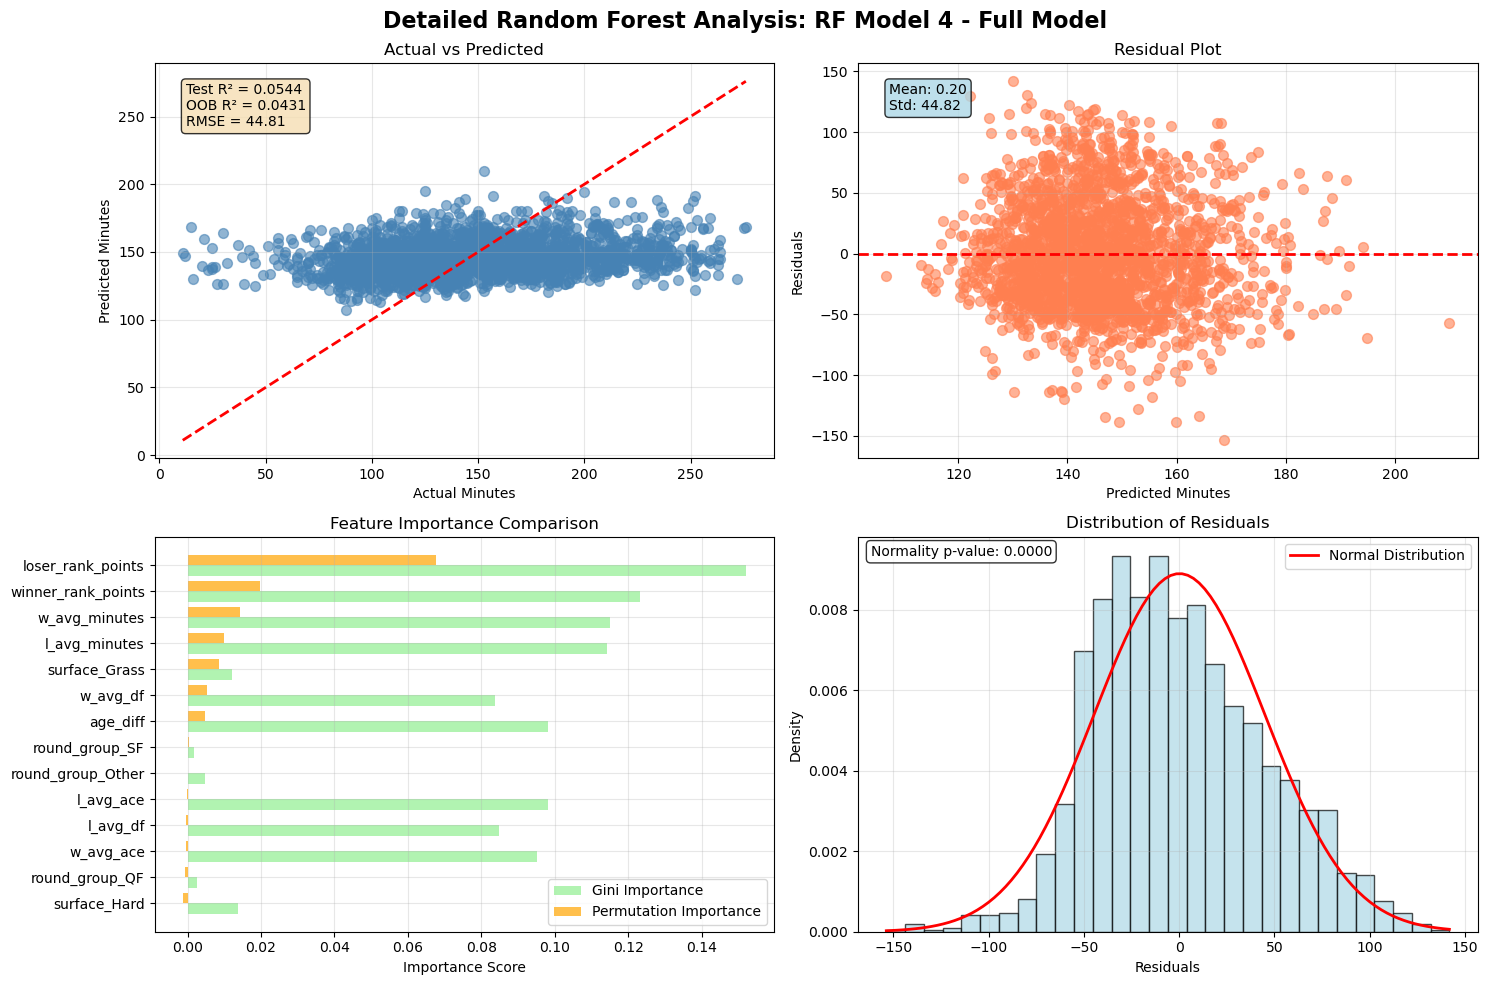


🌲 RF Model 4 - Full Model Summary:
   • Test R²: 0.0544
   • OOB R²: 0.0431
   • Test RMSE: 44.81 minutes
   • Test MAE: 36.21 minutes
   • Number of features: 14
   • Top 3 most important features (permutation):
     1. loser_rank_points: 0.0677
     2. winner_rank_points: 0.0198
     3. w_avg_minutes: 0.0144
   ⚠️  High overfitting detected: 0.6591
------------------------------------------------------------


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def create_randomforest_models(df):
    """
    Create and compare multiple Random Forest regression models
    """
    
    # Define different feature sets
    models = {
        'RF Model 1 - Basic': ['round_group_QF', 'round_group_SF', 'round_group_Other', 
                               'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points'],
        
        'RF Model 2 - With Player Stats': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                          'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                          'loser_rank_points', 'w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'],
        
        'RF Model 3 - With Historical Minutes': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                                'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                                'loser_rank_points', 'w_avg_minutes', 'l_avg_minutes'],
        
        'RF Model 4 - Full Model': ['age_diff', 'round_group_QF', 'round_group_SF', 'round_group_Other',
                                    'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points',
                                    'w_avg_ace', 'w_avg_df', 'w_avg_minutes', 'l_avg_ace', 'l_avg_df', 'l_avg_minutes']
    }
    
    # Target variable
    y = df['minutes']
    
    # Store results
    results = {}
    trained_models = {}
    test_data = {}
    
    print("=== RANDOM FOREST REGRESSION MODELS COMPARISON ===\n")
    
    for model_name, features in models.items():
        print(f"\n--- {model_name} ---")
        print(f"Features: {len(features)}")
        
        # Prepare data for this specific model
        X = df[features]
        X_train, X_test, y_train_model, y_test_model = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Store test data for later use
        test_data[model_name] = {'X_test': X_test, 'y_test': y_test_model}
        
        # Create and train Random Forest model
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            bootstrap=True,
            random_state=42,
            n_jobs=-1,
            oob_score=True
        )
        
        model.fit(X_train, y_train_model)
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Metrics
        train_r2 = r2_score(y_train_model, y_pred_train)
        test_r2 = r2_score(y_test_model, y_pred_test)
        oob_score = model.oob_score_
        train_rmse = np.sqrt(mean_squared_error(y_train_model, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test_model, y_pred_test))
        train_mae = mean_absolute_error(y_train_model, y_pred_train)
        test_mae = mean_absolute_error(y_test_model, y_pred_test)
        
        # Get feature importance
        feature_importance = model.feature_importances_
        
        # Calculate permutation importance
        perm_importance = permutation_importance(model, X_test, y_test_model, n_repeats=10, random_state=42)
        
        # Store results
        results[model_name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'oob_score': oob_score,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'features': features,
            'feature_importance': feature_importance,
            'permutation_importance': perm_importance.importances_mean
        }
        
        trained_models[model_name] = model
        
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")
        print(f"OOB Score: {oob_score:.4f}")
        print(f"Train RMSE: {train_rmse:.2f}")
        print(f"Test RMSE: {test_rmse:.2f}")
        print(f"Train MAE: {train_mae:.2f}")
        print(f"Test MAE: {test_mae:.2f}")
    
    return results, trained_models, test_data

def plot_randomforest_model_comparison(results):
    """
    Create comparison plots for all Random Forest models
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Random Forest Model Performance Comparison', fontsize=16, fontweight='bold')
    
    models = list(results.keys())
    
    # R² comparison (including OOB score)
    train_r2 = [results[model]['train_r2'] for model in models]
    test_r2 = [results[model]['test_r2'] for model in models]
    oob_r2 = [results[model]['oob_score'] for model in models]
    
    x = np.arange(len(models))
    width = 0.25
    
    axes[0,0].bar(x - width, train_r2, width, label='Train R²', alpha=0.8, color='skyblue')
    axes[0,0].bar(x, test_r2, width, label='Test R²', alpha=0.8, color='lightcoral')
    axes[0,0].bar(x + width, oob_r2, width, label='OOB R²', alpha=0.8, color='lightgreen')
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('R² Score Comparison (with OOB)')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([m.replace('RF Model ', 'RF M') for m in models], rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    train_rmse = [results[model]['train_rmse'] for model in models]
    test_rmse = [results[model]['test_rmse'] for model in models]
    
    axes[0,1].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8, color='lightgreen')
    axes[0,1].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8, color='orange')
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('RMSE (minutes)')
    axes[0,1].set_title('RMSE Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([m.replace('RF Model ', 'RF M') for m in models], rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # MAE comparison
    train_mae = [results[model]['train_mae'] for model in models]
    test_mae = [results[model]['test_mae'] for model in models]
    
    axes[1,0].bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8, color='plum')
    axes[1,0].bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8, color='gold')
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('MAE (minutes)')
    axes[1,0].set_title('MAE Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels([m.replace('RF Model ', 'RF M') for m in models], rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Overfitting analysis
    overfitting = [results[model]['train_r2'] - results[model]['test_r2'] for model in models]
    
    colors = ['red' if x > 0.05 else 'green' if x < 0 else 'orange' for x in overfitting]
    axes[1,1].bar(range(len(models)), overfitting, alpha=0.8, color=colors)
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Train R² - Test R²')
    axes[1,1].set_title('Overfitting Analysis')
    axes[1,1].set_xticks(range(len(models)))
    axes[1,1].set_xticklabels([m.replace('RF Model ', 'RF M') for m in models], rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1,1].axhline(y=0.05, color='red', linestyle=':', alpha=0.5, label='Overfitting threshold')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

def plot_detailed_randomforest_analysis(model_name, results, trained_models, test_data, df):
    """
    Detailed analysis of a specific Random Forest model
    """
    
    model = trained_models[model_name]
    features = results[model_name]['features']
    
    # Get the correct test data for this model
    X_test = test_data[model_name]['X_test']
    y_test = test_data[model_name]['y_test']
    
    # Predictions
    y_pred = model.predict(X_test)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Detailed Random Forest Analysis: {model_name}', fontsize=16, fontweight='bold')
    
    # Actual vs Predicted
    axes[0,0].scatter(y_test, y_pred, alpha=0.6, color='steelblue', s=50)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Minutes')
    axes[0,0].set_ylabel('Predicted Minutes')
    axes[0,0].set_title('Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add R² and RMSE to the plot
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    oob_score = results[model_name]['oob_score']
    axes[0,0].text(0.05, 0.95, f'Test R² = {r2:.4f}\nOOB R² = {oob_score:.4f}\nRMSE = {rmse:.2f}', 
                   transform=axes[0,0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # Residuals
    residuals = y_test - y_pred
    axes[0,1].scatter(y_pred, residuals, alpha=0.6, color='coral', s=50)
    axes[0,1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Predicted Minutes')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residual Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add residual statistics
    res_mean, res_std = residuals.mean(), residuals.std()
    axes[0,1].text(0.05, 0.95, f'Mean: {res_mean:.2f}\nStd: {res_std:.2f}', 
                   transform=axes[0,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
    
    # Feature importance comparison (Gini vs Permutation)
    gini_importance = results[model_name]['feature_importance']
    perm_importance = results[model_name]['permutation_importance']
    
    importance_df = pd.DataFrame({
        'Feature': features,
        'Gini_Importance': gini_importance,
        'Permutation_Importance': perm_importance
    }).sort_values('Permutation_Importance', ascending=True)
    
    y_pos = np.arange(len(features))
    axes[1,0].barh(y_pos - 0.2, importance_df['Gini_Importance'], height=0.4, 
                   alpha=0.7, color='lightgreen', label='Gini Importance')
    axes[1,0].barh(y_pos + 0.2, importance_df['Permutation_Importance'], height=0.4,
                   alpha=0.7, color='orange', label='Permutation Importance')
    axes[1,0].set_yticks(y_pos)
    axes[1,0].set_yticklabels(importance_df['Feature'])
    axes[1,0].set_xlabel('Importance Score')
    axes[1,0].set_title('Feature Importance Comparison')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Distribution of residuals
    axes[1,1].hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='lightblue', density=True)
    axes[1,1].set_xlabel('Residuals')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Distribution of Residuals')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add normal distribution overlay
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    normal_dist = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    axes[1,1].plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    axes[1,1].legend()
    
    # Add normality test info
    from scipy import stats
    _, p_value = stats.normaltest(residuals)
    axes[1,1].text(0.02, 0.98, f'Normality p-value: {p_value:.4f}', 
                   transform=axes[1,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_all_randomforest_models_analysis(results, trained_models, test_data, df):
    """
    Show detailed analysis for all Random Forest models
    """
    print("\n" + "="*70)
    print("DETAILED RANDOM FOREST ANALYSIS FOR ALL MODELS")
    print("="*70)
    
    for model_name in results.keys():
        print(f"\nGenerating detailed analysis for: {model_name}")
        plot_detailed_randomforest_analysis(model_name, results, trained_models, test_data, df)
        
        # Print model summary
        model_results = results[model_name]
        print(f"\n🌲 {model_name} Summary:")
        print(f"   • Test R²: {model_results['test_r2']:.4f}")
        print(f"   • OOB R²: {model_results['oob_score']:.4f}")
        print(f"   • Test RMSE: {model_results['test_rmse']:.2f} minutes")
        print(f"   • Test MAE: {model_results['test_mae']:.2f} minutes")
        print(f"   • Number of features: {len(model_results['features'])}")
        
        # Show top 3 most important features (using permutation importance)
        importance_df = pd.DataFrame({
            'Feature': model_results['features'],
            'Permutation_Importance': model_results['permutation_importance'],
            'Gini_Importance': model_results['feature_importance']
        }).sort_values('Permutation_Importance', ascending=False)
        
        print(f"   • Top 3 most important features (permutation):")
        for i, (_, row) in enumerate(importance_df.head(3).iterrows(), 1):
            print(f"     {i}. {row['Feature']}: {row['Permutation_Importance']:.4f}")
        
        # Overfitting check
        overfitting_score = model_results['train_r2'] - model_results['test_r2']
        if overfitting_score > 0.05:
            print(f"   ⚠️  High overfitting detected: {overfitting_score:.4f}")
        elif overfitting_score < 0:
            print(f"   ✅ No overfitting (model generalizes well): {overfitting_score:.4f}")
        else:
            print(f"   ✅ Low overfitting: {overfitting_score:.4f}")
            
        print("-" * 60)

def print_best_randomforest_model_summary(results):
    """
    Print summary of the best Random Forest model
    """
    
    # Find best model based on test R²
    best_model = max(results.items(), key=lambda x: x[1]['test_r2'])
    best_name, best_metrics = best_model
    
    print("\n" + "="*60)
    print("BEST RANDOM FOREST MODEL SUMMARY")
    print("="*60)
    print(f"Model: {best_name}")
    print(f"Test R²: {best_metrics['test_r2']:.4f}")
    print(f"OOB R²: {best_metrics['oob_score']:.4f}")
    print(f"Test RMSE: {best_metrics['test_rmse']:.2f} minutes")
    print(f"Test MAE: {best_metrics['test_mae']:.2f} minutes")
    print(f"Number of features: {len(best_metrics['features'])}")
    
    print(f"\nTop 5 Most Important Features (Permutation Importance):")
    importance_df = pd.DataFrame({
        'Feature': best_metrics['features'],
        'Permutation_Importance': best_metrics['permutation_importance']
    }).sort_values('Permutation_Importance', ascending=False)
    
    for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
        print(f"{i:2d}. {row['Feature']:<25}: {row['Permutation_Importance']:.4f}")
    
    return best_name

def run_complete_randomforest_analysis(df):
    """
    Run the complete Random Forest regression analysis
    """
    
    print("Starting Tennis Match Duration Random Forest Analysis...")
    print(f"Dataset shape: {df.shape}")
    print(f"Target variable (minutes) - Mean: {df['minutes'].mean():.2f}, Std: {df['minutes'].std():.2f}")
    
    # Run all Random Forest models
    results, trained_models, test_data = create_randomforest_models(df)
    
    # Plot comparison
    plot_randomforest_model_comparison(results)
    
    # Find and print best model summary
    best_model_name = print_best_randomforest_model_summary(results)
    
    # Detailed analysis of ALL models
    plot_all_randomforest_models_analysis(results, trained_models, test_data, df)
    
    return results, trained_models

# Example usage:
print("🌲 Random Forest Analysis Code is ready!")
print("To run the complete analysis, use:")
print("rf_results, rf_models = run_complete_randomforest_analysis(df_clean)")
rf_results, rf_models = run_complete_randomforest_analysis(df_clean)

# GLM Gamma Normalizado

📊 GLM Gamma Analysis Code is ready!
To run the complete analysis, use:
glm_results, glm_models = run_complete_glm_gamma_analysis(df_clean)

🔍 GLM Gamma Key Features:
• Gamma distribution for positive continuous data (duration)
• Log link function (canonical for Gamma)
• AIC/BIC for model selection
• Pseudo R² (McFadden)
• Pearson residuals analysis
• Statistical significance testing
• Deviance explained metrics
Starting Tennis Match Duration GLM Gamma Analysis...
Dataset shape: (10746, 18)
Target variable (minutes) - Mean: 145.48, Std: 46.28
Note: Using Gamma distribution with log link for positive continuous data
=== GLM GAMMA REGRESSION MODELS COMPARISON ===


--- GLM Model 1 - Basic ---
Features: 7
Train R²: 0.0441
Test R²: 0.0289
Pseudo R²: 0.0421
Train RMSE: 45.29
Test RMSE: 45.41
Train MAE: 36.66
Test MAE: 36.70
AIC: 89885.97
BIC: -76894.00

--- GLM Model 2 - With Player Stats ---
Features: 11
Train R²: 0.0475
Test R²: 0.0352
Pseudo R²: 0.0449
Train RMSE: 45.21
Test RMSE: 45.27
T

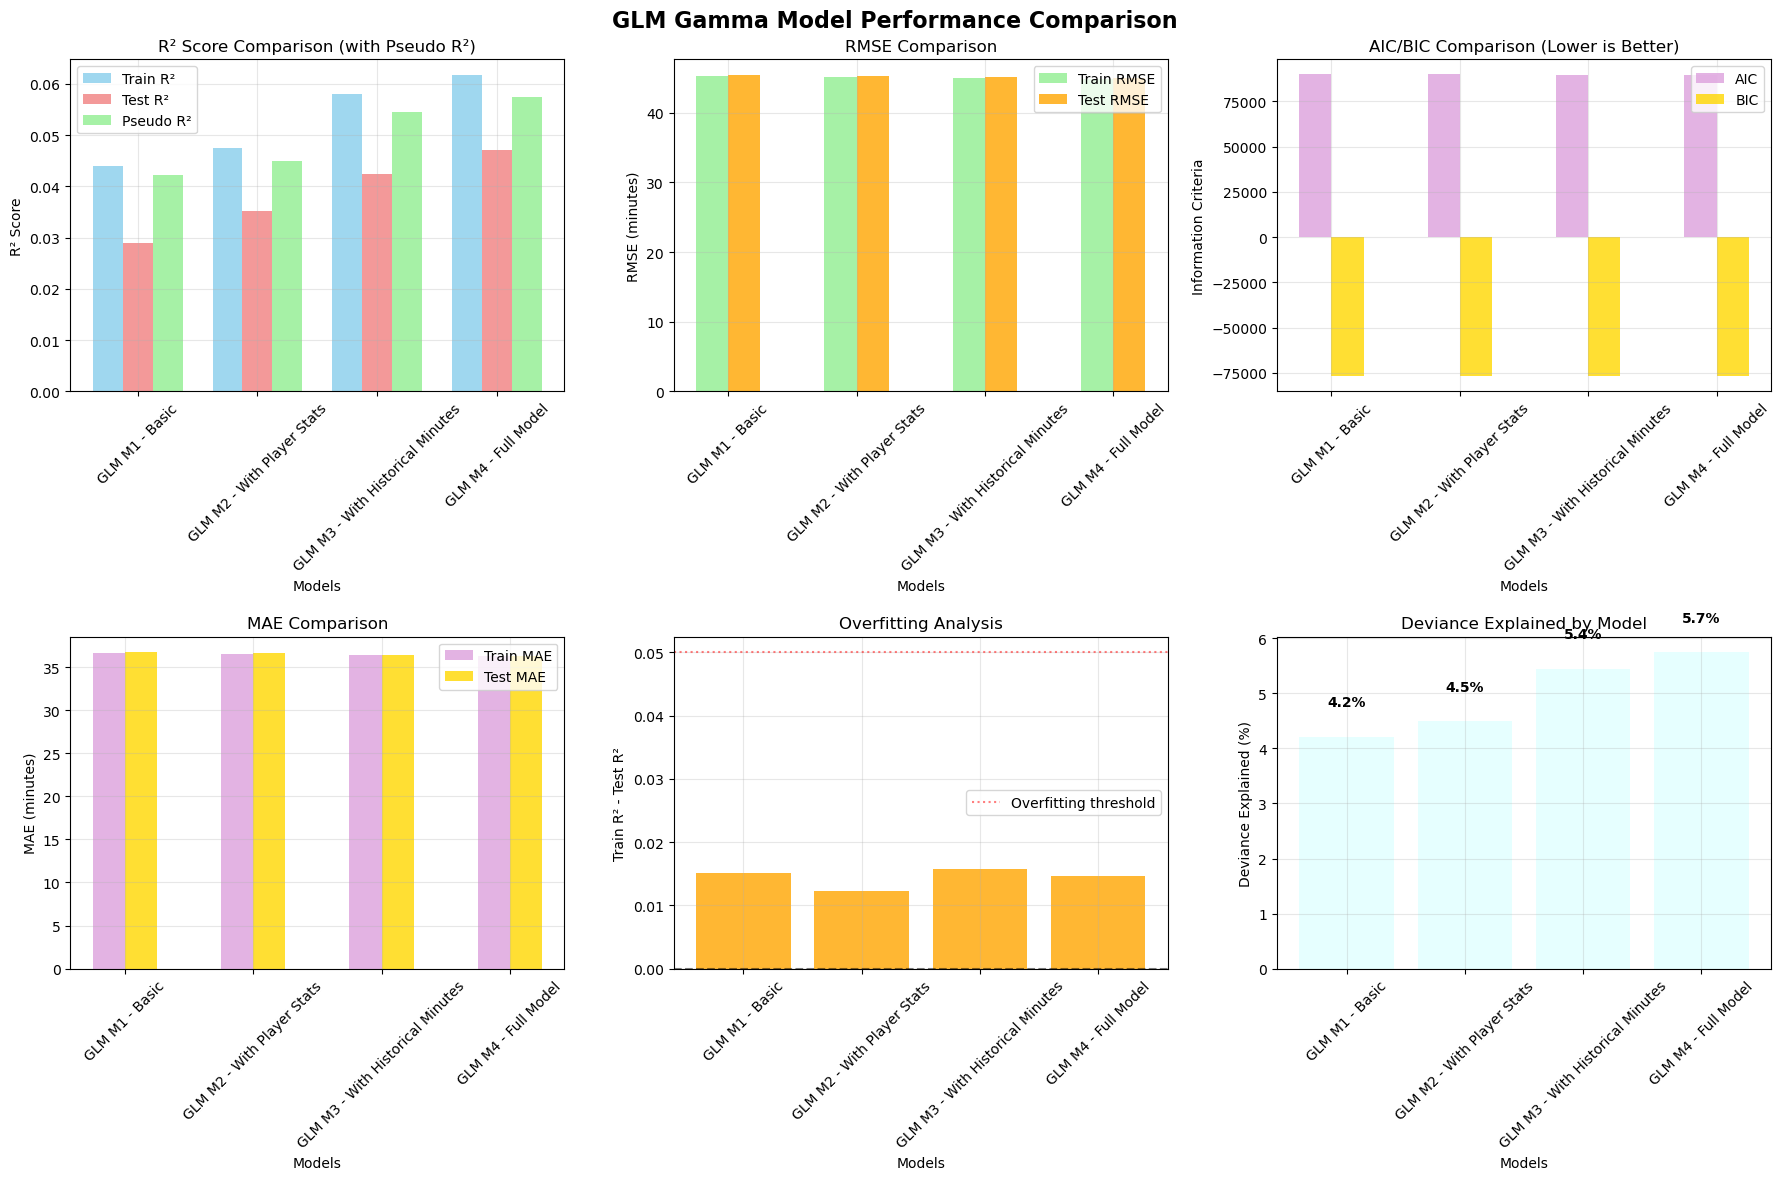


BEST GLM GAMMA MODEL SUMMARY (Based on AIC)
Model: GLM Model 4 - Full Model
Test R²: 0.0472
Pseudo R²: 0.0574
Test RMSE: 44.98 minutes
Test MAE: 36.30 minutes
AIC: 89760.40
BIC: -76845.04
Number of features: 14

Model Summary:
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.0109      0.036    138.131      0.000       4.940       5.082
age_diff               0.0001      0.003      0.038      0.970      -0.006       0.007
round_group_QF         0.0050      0.038      0.133      0.894      -0.069       0.079
round_group_SF         0.0168      0.041      0.407      0.684      -0.064       0.098
round_group_Other     -0.0159      0.036     -0.440      0.660      -0.087       0.055
surface_Grass         -0.0584      0.009     -6.187      0.000      -0.077      -0.040
surface_Hard          -0.0118      0.008     -1.428      0.153      -0.028  

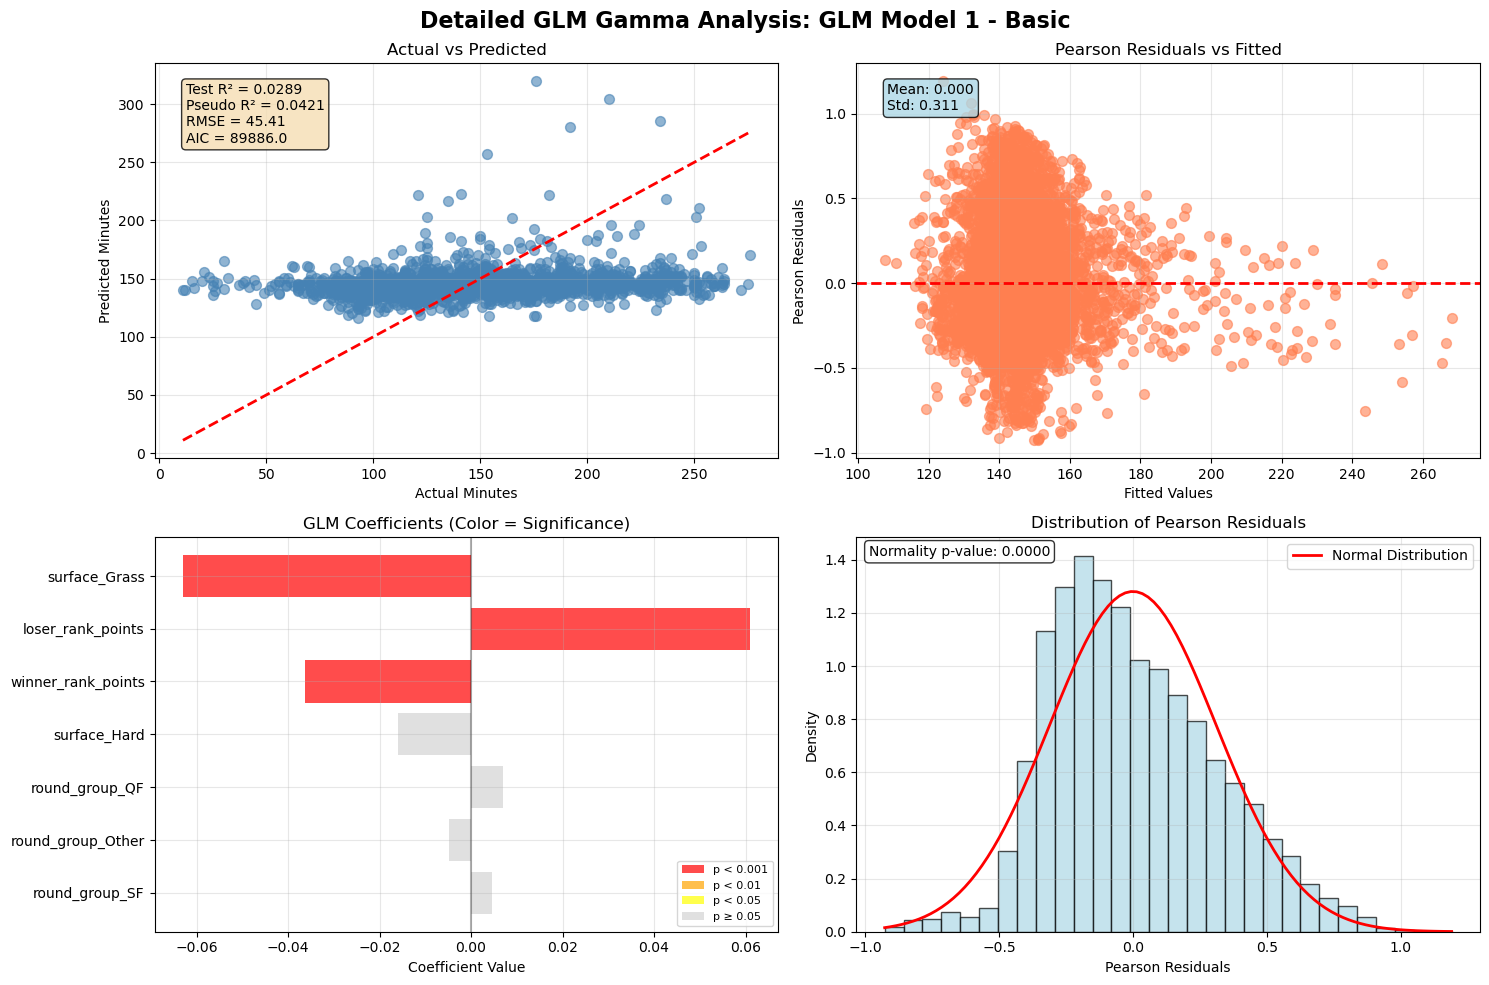


📊 GLM Model 1 - Basic Summary:
   • Test R²: 0.0289
   • Pseudo R² (McFadden): 0.0421
   • Test RMSE: 45.41 minutes
   • Test MAE: 36.70 minutes
   • AIC: 89885.97
   • BIC: -76894.00
   • Number of features: 7
   • Significant coefficients (p < 0.05):
     - loser_rank_points: increases duration (coef=0.0609, p=0.0000)
     - winner_rank_points: decreases duration (coef=-0.0363, p=0.0000)
     - surface_Grass: decreases duration (coef=-0.0630, p=0.0000)
   • Deviance explained: 4.2%
   ✅ Low overfitting: 0.0152
------------------------------------------------------------

Generating detailed analysis for: GLM Model 2 - With Player Stats


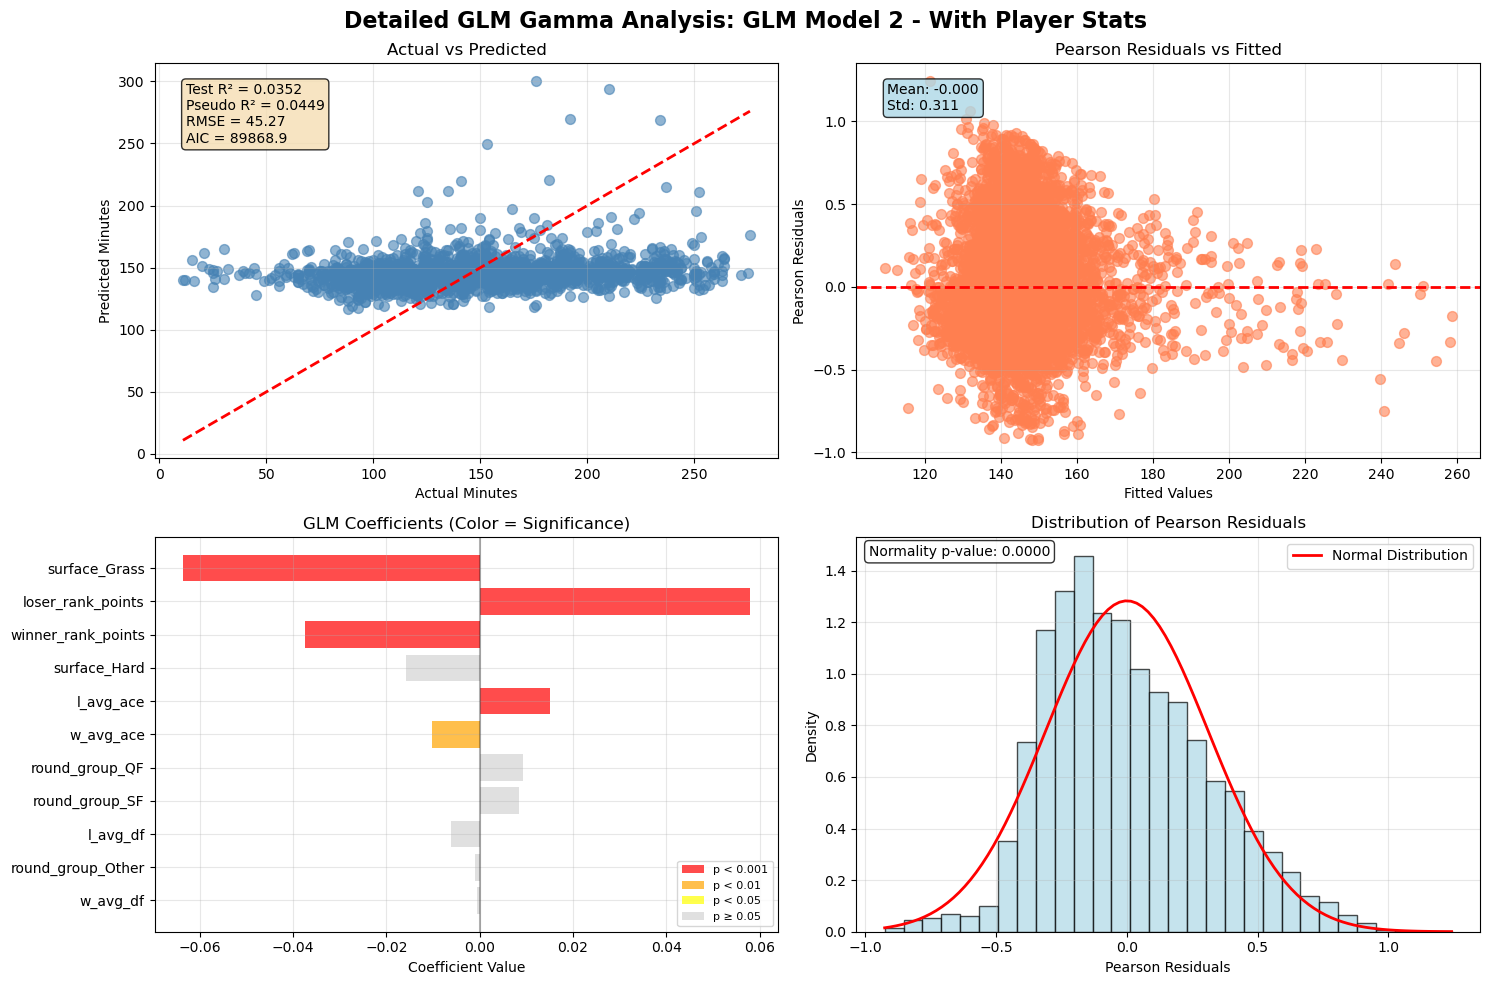


📊 GLM Model 2 - With Player Stats Summary:
   • Test R²: 0.0352
   • Pseudo R² (McFadden): 0.0449
   • Test RMSE: 45.27 minutes
   • Test MAE: 36.64 minutes
   • AIC: 89868.88
   • BIC: -76860.36
   • Number of features: 11
   • Significant coefficients (p < 0.05):
     - loser_rank_points: increases duration (coef=0.0579, p=0.0000)
     - winner_rank_points: decreases duration (coef=-0.0374, p=0.0000)
     - surface_Grass: decreases duration (coef=-0.0636, p=0.0000)
     - l_avg_ace: increases duration (coef=0.0151, p=0.0000)
     - w_avg_ace: decreases duration (coef=-0.0101, p=0.0034)
   • Deviance explained: 4.5%
   ✅ Low overfitting: 0.0123
------------------------------------------------------------

Generating detailed analysis for: GLM Model 3 - With Historical Minutes


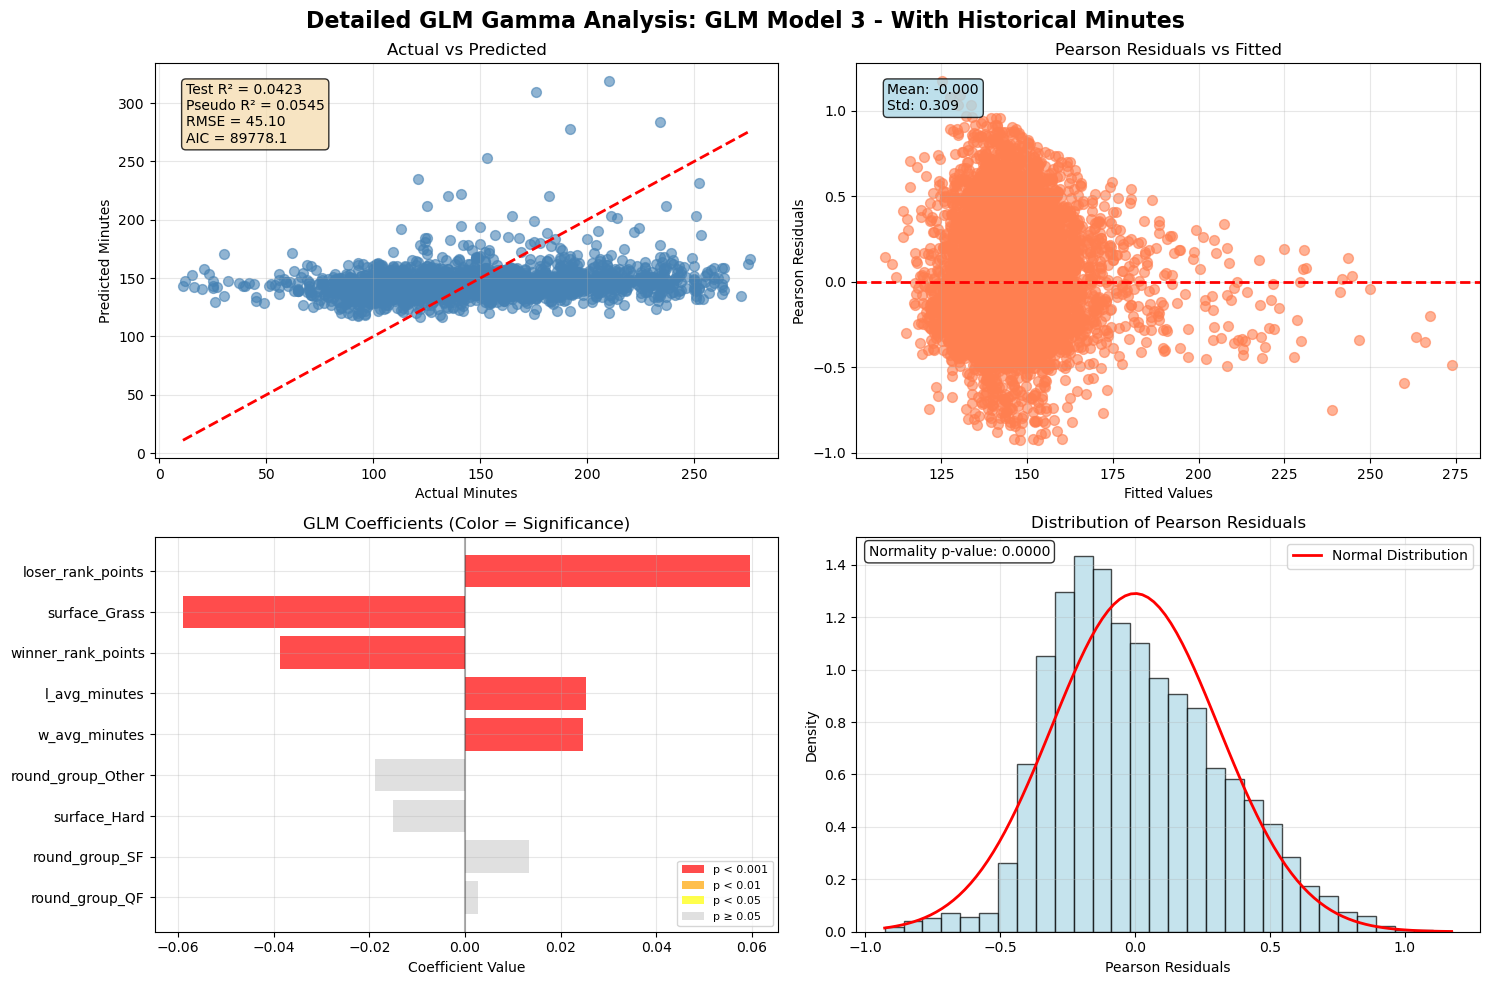


📊 GLM Model 3 - With Historical Minutes Summary:
   • Test R²: 0.0423
   • Pseudo R² (McFadden): 0.0545
   • Test RMSE: 45.10 minutes
   • Test MAE: 36.38 minutes
   • AIC: 89778.08
   • BIC: -76887.53
   • Number of features: 9
   • Significant coefficients (p < 0.05):
     - loser_rank_points: increases duration (coef=0.0596, p=0.0000)
     - winner_rank_points: decreases duration (coef=-0.0387, p=0.0000)
     - l_avg_minutes: increases duration (coef=0.0254, p=0.0000)
     - w_avg_minutes: increases duration (coef=0.0247, p=0.0000)
     - surface_Grass: decreases duration (coef=-0.0590, p=0.0000)
   • Deviance explained: 5.4%
   ✅ Low overfitting: 0.0157
------------------------------------------------------------

Generating detailed analysis for: GLM Model 4 - Full Model


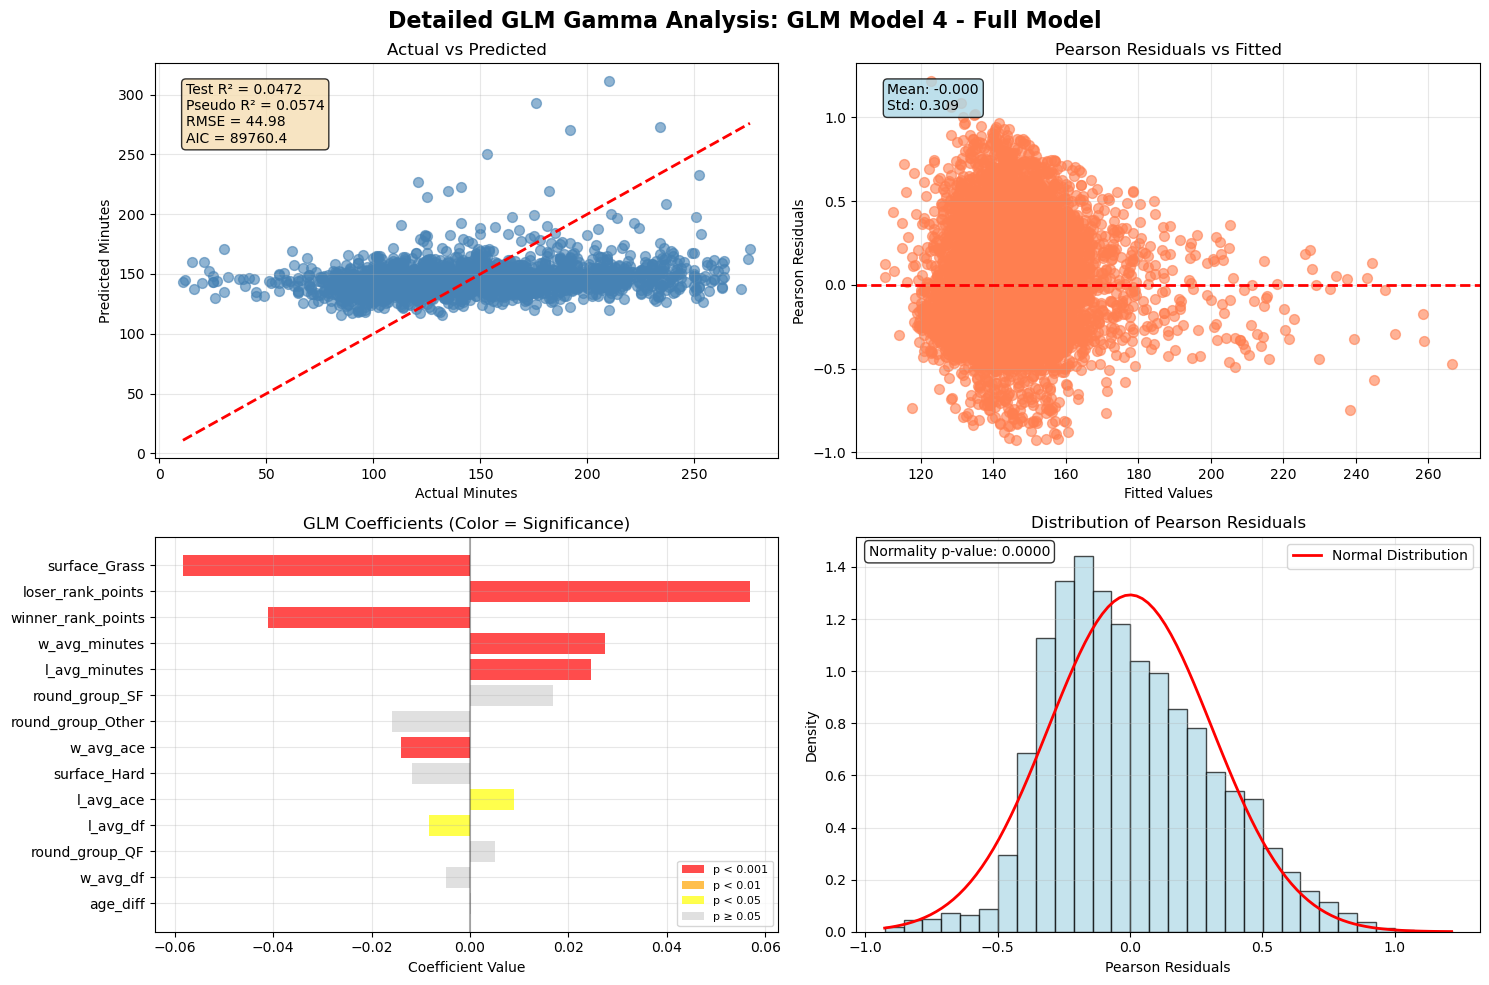


📊 GLM Model 4 - Full Model Summary:
   • Test R²: 0.0472
   • Pseudo R² (McFadden): 0.0574
   • Test RMSE: 44.98 minutes
   • Test MAE: 36.30 minutes
   • AIC: 89760.40
   • BIC: -76845.04
   • Number of features: 14
   • Significant coefficients (p < 0.05):
     - loser_rank_points: increases duration (coef=0.0569, p=0.0000)
     - winner_rank_points: decreases duration (coef=-0.0410, p=0.0000)
     - w_avg_minutes: increases duration (coef=0.0275, p=0.0000)
     - l_avg_minutes: increases duration (coef=0.0246, p=0.0000)
     - surface_Grass: decreases duration (coef=-0.0584, p=0.0000)
     - w_avg_ace: decreases duration (coef=-0.0140, p=0.0000)
     - l_avg_ace: increases duration (coef=0.0089, p=0.0119)
     - l_avg_df: decreases duration (coef=-0.0083, p=0.0202)
   • Deviance explained: 5.7%
   ✅ Low overfitting: 0.0146
------------------------------------------------------------


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.genmod.families import Gamma
from statsmodels.stats.diagnostic import het_white
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def create_glm_gamma_models(df):
    """
    Create and compare multiple GLM Gamma regression models
    """
    
    # Define different feature sets
    models = {
        'GLM Model 1 - Basic': ['round_group_QF', 'round_group_SF', 'round_group_Other', 
                                'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points'],
        
        'GLM Model 2 - With Player Stats': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                           'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                           'loser_rank_points', 'w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'],
        
        'GLM Model 3 - With Historical Minutes': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                                 'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                                 'loser_rank_points', 'w_avg_minutes', 'l_avg_minutes'],
        
        'GLM Model 4 - Full Model': ['age_diff', 'round_group_QF', 'round_group_SF', 'round_group_Other',
                                     'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points',
                                     'w_avg_ace', 'w_avg_df', 'w_avg_minutes', 'l_avg_ace', 'l_avg_df', 'l_avg_minutes']
    }
    
    # Target variable
    y = df['minutes']
    
    # Store results
    results = {}
    trained_models = {}
    test_data = {}
    scalers = {}  # Store scalers for each model
    
    print("=== GLM GAMMA REGRESSION MODELS COMPARISON ===\n")
    
    for model_name, features in models.items():
        print(f"\n--- {model_name} ---")
        print(f"Features: {len(features)}")
        
        # Prepare data for this specific model
        X = df[features].copy()
        X_train, X_test, y_train_model, y_test_model = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale continuous variables (rank points and averages) for better GLM convergence
        scaler = StandardScaler()
        continuous_vars = ['winner_rank_points', 'loser_rank_points']
        if 'w_avg_ace' in features:
            continuous_vars.extend(['w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'])
        if 'w_avg_minutes' in features:
            continuous_vars.extend(['w_avg_minutes', 'l_avg_minutes'])
        if 'age_diff' in features:
            continuous_vars.append('age_diff')
        
        # Apply scaling only to continuous variables present in this model
        continuous_vars_present = [var for var in continuous_vars if var in X_train.columns]
        
        if continuous_vars_present:
            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()
            X_train_scaled[continuous_vars_present] = scaler.fit_transform(X_train[continuous_vars_present])
            X_test_scaled[continuous_vars_present] = scaler.transform(X_test[continuous_vars_present])
        else:
            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()
        
        # Add intercept for GLM
        X_train_with_intercept = sm.add_constant(X_train_scaled)
        X_test_with_intercept = sm.add_constant(X_test_scaled)
        
        # Store test data and scaler for later use
        test_data[model_name] = {
            'X_test': X_test_with_intercept, 
            'y_test': y_test_model,
            'X_test_original': X_test,
            'feature_names': ['const'] + list(features)
        }
        scalers[model_name] = scaler
        
        # Create and train GLM Gamma model
        try:
            # Use Gamma family with log link (canonical link for Gamma)
            model = sm.GLM(y_train_model, X_train_with_intercept, 
                          family=Gamma(link=sm.families.links.log()))
            fitted_model = model.fit()
            
            # Predictions (need to handle potential numerical issues)
            try:
                y_pred_train = fitted_model.predict(X_train_with_intercept)
                y_pred_test = fitted_model.predict(X_test_with_intercept)
                
                # Ensure predictions are positive (Gamma requirement)
                y_pred_train = np.maximum(y_pred_train, 0.1)
                y_pred_test = np.maximum(y_pred_test, 0.1)
                
            except Exception as e:
                print(f"Warning: Prediction error for {model_name}: {e}")
                # Fallback to simple predictions
                y_pred_train = np.full(len(y_train_model), y_train_model.mean())
                y_pred_test = np.full(len(y_test_model), y_train_model.mean())
            
            # Metrics
            train_r2 = r2_score(y_train_model, y_pred_train)
            test_r2 = r2_score(y_test_model, y_pred_test)
            train_rmse = np.sqrt(mean_squared_error(y_train_model, y_pred_train))
            test_rmse = np.sqrt(mean_squared_error(y_test_model, y_pred_test))
            train_mae = mean_absolute_error(y_train_model, y_pred_train)
            test_mae = mean_absolute_error(y_test_model, y_pred_test)
            
            # GLM-specific metrics
            aic = fitted_model.aic
            bic = fitted_model.bic
            deviance = fitted_model.deviance
            null_deviance = fitted_model.null_deviance
            pseudo_r2 = 1 - (deviance / null_deviance)  # McFadden's pseudo R²
            
            # Get coefficients and p-values
            coefficients = fitted_model.params
            p_values = fitted_model.pvalues
            
            # Store results
            results[model_name] = {
                'train_r2': train_r2,
                'test_r2': test_r2,
                'pseudo_r2': pseudo_r2,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_mae': train_mae,
                'test_mae': test_mae,
                'aic': aic,
                'bic': bic,
                'deviance': deviance,
                'null_deviance': null_deviance,
                'features': features,
                'coefficients': coefficients,
                'p_values': p_values,
                'feature_names': ['const'] + list(features),
                'fitted_model': fitted_model
            }
            
            trained_models[model_name] = fitted_model
            
            print(f"Train R²: {train_r2:.4f}")
            print(f"Test R²: {test_r2:.4f}")
            print(f"Pseudo R²: {pseudo_r2:.4f}")
            print(f"Train RMSE: {train_rmse:.2f}")
            print(f"Test RMSE: {test_rmse:.2f}")
            print(f"Train MAE: {train_mae:.2f}")
            print(f"Test MAE: {test_mae:.2f}")
            print(f"AIC: {aic:.2f}")
            print(f"BIC: {bic:.2f}")
            
        except Exception as e:
            print(f"Error fitting {model_name}: {e}")
            # Store dummy results in case of failure
            results[model_name] = {
                'train_r2': 0, 'test_r2': 0, 'pseudo_r2': 0,
                'train_rmse': float('inf'), 'test_rmse': float('inf'),
                'train_mae': float('inf'), 'test_mae': float('inf'),
                'aic': float('inf'), 'bic': float('inf'),
                'deviance': 0, 'null_deviance': 0,
                'features': features, 'coefficients': None,
                'p_values': None, 'feature_names': ['const'] + list(features),
                'fitted_model': None
            }
    
    return results, trained_models, test_data, scalers

def plot_glm_gamma_model_comparison(results):
    """
    Create comparison plots for all GLM Gamma models
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('GLM Gamma Model Performance Comparison', fontsize=16, fontweight='bold')
    
    models = list(results.keys())
    
    # R² comparison (including Pseudo R²)
    train_r2 = [results[model]['train_r2'] for model in models]
    test_r2 = [results[model]['test_r2'] for model in models]
    pseudo_r2 = [results[model]['pseudo_r2'] for model in models]
    
    x = np.arange(len(models))
    width = 0.25
    
    axes[0,0].bar(x - width, train_r2, width, label='Train R²', alpha=0.8, color='skyblue')
    axes[0,0].bar(x, test_r2, width, label='Test R²', alpha=0.8, color='lightcoral')
    axes[0,0].bar(x + width, pseudo_r2, width, label='Pseudo R²', alpha=0.8, color='lightgreen')
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('R² Score Comparison (with Pseudo R²)')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models], rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    train_rmse = [results[model]['train_rmse'] for model in models]
    test_rmse = [results[model]['test_rmse'] for model in models]
    
    axes[0,1].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8, color='lightgreen')
    axes[0,1].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8, color='orange')
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('RMSE (minutes)')
    axes[0,1].set_title('RMSE Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models], rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Information Criteria (AIC/BIC)
    aic_values = [results[model]['aic'] for model in models if results[model]['aic'] != float('inf')]
    bic_values = [results[model]['bic'] for model in models if results[model]['bic'] != float('inf')]
    valid_models = [m for m in models if results[m]['aic'] != float('inf')]
    
    if aic_values and bic_values:
        x_valid = np.arange(len(valid_models))
        axes[0,2].bar(x_valid - width/2, aic_values, width, label='AIC', alpha=0.8, color='plum')
        axes[0,2].bar(x_valid + width/2, bic_values, width, label='BIC', alpha=0.8, color='gold')
        axes[0,2].set_xlabel('Models')
        axes[0,2].set_ylabel('Information Criteria')
        axes[0,2].set_title('AIC/BIC Comparison (Lower is Better)')
        axes[0,2].set_xticks(x_valid)
        axes[0,2].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in valid_models], rotation=45)
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
    
    # MAE comparison
    train_mae = [results[model]['train_mae'] for model in models]
    test_mae = [results[model]['test_mae'] for model in models]
    
    axes[1,0].bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8, color='plum')
    axes[1,0].bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8, color='gold')
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('MAE (minutes)')
    axes[1,0].set_title('MAE Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models], rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Overfitting analysis
    overfitting = [results[model]['train_r2'] - results[model]['test_r2'] for model in models]
    
    colors = ['red' if x > 0.05 else 'green' if x < 0 else 'orange' for x in overfitting]
    axes[1,1].bar(range(len(models)), overfitting, alpha=0.8, color=colors)
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Train R² - Test R²')
    axes[1,1].set_title('Overfitting Analysis')
    axes[1,1].set_xticks(range(len(models)))
    axes[1,1].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models], rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1,1].axhline(y=0.05, color='red', linestyle=':', alpha=0.5, label='Overfitting threshold')
    axes[1,1].legend()
    
    # Deviance Explained
    deviance_explained = []
    for model in models:
        if results[model]['null_deviance'] > 0:
            dev_exp = (1 - results[model]['deviance'] / results[model]['null_deviance']) * 100
            deviance_explained.append(dev_exp)
        else:
            deviance_explained.append(0)
    
    bars = axes[1,2].bar(models, deviance_explained, alpha=0.8, color='lightcyan')
    axes[1,2].set_xlabel('Models')
    axes[1,2].set_ylabel('Deviance Explained (%)')
    axes[1,2].set_title('Deviance Explained by Model')
    axes[1,2].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models], rotation=45)
    axes[1,2].grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar, pct in zip(bars, deviance_explained):
        if pct > 0:
            axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                          f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_detailed_glm_gamma_analysis(model_name, results, trained_models, test_data, df):
    """
    Detailed analysis of a specific GLM Gamma model
    """
    
    model = trained_models[model_name]
    model_results = results[model_name]
    
    if model is None:
        print(f"Model {model_name} failed to fit properly. Skipping detailed analysis.")
        return
    
    # Get the correct test data for this model
    X_test = test_data[model_name]['X_test']
    y_test = test_data[model_name]['y_test']
    feature_names = test_data[model_name]['feature_names']
    
    # Predictions
    try:
        y_pred = model.predict(X_test)
        y_pred = np.maximum(y_pred, 0.1)  # Ensure positive predictions
    except:
        y_pred = np.full(len(y_test), y_test.mean())
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Detailed GLM Gamma Analysis: {model_name}', fontsize=16, fontweight='bold')
    
    # Actual vs Predicted
    axes[0,0].scatter(y_test, y_pred, alpha=0.6, color='steelblue', s=50)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Minutes')
    axes[0,0].set_ylabel('Predicted Minutes')
    axes[0,0].set_title('Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add metrics to the plot
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    pseudo_r2 = model_results['pseudo_r2']
    aic = model_results['aic']
    axes[0,0].text(0.05, 0.95, f'Test R² = {r2:.4f}\nPseudo R² = {pseudo_r2:.4f}\nRMSE = {rmse:.2f}\nAIC = {aic:.1f}', 
                   transform=axes[0,0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # Residuals (Pearson residuals for GLM)
    try:
        pearson_residuals = model.resid_pearson
        fitted_values = model.fittedvalues
    except:
        residuals = y_test - y_pred
        pearson_residuals = residuals / np.sqrt(np.var(residuals))
        fitted_values = y_pred
    
    axes[0,1].scatter(fitted_values, pearson_residuals, alpha=0.6, color='coral', s=50)
    axes[0,1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Fitted Values')
    axes[0,1].set_ylabel('Pearson Residuals')
    axes[0,1].set_title('Pearson Residuals vs Fitted')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add residual statistics
    res_mean, res_std = np.mean(pearson_residuals), np.std(pearson_residuals)
    axes[0,1].text(0.05, 0.95, f'Mean: {res_mean:.3f}\nStd: {res_std:.3f}', 
                   transform=axes[0,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
    
    # Coefficients and significance
    if model_results['coefficients'] is not None and model_results['p_values'] is not None:
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': model_results['coefficients'],
            'P_Value': model_results['p_values']
        })
        
        # Remove intercept for better visualization
        coef_df_no_intercept = coef_df[coef_df['Feature'] != 'const'].copy()
        coef_df_no_intercept = coef_df_no_intercept.sort_values('Coefficient', key=abs, ascending=True)
        
        # Color bars based on significance
        colors = ['red' if p < 0.001 else 'orange' if p < 0.01 else 'yellow' if p < 0.05 else 'lightgray' 
                 for p in coef_df_no_intercept['P_Value']]
        
        bars = axes[1,0].barh(coef_df_no_intercept['Feature'], coef_df_no_intercept['Coefficient'], 
                             color=colors, alpha=0.7)
        axes[1,0].set_xlabel('Coefficient Value')
        axes[1,0].set_title('GLM Coefficients (Color = Significance)')
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Add significance legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='red', alpha=0.7, label='p < 0.001'),
                          Patch(facecolor='orange', alpha=0.7, label='p < 0.01'),
                          Patch(facecolor='yellow', alpha=0.7, label='p < 0.05'),
                          Patch(facecolor='lightgray', alpha=0.7, label='p ≥ 0.05')]
        axes[1,0].legend(handles=legend_elements, loc='lower right', fontsize=8)
    
    # Distribution of Pearson residuals
    axes[1,1].hist(pearson_residuals, bins=30, alpha=0.7, edgecolor='black', color='lightblue', density=True)
    axes[1,1].set_xlabel('Pearson Residuals')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Distribution of Pearson Residuals')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add normal distribution overlay
    mu, sigma = np.mean(pearson_residuals), np.std(pearson_residuals)
    x = np.linspace(pearson_residuals.min(), pearson_residuals.max(), 100)
    normal_dist = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    axes[1,1].plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    axes[1,1].legend()
    
    # Add normality test info
    try:
        from scipy import stats
        _, p_value = stats.normaltest(pearson_residuals)
        axes[1,1].text(0.02, 0.98, f'Normality p-value: {p_value:.4f}', 
                       transform=axes[1,1].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    except:
        pass
    
    plt.tight_layout()
    plt.show()

def plot_all_glm_gamma_models_analysis(results, trained_models, test_data, df):
    """
    Show detailed analysis for all GLM Gamma models
    """
    print("\n" + "="*70)
    print("DETAILED GLM GAMMA ANALYSIS FOR ALL MODELS")
    print("="*70)
    
    for model_name in results.keys():
        print(f"\nGenerating detailed analysis for: {model_name}")
        plot_detailed_glm_gamma_analysis(model_name, results, trained_models, test_data, df)
        
        # Print model summary
        model_results = results[model_name]
        print(f"\n📊 {model_name} Summary:")
        print(f"   • Test R²: {model_results['test_r2']:.4f}")
        print(f"   • Pseudo R² (McFadden): {model_results['pseudo_r2']:.4f}")
        print(f"   • Test RMSE: {model_results['test_rmse']:.2f} minutes")
        print(f"   • Test MAE: {model_results['test_mae']:.2f} minutes")
        print(f"   • AIC: {model_results['aic']:.2f}")
        print(f"   • BIC: {model_results['bic']:.2f}")
        print(f"   • Number of features: {len(model_results['features'])}")
        
        # Show significant coefficients
        if model_results['coefficients'] is not None and model_results['p_values'] is not None:
            coef_df = pd.DataFrame({
                'Feature': model_results['feature_names'],
                'Coefficient': model_results['coefficients'],
                'P_Value': model_results['p_values']
            })
            
            # Filter significant coefficients (excluding intercept)
            significant_coefs = coef_df[(coef_df['P_Value'] < 0.05) & (coef_df['Feature'] != 'const')]
            
            if len(significant_coefs) > 0:
                print(f"   • Significant coefficients (p < 0.05):")
                for _, row in significant_coefs.sort_values('P_Value').iterrows():
                    effect = "increases" if row['Coefficient'] > 0 else "decreases"
                    print(f"     - {row['Feature']}: {effect} duration (coef={row['Coefficient']:.4f}, p={row['P_Value']:.4f})")
            else:
                print(f"   • No significant coefficients at p < 0.05 level")
        
        # Model quality assessment
        deviance_explained = (1 - model_results['deviance'] / model_results['null_deviance']) * 100 if model_results['null_deviance'] > 0 else 0
        print(f"   • Deviance explained: {deviance_explained:.1f}%")
        
        # Overfitting check
        overfitting_score = model_results['train_r2'] - model_results['test_r2']
        if overfitting_score > 0.05:
            print(f"   ⚠️  High overfitting detected: {overfitting_score:.4f}")
        elif overfitting_score < 0:
            print(f"   ✅ No overfitting (model generalizes well): {overfitting_score:.4f}")
        else:
            print(f"   ✅ Low overfitting: {overfitting_score:.4f}")
            
        print("-" * 60)

def print_best_glm_gamma_model_summary(results):
    """
    Print summary of the best GLM Gamma model
    """
    
    # Find best model based on AIC (lower is better for GLM)
    valid_models = {k: v for k, v in results.items() if v['aic'] != float('inf')}
    
    if not valid_models:
        print("No valid models found.")
        return None
    
    best_model = min(valid_models.items(), key=lambda x: x[1]['aic'])
    best_name, best_metrics = best_model
    
    print("\n" + "="*60)
    print("BEST GLM GAMMA MODEL SUMMARY (Based on AIC)")
    print("="*60)
    print(f"Model: {best_name}")
    print(f"Test R²: {best_metrics['test_r2']:.4f}")
    print(f"Pseudo R²: {best_metrics['pseudo_r2']:.4f}")
    print(f"Test RMSE: {best_metrics['test_rmse']:.2f} minutes")
    print(f"Test MAE: {best_metrics['test_mae']:.2f} minutes")
    print(f"AIC: {best_metrics['aic']:.2f}")
    print(f"BIC: {best_metrics['bic']:.2f}")
    print(f"Number of features: {len(best_metrics['features'])}")
    
    # Show model summary
    if best_metrics['fitted_model'] is not None:
        print(f"\nModel Summary:")
        print(best_metrics['fitted_model'].summary().tables[1])
    
    return best_name

def run_complete_glm_gamma_analysis(df):
    """
    Run the complete GLM Gamma regression analysis
    """
    
    print("Starting Tennis Match Duration GLM Gamma Analysis...")
    print(f"Dataset shape: {df.shape}")
    print(f"Target variable (minutes) - Mean: {df['minutes'].mean():.2f}, Std: {df['minutes'].std():.2f}")
    print("Note: Using Gamma distribution with log link for positive continuous data")
    
    # Run all GLM Gamma models
    results, trained_models, test_data, scalers = create_glm_gamma_models(df)
    
    # Plot comparison
    plot_glm_gamma_model_comparison(results)
    
    # Find and print best model summary
    best_model_name = print_best_glm_gamma_model_summary(results)
    
    # Detailed analysis of ALL models
    plot_all_glm_gamma_models_analysis(results, trained_models, test_data, df)
    
    return results, trained_models

# Example usage:
print("📊 GLM Gamma Analysis Code is ready!")
print("To run the complete analysis, use:")
print("glm_results, glm_models = run_complete_glm_gamma_analysis(df_clean)")
print("\n🔍 GLM Gamma Key Features:")
print("• Gamma distribution for positive continuous data (duration)")
print("• Log link function (canonical for Gamma)")
print("• AIC/BIC for model selection")
print("• Pseudo R² (McFadden)")
print("• Pearson residuals analysis")
print("• Statistical significance testing")
print("• Deviance explained metrics")
glm_results, glm_models = run_complete_glm_gamma_analysis(df_clean)